# TODO:


- $\gamma_3$ = 2*0.0197, all  $(\theta, \lambda, \vartheta)$ and (y_step, logk_step) = (0.05, 0.05),  (y_max, logk_max) = (4,8) :
    
    converge but with kinks at y=2 for e(y):
    
    => check smaller (y_step, k_step)  (mainly y_step), tolerance level, time step may need to be adjusted accordingly.
    

- $\theta = 2$, five damage case $\gamma_3 \in [0. , 0.08, 0.16, 0.25 , 0.33]$, and (y_step, logk_step) = (0.05, 0.05),  (y_max, logk_max) = (4,8) :
    
    for non-zero $\gamma_3$:
    
    negative emission, explosion of pde error, and mc hitting the zero-bound.
    

- $\theta = 3$, five damage case $\gamma_3 \in [0. , 0.08, 0.16, 0.25 , 0.33]$, and (y_step, logk_step) = (0.05, 0.05),  (y_max, logk_max) = (4,8) :
    
    for non-zero $\gamma_3$:
    
    negative emission, 
    
    false transient errors oscillate at 1e-3 ~ 1e-4 level
    
    
4. $(\theta, \lambda, \vartheta) = (3, 0.134, 0.052)$
5. $(\theta, \lambda, \vartheta) = (3, 0.102, 0.036)$
6. $(\theta, \lambda, \vartheta) = (3, 0.0925, 0.032)$: reliable results $\gamma_3$ up to 0.18

In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from solver_1d import false_transient_one_iteration_python
from supportfunctions import PDESolver_2d, finiteDiff
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
import SolveLinSys
import time
from derivative import derivatives_2d
from solver_ode import solve_ode, solve_ode_one, derivative_1d, solve_ode_neumann
from solver_jump import approach_one_100, solve_smooth_100, solve_jump_100
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import matplotlib.transforms as transforms
from scipy.interpolate import RegularGridInterpolator, CubicSpline
from multiprocessing import Pool
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['figure.edgecolor'] = 'w'

In [2]:
# parameters
δ = 0.01
η = 0.032
μ = 1.86/1000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*np.mean(θ_list)
# damage function
# ȳ = 1.9
γ1 = 0.00017675
γ2 = 2*0.0022
# γ3_list = np.linspace(0, 1/3, 40)
# γ3_list = np.array([0, 0.0197*2, 0.3853*2])
y_bar = 2.3
y_jump=2.
y_overline = 2.3
y = 2.5
damage_min =  γ1*(y- y_jump+2) + γ2/2*(y - y_jump+2)**2
damage_max =  γ1*(y- y_jump+2) + γ2/2*(y - y_jump+2)**2 + 1/3/2*(y - y_jump)**2
damages = np.linspace(np.exp(-damage_max), np.exp(-damage_min), 10)
γ3_list = 2*( - np.log(damages) - γ1*(y- y_jump+2) - γ2/2*(y - y_jump+2)**2)/(y - y_jump)**2
γ3_list = np.flip(γ3_list)
γ3_list[0] = 0

dmg_weight = np.ones(len(γ3_list))/len(γ3_list)
# capital parameters
invkap = 0.09
α = 0.115
μk = - 0.043
σk = 0.0085
κ = 6.667
k0 = 80/α

In [3]:
γ3_list

array([0.        , 0.03635853, 0.07288307, 0.10957512, 0.14643624,
       0.18346798, 0.22067194, 0.25804973, 0.29560298, 0.33333333])

HJB:

$$
\begin{aligned}
0 = & \max_{i, e} \min_{\omega_\ell} - \delta v_d d - \delta \phi(k, y) + \log(\alpha - i - \alpha \bar \vartheta \left[1 - \frac{e}{\alpha \bar\lambda \exp(k)}\right]^\theta) + k - d \\
& + \frac{d\phi}{dk} \left(\mu_k + i - \frac{\kappa}{2}i^2 - \frac{| \sigma_k |^2}{2} \right) + \frac{| \sigma_k |^2}{2} \frac{d^2\phi(y)}{dk^2} \\
& + \frac{d\phi(y)}{dy} \sum \omega_\ell \theta_\ell e + \frac{|\varsigma|^2 e^2}{2} \frac{d^2 \phi(y)}{dy^2}\\
& + v_d (\Lambda'(y) \sum \omega_\ell \theta_\ell e + \frac{1}{2}\Lambda''(y)|\varsigma|^2 e^2) \\
& + \xi_a \sum \omega_\ell (\log \omega_\ell - \log \pi_\ell)
\end{aligned}
$$



Denote

$$
mc = \frac{1}{\alpha - i - \alpha \vartheta (1 - \frac{e}{\alpha \lambda  \exp(k)})^\theta}
$$

First order condition for $i$:

$$
 - mc + \frac{d\phi}{dk} (1 - \kappa i) = 0
$$

FOC for $e$:

$$
mc \cdot (\bar{\vartheta} \theta \frac{1 }{\lambda \exp (k)}  (1 - \frac{e}{\alpha \lambda \exp{k}})^{\theta - 1}) + \frac{d\phi(y)}{dy} \sum \omega_\ell \theta_\ell + \frac{d^2 \phi(y)}{dy^2}  \mid \varsigma \mid ^2  e + v_d (\Lambda' \sum \omega_\ell \theta_\ell + \Lambda'' \mid \varsigma \mid ^2 e) = 0
$$

$\theta = 3$:


In [4]:
y_step = 0.1
y_grid = np.arange(0., 4.6 + y_step, y_step)

k_step = 0.2
k_grid = np.arange(0., 10. + k_step, k_step)

(y_mat, k_mat) = np.meshgrid(y_grid, k_grid, indexing = 'ij')
stateSpace = np.hstack([y_mat.reshape(-1,1, order='F'), k_mat.reshape(-1,1,order='F')])
hy = y_grid[1] - y_grid[0]
hk = k_grid[1] - k_grid[0]
n_y = len(y_grid)
n_k = len(k_grid)

In [5]:
# HJB for ϕ_m
θ = 3
y_bar = 2.3
ξa = 0.01
ξb = 3
ϑ_bar = 0.052
λ_bar = 0.134
γ3 = γ3_list[1]
# γ3 = 2*0.0197

α=0.115
σy=1.2*np.mean(θ_list)
ϵ=2

max_iter=10_000
tol=1e-6

n_y = len(y_grid)
n_k = len(k_grid)
dy = y_grid[1] - y_grid[0]
dk = k_grid[1] - k_grid[0]

(y_mat, k_mat) = np.meshgrid(y_grid, k_grid, indexing = 'ij')
stateSpace = np.hstack([y_mat.reshape(-1,1, order='F'), k_mat.reshape(-1,1,order='F')])
πa_o = np.ones((len(θ_list), n_y, n_k))/len(θ_list)
θ_mat = np.zeros((len(θ_list), n_y, n_k))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
πa = πa_o

dΛ = γ1 + γ2*y_mat + γ3*(y_mat - y_bar)*(y_mat >y_bar)
ddΛ = γ2 + γ3*(y_mat > y_bar)

# initial guess
v0 =  (1/δ)*k_mat   -  η/δ*y_mat**2 
# initial i
a_i = κ*(1/δ)
b_i = - (1 + α*κ)*(1/δ)
c_i = α*(1/δ) - 1
i = (-b_i - np.sqrt(b_i**2 - 4*a_i*c_i))/(2*a_i)

ems = 0*np.ones(y_mat.shape)
mc = 1/(α - i - α*ϑ_bar*(1 - ems/(np.exp(k_mat)*α*λ_bar))**θ )

episode = 0
lhs_error = 0.5
vd = - 1/δ

while lhs_error > tol :#and episode < max_iter:
    vold = v0.copy()
    v0_dy = finiteDiff(v0,0,1,dy)
    v0_dy[v0_dy > - 1e-15] =  -1e-15
    v0_dyy = finiteDiff(v0,0,2,dy)
    v0_dk = finiteDiff(v0,1,1,dk)
#     v0_dk[v0_dk > - 1e-15] =  1e-15
    v0_dkk = finiteDiff(v0,1,2,dk)
    # updating controls
    i_new = (1 -mc/v0_dk)*(1/κ)
#     update emission
    if θ == 2:
        a = v0_dyy*σy**2 + vd*ddΛ*σy**2 - mc*θ*ϑ_bar/(α*λ_bar**2*np.exp(2*k_mat))
        b = mc*θ*ϑ_bar/(λ_bar*np.exp(k_mat)) + v0_dy*np.sum(θ_mat*πa, axis=0) \
            + vd*dΛ*np.sum(θ_mat*πa, axis=0)
        ems_new = - b/a
    elif θ == 3:
        a = mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat))/(α**2*λ_bar**2*np.exp(2*k_mat))
        b = - mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat))*2/(α*λ_bar*np.exp(k_mat)) + (v0_dyy+ vd*ddΛ)*σy**2 
        c =  mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat)) + (v0_dy + vd*dΛ)*np.sum(θ_mat*πa, axis=0)
        Δ = b**2 - 4*a*c
        Δ[Δ < 0] = 0
        root1 = (-b - np.sqrt(Δ))/(2*a)
        root2 = (-b + np.sqrt(Δ))/(2*a)
        if root1.all() > 0:
            ems_new = root1
        else:
            ems_new = root2
    ems_new[ems_new < 0] = 0
    i_new = i_new*0.05 + i*0.95
    ems_new = ems_new*0.05 + ems*0.95
    ratio = (1 - ems_new/(α*λ_bar*np.exp(k_mat)))*( (1 - ems_new/(α*λ_bar*np.exp(k_mat))) > 0 )
#     ratio[ratio > 1] = 1
    consumption = α - i_new - α*ϑ_bar*ratio**θ
    consumption[consumption < 1e-15] = 1e-15
    mc_new = 1/consumption
    
#     mc_new[mc_new <= 1e-15] = 1e-15
#     mc_new = mc_new*0.05 + mc*0.95
    temp = v0_dy + vd*dΛ
    weight = np.array([-1/ξa*temp*ems_new*θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πa = πa_o*np.exp(weight)
    πa[πa<1e-15] = 1e-15
    πa = πa/np.sum(πa, axis=0)
    print("min ems:", np.min(ems_new))
    print("min mc", np.min(mc_new))
    # HJB coefficient
    entropy = np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0)
    A =  -δ*np.ones(y_mat.shape)
    B_y = np.sum(θ_mat*πa, axis=0)*ems_new
    B_k = μk + i_new - 0.5*κ*i_new**2 - 0.5*σk**2
    C_yy = 0.5*ems_new**2*σy**2
    C_kk = 0.5*σk**2*np.ones(y_mat.shape)
    D = np.log(consumption) + k_mat + vd*(dΛ*np.sum(θ_mat*πa, axis=0)*ems_new + 0.5*ddΛ*σy**2*ems_new**2) \
        + ξa*entropy
    # PDE solver
    out = PDESolver_2d(stateSpace, A, B_y, B_k, C_yy, C_kk, D, v0, ϵ, solverType = 'False Transient')
    out_comp = out[2].reshape(v0.shape,order = "F")
    rhs = A*v0 + B_y*v0_dy + B_k*v0_dk + C_yy*v0_dyy + C_kk*v0_dkk  + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((out_comp - v0)/ϵ))
    #     if episode % 1 == 0:
    print("Episode {:d}: PDE Error: {:.12f}; ft Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
    episode += 1
    v0 = out_comp
    ems = ems_new
    mc = mc_new
    i = i_new

min ems: 0.0
min mc 48.043016228750396
Episode 0: PDE Error: 1.954331259826; ft Error: 1.916183386747; Iterations: 11; CG Error: 0.000000000028
min ems: 0.0
min mc 45.24871140557343
Episode 1: PDE Error: 1.910131400504; ft Error: 1.872832889430; Iterations: 12; CG Error: 0.000000000027
min ems: 0.0
min mc 43.3946942591269
Episode 2: PDE Error: 1.869187125466; ft Error: 1.832672053801; Iterations: 13; CG Error: 0.000000000031
min ems: 0.0
min mc 42.11497646355483
Episode 3: PDE Error: 1.830390494558; ft Error: 1.794797995605; Iterations: 14; CG Error: 0.000000000029
min ems: 0.0
min mc 41.212848889903455
Episode 4: PDE Error: 1.793149079352; ft Error: 1.758402669177; Iterations: 14; CG Error: 0.000000000084
min ems: 0.0
min mc 40.57131115088942
Episode 5: PDE Error: 1.757125894282; ft Error: 1.723128165415; Iterations: 15; CG Error: 0.000000000064
min ems: 0.0
min mc 40.115591590963085
Episode 6: PDE Error: 1.722118294686; ft Error: 1.688788859031; Iterations: 16; CG Error: 0.0000000000

Episode 61: PDE Error: 0.578826375656; ft Error: 0.567245998130; Iterations: 25; CG Error: 0.000000000070
min ems: 0.0
min mc 38.816040038751545
Episode 62: PDE Error: 0.567330688465; ft Error: 0.555972445398; Iterations: 25; CG Error: 0.000000000081
min ems: 0.0
min mc 38.80822926818556
Episode 63: PDE Error: 0.556082876371; ft Error: 0.544957056734; Iterations: 25; CG Error: 0.000000000094
min ems: 0.0
min mc 38.8008356211168
Episode 64: PDE Error: 0.545100811887; ft Error: 0.534210677045; Iterations: 26; CG Error: 0.000000000050
min ems: 0.0
min mc 38.79384163299115
Episode 65: PDE Error: 0.534391045998; ft Error: 0.523731818554; Iterations: 26; CG Error: 0.000000000058
min ems: 0.0
min mc 38.787229887579024
Episode 66: PDE Error: 0.523947242560; ft Error: 0.513506982190; Iterations: 26; CG Error: 0.000000000067
min ems: 0.0
min mc 38.7809831089916
Episode 67: PDE Error: 0.513751767290; ft Error: 0.503513289729; Iterations: 26; CG Error: 0.000000000076
min ems: 0.0
min mc 38.7750842

Episode 121: PDE Error: 0.176913360735; ft Error: 0.172396894065; Iterations: 38; CG Error: 0.000000000063
min ems: 0.0
min mc 38.65800200467465
Episode 122: PDE Error: 0.173474231394; ft Error: 0.169010476368; Iterations: 38; CG Error: 0.000000000069
min ems: 0.0
min mc 38.65704889855457
Episode 123: PDE Error: 0.170103342235; ft Error: 0.165691787404; Iterations: 38; CG Error: 0.000000000076
min ems: 0.0
min mc 38.6561104507798
Episode 124: PDE Error: 0.166800354290; ft Error: 0.162439919587; Iterations: 38; CG Error: 0.000000000085
min ems: 0.0
min mc 38.655186133916935
Episode 125: PDE Error: 0.163564221389; ft Error: 0.159253233373; Iterations: 38; CG Error: 0.000000000095
min ems: 0.0
min mc 38.6542754540365
Episode 126: PDE Error: 0.160393144017; ft Error: 0.156129680241; Iterations: 39; CG Error: 0.000000000065
min ems: 0.0
min mc 38.65337794930968
Episode 127: PDE Error: 0.157284962259; ft Error: 0.153067264315; Iterations: 39; CG Error: 0.000000000072
min ems: 0.0
min mc 38.6

min ems: 0.0
min mc 38.59890650306215
Episode 192: PDE Error: 0.045694066662; ft Error: 0.042864079676; Iterations: 51; CG Error: 0.000000000099
min ems: 0.0
min mc 38.59841098234847
Episode 193: PDE Error: 0.044871365410; ft Error: 0.042047633497; Iterations: 52; CG Error: 0.000000000074
min ems: 0.0
min mc 38.59792421114761
Episode 194: PDE Error: 0.044064837673; ft Error: 0.041247033069; Iterations: 52; CG Error: 0.000000000078
min ems: 0.0
min mc 38.59744610890371
Episode 195: PDE Error: 0.043274049710; ft Error: 0.040461910486; Iterations: 52; CG Error: 0.000000000082
min ems: 0.0
min mc 38.59697659193818
Episode 196: PDE Error: 0.042498650475; ft Error: 0.039691934685; Iterations: 52; CG Error: 0.000000000087
min ems: 0.0
min mc 38.596515573350054
Episode 197: PDE Error: 0.041738314161; ft Error: 0.038936752812; Iterations: 52; CG Error: 0.000000000092
min ems: 0.0
min mc 38.596062962959294
Episode 198: PDE Error: 0.040992686726; ft Error: 0.038195924134; Iterations: 52; CG Error

Episode 250: PDE Error: 0.018489489023; ft Error: 0.012335850757; Iterations: 59; CG Error: 0.000000000083
min ems: 0.0
min mc 38.58106999231211
Episode 251: PDE Error: 0.018264710806; ft Error: 0.012085993546; Iterations: 59; CG Error: 0.000000000082
min ems: 0.0
min mc 38.58090204553635
Episode 252: PDE Error: 0.018044365652; ft Error: 0.011841059448; Iterations: 59; CG Error: 0.000000000082
min ems: 0.0
min mc 38.580736921338264
Episode 253: PDE Error: 0.017828365763; ft Error: 0.011600961134; Iterations: 59; CG Error: 0.000000000081
min ems: 0.0
min mc 38.580574585067986
Episode 254: PDE Error: 0.017616625141; ft Error: 0.011365612380; Iterations: 59; CG Error: 0.000000000080
min ems: 0.0
min mc 38.58041500422425
Episode 255: PDE Error: 0.017409059539; ft Error: 0.011134928065; Iterations: 59; CG Error: 0.000000000079
min ems: 0.0
min mc 38.58025814823867
Episode 256: PDE Error: 0.017205586419; ft Error: 0.010908824173; Iterations: 59; CG Error: 0.000000000078
min ems: 0.0
min mc 3

Episode 319: PDE Error: 0.010015131071; ft Error: 0.003104147087; Iterations: 55; CG Error: 0.000000000077
min ems: 0.0
min mc 38.574641129662666
Episode 320: PDE Error: 0.009958613988; ft Error: 0.003043269009; Iterations: 55; CG Error: 0.000000000075
min ems: 0.0
min mc 38.574600754488515
Episode 321: PDE Error: 0.009903207384; ft Error: 0.002983572403; Iterations: 54; CG Error: 0.000000000098
min ems: 0.0
min mc 38.574561219314745
Episode 322: PDE Error: 0.009848889065; ft Error: 0.002925059551; Iterations: 54; CG Error: 0.000000000097
min ems: 0.0
min mc 38.574522504299004
Episode 323: PDE Error: 0.009795637724; ft Error: 0.002867695968; Iterations: 54; CG Error: 0.000000000095
min ems: 0.0
min mc 38.57448459015756
Episode 324: PDE Error: 0.009743432537; ft Error: 0.002811458014; Iterations: 54; CG Error: 0.000000000093
min ems: 0.0
min mc 38.57444745815039
Episode 325: PDE Error: 0.009692253013; ft Error: 0.002756322576; Iterations: 54; CG Error: 0.000000000091
min ems: 0.0
min mc

min ems: 0.0
min mc 38.57327853676205
Episode 376: PDE Error: 0.008066392867; ft Error: 0.001003613294; Iterations: 50; CG Error: 0.000000000086
min ems: 0.0
min mc 38.573265448751044
Episode 377: PDE Error: 0.008048139061; ft Error: 0.000983927322; Iterations: 50; CG Error: 0.000000000084
min ems: 0.0
min mc 38.573252616911674
Episode 378: PDE Error: 0.008030243393; ft Error: 0.000964626746; Iterations: 50; CG Error: 0.000000000082
min ems: 0.0
min mc 38.573240036200794
Episode 379: PDE Error: 0.008012698835; ft Error: 0.000945704173; Iterations: 50; CG Error: 0.000000000081
min ems: 0.0
min mc 38.57322770167616
Episode 380: PDE Error: 0.007995498500; ft Error: 0.000927152348; Iterations: 50; CG Error: 0.000000000079
min ems: 0.0
min mc 38.57321560849448
Episode 381: PDE Error: 0.007978635634; ft Error: 0.000908964145; Iterations: 50; CG Error: 0.000000000078
min ems: 0.0
min mc 38.573203751909794
Episode 382: PDE Error: 0.007962103613; ft Error: 0.000891127799; Iterations: 49; CG Err

min ems: 0.0
min mc 38.57282646366445
Episode 433: PDE Error: 0.007436684642; ft Error: 0.000324458230; Iterations: 46; CG Error: 0.000000000080
min ems: 0.0
min mc 38.57282222585807
Episode 434: PDE Error: 0.007430783172; ft Error: 0.000318091471; Iterations: 46; CG Error: 0.000000000079
min ems: 0.0
min mc 38.57281807130979
Episode 435: PDE Error: 0.007424997452; ft Error: 0.000311849505; Iterations: 46; CG Error: 0.000000000077
min ems: 0.0
min mc 38.572813998362264
Episode 436: PDE Error: 0.007419325213; ft Error: 0.000305729963; Iterations: 46; CG Error: 0.000000000075
min ems: 0.0
min mc 38.57281000538903
Episode 437: PDE Error: 0.007413764228; ft Error: 0.000299730499; Iterations: 46; CG Error: 0.000000000074
min ems: 0.0
min mc 38.572806090794636
Episode 438: PDE Error: 0.007408312312; ft Error: 0.000293855856; Iterations: 45; CG Error: 0.000000000100
min ems: 0.0
min mc 38.57280225302114
Episode 439: PDE Error: 0.007402967799; ft Error: 0.000288087154; Iterations: 45; CG Error

Episode 492: PDE Error: 0.007229298170; ft Error: 0.000100819059; Iterations: 41; CG Error: 0.000000000093
min ems: 0.0
min mc 38.57267602209835
Episode 493: PDE Error: 0.007227463450; ft Error: 0.000098841006; Iterations: 41; CG Error: 0.000000000091
min ems: 0.0
min mc 38.57267472773924
Episode 494: PDE Error: 0.007225664975; ft Error: 0.000096902246; Iterations: 41; CG Error: 0.000000000090
min ems: 0.0
min mc 38.5726734591801
Episode 495: PDE Error: 0.007223901923; ft Error: 0.000095001523; Iterations: 41; CG Error: 0.000000000088
min ems: 0.0
min mc 38.57267221591702
Episode 496: PDE Error: 0.007222173529; ft Error: 0.000093137879; Iterations: 41; CG Error: 0.000000000086
min ems: 0.0
min mc 38.5726709974537
Episode 497: PDE Error: 0.007220479067; ft Error: 0.000091310509; Iterations: 41; CG Error: 0.000000000084
min ems: 0.0
min mc 38.5726698033009
Episode 498: PDE Error: 0.007218817844; ft Error: 0.000089517740; Iterations: 41; CG Error: 0.000000000083
min ems: 0.0
min mc 38.572

Episode 552: PDE Error: 0.007164264038; ft Error: 0.000030727897; Iterations: 36; CG Error: 0.000000000095
min ems: 0.0
min mc 38.57263018750697
Episode 553: PDE Error: 0.007163705461; ft Error: 0.000030124284; Iterations: 36; CG Error: 0.000000000094
min ems: 0.0
min mc 38.572629787955734
Episode 554: PDE Error: 0.007163157770; ft Error: 0.000029532226; Iterations: 36; CG Error: 0.000000000092
min ems: 0.0
min mc 38.57262939641876
Episode 555: PDE Error: 0.007162620743; ft Error: 0.000028954237; Iterations: 36; CG Error: 0.000000000090
min ems: 0.0
min mc 38.57262901277285
Episode 556: PDE Error: 0.007162094174; ft Error: 0.000028387809; Iterations: 36; CG Error: 0.000000000088
min ems: 0.0
min mc 38.57262863689599
Episode 557: PDE Error: 0.007161577864; ft Error: 0.000027832144; Iterations: 36; CG Error: 0.000000000086
min ems: 0.0
min mc 38.57262826866661
Episode 558: PDE Error: 0.007161071622; ft Error: 0.000027286905; Iterations: 36; CG Error: 0.000000000085
min ems: 0.0
min mc 38

min ems: 0.0
min mc 38.57261629483573
Episode 613: PDE Error: 0.007144268469; ft Error: 0.000009192278; Iterations: 32; CG Error: 0.000000000079
min ems: 0.0
min mc 38.57261616957168
Episode 614: PDE Error: 0.007144101709; ft Error: 0.000009008089; Iterations: 32; CG Error: 0.000000000077
min ems: 0.0
min mc 38.572616046348486
Episode 615: PDE Error: 0.007143938216; ft Error: 0.000008843287; Iterations: 31; CG Error: 0.000000000098
min ems: 0.0
min mc 38.57261592512064
Episode 616: PDE Error: 0.007143777471; ft Error: 0.000008665139; Iterations: 31; CG Error: 0.000000000096
min ems: 0.0
min mc 38.57261580589563
Episode 617: PDE Error: 0.007143619866; ft Error: 0.000008489819; Iterations: 31; CG Error: 0.000000000094
min ems: 0.0
min mc 38.57261568867628
Episode 618: PDE Error: 0.007143465360; ft Error: 0.000008318180; Iterations: 31; CG Error: 0.000000000092
min ems: 0.0
min mc 38.57261557346494
Episode 619: PDE Error: 0.007143313908; ft Error: 0.000008151155; Iterations: 31; CG Error:

Episode 673: PDE Error: 0.007138355852; ft Error: 0.000002790958; Iterations: 27; CG Error: 0.000000000083
min ems: 0.0
min mc 38.572612014943914
Episode 674: PDE Error: 0.007138305167; ft Error: 0.000002758697; Iterations: 26; CG Error: 0.000000000098
min ems: 0.0
min mc 38.57261198093701
Episode 675: PDE Error: 0.007138255478; ft Error: 0.000002697687; Iterations: 26; CG Error: 0.000000000099
min ems: 0.0
min mc 38.572611947061894
Episode 676: PDE Error: 0.007138206965; ft Error: 0.000002635008; Iterations: 26; CG Error: 0.000000000091
min ems: 0.0
min mc 38.572611913331215
Episode 677: PDE Error: 0.007138159502; ft Error: 0.000002584850; Iterations: 26; CG Error: 0.000000000093
min ems: 0.0
min mc 38.57261187973363
Episode 678: PDE Error: 0.007138112780; ft Error: 0.000002528181; Iterations: 26; CG Error: 0.000000000093
min ems: 0.0
min mc 38.5726118462692
Episode 679: PDE Error: 0.007138066980; ft Error: 0.000002480735; Iterations: 26; CG Error: 0.000000000083
min ems: 0.0
min mc 3

In [6]:
y_mat.shape

(47, 51)

In [7]:
indicator = (ems > 0)

(array([0.05555556, 0.08333333, 0.13194444, 0.13888889, 0.11805556,
        0.20138889, 0.10416667, 0.07638889, 0.0625    , 0.02777778]),
 array([1.0154  , 1.194787, 1.374174, 1.553561, 1.732948, 1.912335,
        2.091722, 2.271109, 2.450496, 2.629883, 2.80927 ]),
 <BarContainer object of 10 artists>)

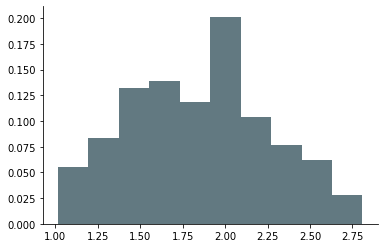

In [8]:
plt.hist(θ_list*1000, weights=πa[:,-1,-1])
plt.hist(θ_list*1000, weights=πa_o[:, 0, 0], alpha=0.3)

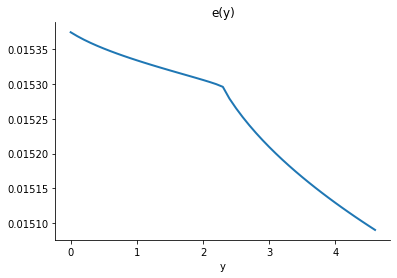

In [9]:
plt.plot(y_grid, ems[:, 0])
plt.xlabel('y')
plt.title('e(y)')
# plt.savefig('emission.png')
plt.show()

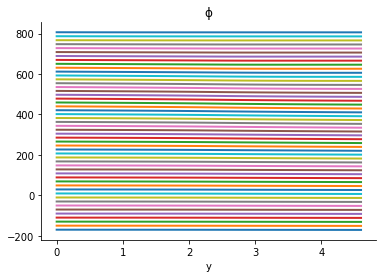

In [10]:
plt.plot(y_grid, v0[:, -60:])
plt.xlabel('y')
plt.title('ϕ')
# plt.savefig('emission.png')
plt.show()

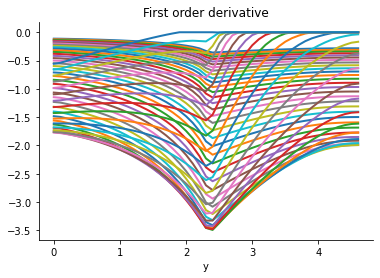

In [11]:
plt.plot(y_grid, v0_dy)
plt.title('First order derivative')
plt.xlabel('y')
# plt.savefig('1stderi.png')
plt.show()

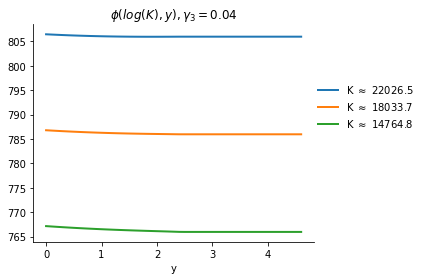

In [12]:
loc1 = np.abs(np.exp(k_grid) - 700).argmin()
# plt.plot(y_grid, v0[:, loc1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
# plt.plot(y_grid, v0[:, loc1+1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1+1])))
plt.plot(y_grid, v0[:, -1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[-1])),)
plt.plot(y_grid, v0[:, -2], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[-2])), )
plt.plot(y_grid, v0[:, -3], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[-3])), )
plt.legend(loc=(1, 0.5))
plt.title(r'$\phi(log(K), y), \gamma_3 = {:.2f}$'.format(γ3))
plt.xlabel('y')
plt.tight_layout()
# plt.savefig('v.png', dpi=300)
plt.show()

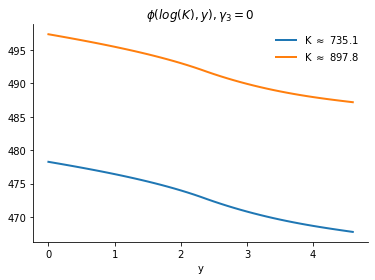

In [13]:
plt.plot(y_grid, v0[:, loc1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, v0[:, loc1+1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1+1])))
plt.legend()
plt.title(r'$\phi(log(K), y), \gamma_3 = 0$')
plt.xlabel('y')
# plt.savefig('ϕ_new.png', dpi=300)
plt.show()

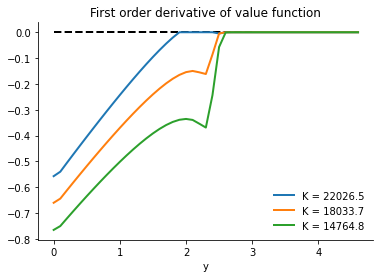

In [14]:
plt.plot(y_grid, v0_dy[:,-1], label="K = {:.1f}".format(np.exp(k_grid[-1])))
plt.plot(y_grid, v0_dy[:,-2], label="K = {:.1f}".format(np.exp(k_grid[-2])))
plt.plot(y_grid, v0_dy[:,-3], label="K = {:.1f}".format(np.exp(k_grid[-3])))
plt.hlines(0, 0, 3, linestyle='dashed', color="black")
plt.legend(loc=4)
plt.title('First order derivative of value function')
plt.xlabel('y')
# plt.savefig('firstoder.png', dpi=300)
plt.show()

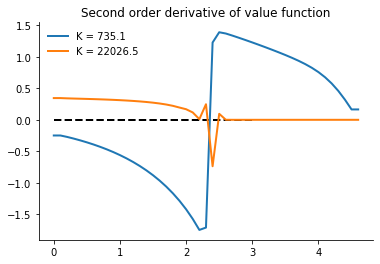

In [15]:
plt.plot(y_grid, v0_dyy[:,loc1], label="K = {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, v0_dyy[:, -1], label="K = {:.1f}".format(np.exp(k_grid[-1])))
plt.hlines(0, 0, 3, linestyle='dashed', color="black")
plt.legend()
plt.title('Second order derivative of value function')
# plt.savefig('secondorder.png', dpi=300)
plt.show()

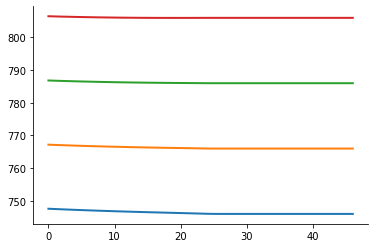

In [16]:
plt.plot(v0[:, -4:])
plt.show()

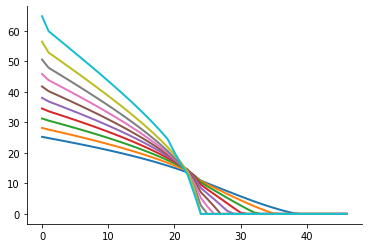

In [17]:
plt.plot(ems[:, -10:])
plt.show()

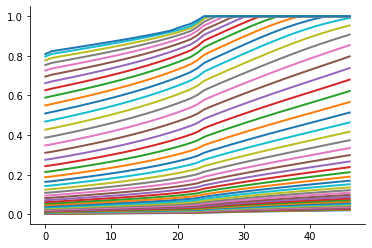

In [18]:
plt.plot(1 -  ems_new/(α*λ_bar*np.exp(k_mat)))
plt.show()

Text(0.5, 0, 'y')

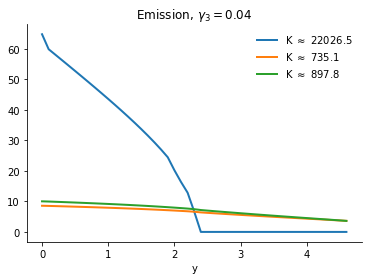

In [19]:
# plt.plot(y_grid, ems[:, -1])
# plt.plot(y_grid, ems[:, 0], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[0])))
plt.plot(y_grid, ems[:, -1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[-1])))
plt.plot(y_grid, ems[:, loc1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, ems[:, loc1+1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1+1])))
plt.legend()
plt.title(r'Emission, $\gamma_3 = {:.2f}$'.format(γ3))
plt.xlabel('y')
# plt.savefig('emission_2.png', dpi=300)
# plt.ylim(0,12)

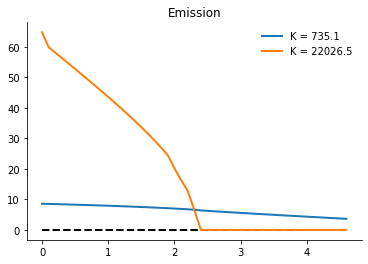

In [20]:
plt.plot(y_grid, ems[:,loc1], label="K = {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, ems[:, -1], label="K = {:.1f}".format(np.exp(k_grid[-1])))
plt.hlines(0, 0, 4, linestyle='dashed', color="black")
plt.legend()
plt.title('Emission')
# plt.savefig('emission.png', dpi=300)
plt.show()

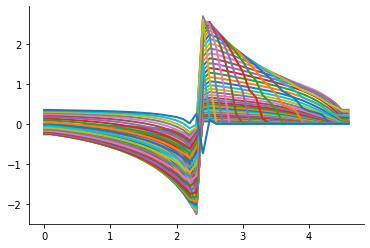

In [21]:
plt.plot(y_grid, v0_dyy)
plt.show()

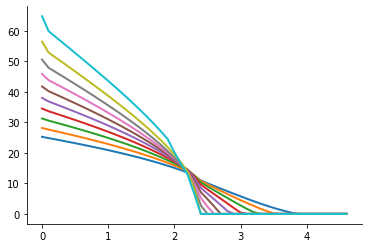

In [22]:
plt.plot(y_grid, ems[:, -10:])
plt.show()

In [23]:
y_grid[-10], y_mat.shape

(3.7, (47, 51))

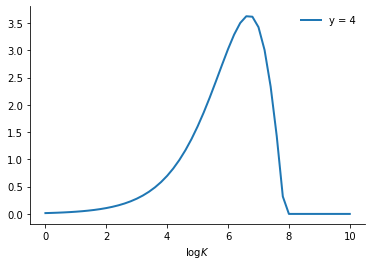

In [24]:
plt.plot(k_grid, ems[-1], label="y = 4")
plt.xlabel("$\log K$")
plt.legend()
# plt.savefig('e_logk.png')

Text(0.5, 1.0, 'Emission, $\\gamma_3 = 0.04$')

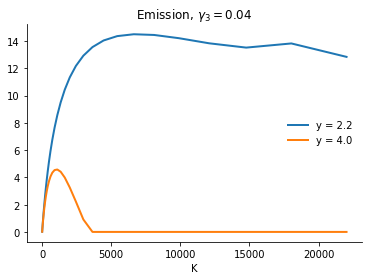

In [25]:
loc = np.abs(y_grid  - 2.2).argmin()
plt.plot(np.exp(k_grid), ems[loc], label = "y = {}".format(y_grid[loc]))
loc = np.abs(y_grid  - 4).argmin()
plt.plot(np.exp(k_grid), ems[loc], label = "y = {}".format(y_grid[loc]))
plt.legend()
plt.xlabel('K')
plt.title('Emission, $\gamma_3 = {:.2f}$'.format(γ3))
# plt.savefig('emission_k.png', dpi=300)

Text(0.5, 1.0, 'Emission')

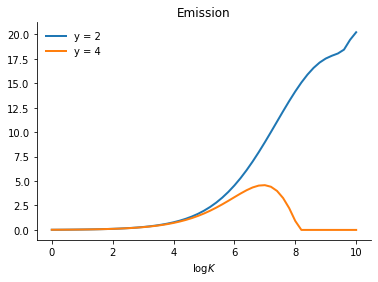

In [26]:
loc = np.abs(y_grid  - 2).argmin()
plt.plot(k_grid, ems[loc], label = "y = 2")
loc = np.abs(y_grid  - 4).argmin()
plt.plot(k_grid, ems[loc], label = "y = 4")
plt.legend()
plt.xlabel('$\log K$')
plt.title('Emission')
# plt.savefig('emission_k_9.png', dpi=300)

Text(0.5, 0, 'y')

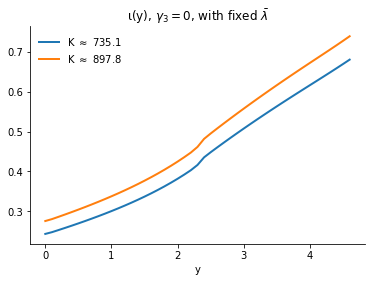

In [27]:
iota = 1 - ems/np.exp(k_mat)/α/λ_bar
plt.plot(y_grid, iota[:, loc1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, iota[:, loc1+1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1+1])))
plt.legend()
plt.title(r'ι(y), $\gamma_3 = 0$, with fixed $\bar \lambda$')
plt.xlabel('y')
# plt.savefig('iota_01.png', dpi=300)

Text(0.5, 0, 'y')

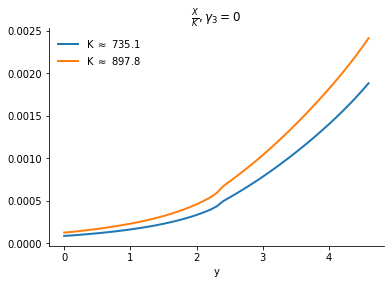

In [28]:
ra = α*ϑ_bar*iota**θ
plt.plot(y_grid, ra[:, loc1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, ra[:, loc1+1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1+1])))
plt.legend()
plt.title(r'$\frac{X}{K}, \gamma_3 = 0$')
plt.xlabel('y')
# plt.savefig('XK_new.png', dpi=300)

Text(0.5, 0, 'y')

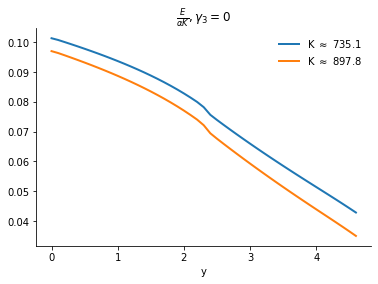

In [29]:
ra = ems/np.exp(k_mat)/α
plt.plot(y_grid, ra[:, loc1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, ra[:, loc1+1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1+1])))
plt.legend()
plt.title(r'$\frac{E}{\alpha K}, \gamma_3 = 0$')
plt.xlabel('y')
# plt.savefig('ratio_01.png', dpi=300)

Text(0.5, 0, 'y')

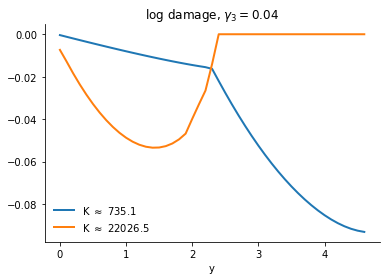

In [30]:
logn_drift = vd*(dΛ*np.sum(θ_mat*πa, axis=0)*ems_new + 0.5*ddΛ*σy**2*ems_new**2)
plt.plot(y_grid, logn_drift[:, loc1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, logn_drift[:, -1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[-1])))
plt.legend()
plt.title(r'log damage, $\gamma_3 = {:.2f}$'.format(γ3))
plt.xlabel('y')
# plt.savefig('logn.png', dpi=300)

Text(0.5, 0, 'y')

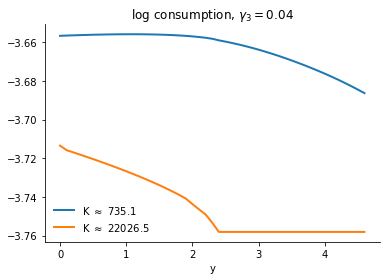

In [31]:
plt.plot(y_grid, np.log(consumption[:, loc1]), label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, np.log(consumption[:, -1]), label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[-1])))
plt.legend()
plt.title(r'log consumption, $\gamma_3 = {:.2f}$'.format(γ3))
plt.xlabel('y')
# plt.savefig('logC.png', dpi=300)

In [32]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt

In [33]:
def ode_y_parallel(args_list):
    with Pool() as p:
        res_list = p.starmap(solve_new, args_list)
    return res_list        

In [34]:
def solve_new(y_grid, k_grid, args, ϵ=0.5, max_iter=2000, tol=1e-6):
    
    δ, η, α, μk, σk, κ, θ, θ_list, σy, γ1, γ2, γ3, y_bar, ξa, ϑ_bar, λ_bar = args
    n_y = len(y_grid)
    n_k = len(k_grid)
    dy = y_grid[1] - y_grid[0]
    dk = k_grid[1] - k_grid[0]
    
    (y_mat, k_mat) = np.meshgrid(y_grid, k_grid, indexing = 'ij')
    stateSpace = np.hstack([y_mat.reshape(-1,1, order='F'), k_mat.reshape(-1,1,order='F')])
    πa_o = np.ones((len(θ_list), n_y, n_k))/len(θ_list)
    θ_mat = np.zeros((len(θ_list), n_y, n_k))
    for i in range(len(θ_list)):
        θ_mat[i] = θ_list[i]
    πa = πa_o

    dΛ = γ1 + γ2*y_mat + γ3*(y_mat - y_bar)*(y_mat >y_bar)
    ddΛ = γ2 + γ3*(y_mat > y_bar)

    # initial guess
    v0 =  (1/δ)*k_mat   -  η/δ*y_mat**2 
    # initial i
    a_i = κ*(1/δ)
    b_i = - (1 + α*κ)*(1/δ)
    c_i = α*(1/δ) - 1
    i = (-b_i - np.sqrt(b_i**2 - 4*a_i*c_i))/(2*a_i)

    ems = 0*np.ones(y_mat.shape)
    mc = 1/(α - i - α*ϑ_bar*(1 - ems/(np.exp(k_mat)*α*λ_bar))**θ )

    episode = 0
    lhs_error = 0.5
    vd = - 1/δ

    while lhs_error > tol and episode < max_iter:
        vold = v0.copy()
        v0_dy = finiteDiff(v0,0,1,dy)
        v0_dy[v0_dy > - 1e-15] =  -1e-15
        v0_dyy = finiteDiff(v0,0,2,dy)
        v0_dk = finiteDiff(v0,1,1,dk)
    #     v0_dk[v0_dk > - 1e-15] =  1e-15
        v0_dkk = finiteDiff(v0,1,2,dk)
        # updating controls
        i_new = (1 -mc/v0_dk)*(1/κ)
    #     update emission
        if θ == 2:
            a = v0_dyy*σy**2 + vd*ddΛ*σy**2 - mc*θ*ϑ_bar/(α*λ_bar**2*np.exp(2*k_mat))
            b = mc*θ*ϑ_bar/(λ_bar*np.exp(k_mat)) + v0_dy*np.sum(θ_mat*πa, axis=0) \
                + vd*dΛ*np.sum(θ_mat*πa, axis=0)
            ems_new = - b/a
        elif θ == 3:
            a = mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat))/(α**2*λ_bar**2*np.exp(2*k_mat))
            b = - mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat))*2/(α*λ_bar*np.exp(k_mat)) + (v0_dyy+ vd*ddΛ)*σy**2 
            c =  mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat)) + (v0_dy + vd*dΛ)*np.sum(θ_mat*πa, axis=0)
            Δ = b**2 - 4*a*c
            Δ[Δ < 0] = 0
            root1 = (-b - np.sqrt(Δ))/(2*a)
            root2 = (-b + np.sqrt(Δ))/(2*a)
            if root1.all() > 0:
                ems_new = root1
            else:
                ems_new = root2
        ems_new[ems_new < 0] = 0
        i_new = i_new*0.05 + i*0.95
        ems_new = ems_new*0.05 + ems*0.95
        ratio = (1 - ems_new/(α*λ_bar*np.exp(k_mat)))*( (1 - ems_new/(α*λ_bar*np.exp(k_mat))) > 0 )
    #     ratio[ratio > 1] = 1
        consumption = α - i_new - α*ϑ_bar*ratio**θ
    #     consumption[consumption < 1e-15] = 1e-15
        mc_new = 1/consumption

    #     mc_new[mc_new <= 1e-15] = 1e-15
    #     mc_new = mc_new*0.05 + mc*0.95
        temp = v0_dy + vd*dΛ
        weight = np.array([-1/ξa*temp*ems_new*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πa = πa_o*np.exp(weight)
        πa[πa<1e-15] = 1e-15
        πa = πa/np.sum(πa, axis=0)
#         print("min ems:", np.min(ems_new))
#         print("min mc", np.min(mc_new))
        # HJB coefficient
        entropy = np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0)
        A =  -δ*np.ones(y_mat.shape)
        B_y = np.sum(θ_mat*πa, axis=0)*ems_new
        B_k = μk + i_new - 0.5*κ*i_new**2 - 0.5*σk**2
        C_yy = 0.5*ems_new**2*σy**2
        C_kk = 0.5*σk**2*np.ones(y_mat.shape)
        D = np.log(consumption) + k_mat + vd*(dΛ*np.sum(θ_mat*πa, axis=0)*ems_new + 0.5*ddΛ*σy**2*ems_new**2) \
            + ξa*entropy
        # PDE solver
        out = PDESolver_2d(stateSpace, A, B_y, B_k, C_yy, C_kk, D, v0, ϵ, solverType = 'False Transient')
        out_comp = out[2].reshape(v0.shape,order = "F")
        rhs = A*v0 + B_y*v0_dy + B_k*v0_dk + C_yy*v0_dyy + C_kk*v0_dkk  + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0)/ϵ))
        #     if episode % 1 == 0:
#         print("Episode {:d}: PDE Error: {:.12f}; ft Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems = ems_new
        mc = mc_new
        i = i_new
    print("Episode {:d}: PDE Error: {:.12f}; ft Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
    result = dict(v0=v0, ems=ems, i=i,  πa=πa, v0_dy=v0_dy, v0_dyy=v0_dyy)
    return result

In [35]:
γ3_list.shape, y_bar

((10,), 2.3)

# Testing parameters


## 1. $(\theta, \lambda, \vartheta) = (3, 0.134, 0.052)$

In [36]:
args_list = []

θ=3
ξa=0.01
ϑ_bar=0.052
λ_bar=0.134

y_bar = 2.3

for γ3_i in γ3_list:
    args_func = (δ, η, α, μk, σk, κ, θ, θ_list, σy, γ1, γ2, γ3_i, y_bar, ξa, ϑ_bar, λ_bar)
    args_iter = (y_grid, k_grid, args_func, 1, 3_000, 1e-6)
    args_list.append(args_iter)

res_list = ode_y_parallel(args_list)

Episode 1451: PDE Error: 0.009814926628; ft Error: 0.000000990797; Iterations: 8; CG Error: 0.000000000088
Episode 1451: PDE Error: 0.008113409073; ft Error: 0.000000997797; Iterations: 8; CG Error: 0.000000000086
Episode 1451: PDE Error: 0.009039400610; ft Error: 0.000000996738; Iterations: 8; CG Error: 0.000000000086
Episode 1450: PDE Error: 0.011522076444; ft Error: 0.000000995691; Iterations: 8; CG Error: 0.000000000093
Episode 1450: PDE Error: 0.010435406951; ft Error: 0.000000997504; Iterations: 8; CG Error: 0.000000000086
Episode 1450: PDE Error: 0.011026576775; ft Error: 0.000000997935; Iterations: 8; CG Error: 0.000000000087
Episode 1451: PDE Error: 0.007136639461; ft Error: 0.000000993796; Iterations: 8; CG Error: 0.000000000085
Episode 1451: PDE Error: 0.012394963906; ft Error: 0.000000982039; Iterations: 9; CG Error: 0.000000000092
Episode 1451: PDE Error: 0.011954829643; ft Error: 0.000000991792; Iterations: 8; CG Error: 0.000000000095
Episode 3000: PDE Error: 0.2144721333

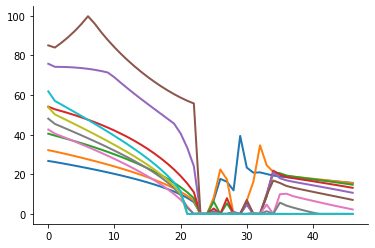

In [76]:
plt.plot(res_list[0]['ems'][:,-10:])
plt.show()

In [46]:
v_list = np.zeros((len(res_list), n_y, n_k))
ems_list = np.zeros((len(res_list), n_y, n_k))
for i in range(len(res_list)):
    v_list[i] = res_list[i]['v0']    
    ems_list[i] = res_list[i]['ems']

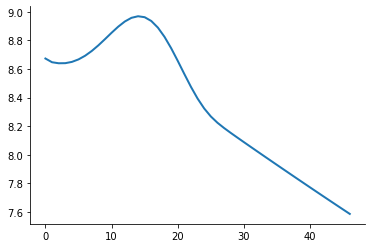

In [82]:
plt.plot(ems_list[0][:, 33])
plt.show()

In [79]:
k_grid[33]

6.6000000000000005

In [262]:
# res_data = dict(
#     y_grid=y_grid,
#     k_grid=k_grid,
#     res_list=res_list,
#     v_list=v_list,
#     ems_list=ems_list,
#     γ3_list=γ3_list,
# )

# pickle.dump(res_data, open('../data/res_10_23_dense', 'wb'))
# res_data = pickle.load(open('../data/res_10_23_dense', 'rb'))
# y_grid = res_data['y_grid']
# k_grid = res_data['k_grid']

In [49]:
loc23 = np.abs(y_grid - 2.4).argmin()
y_grid_cap = y_grid[:loc23+1]
y_grid_cap

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4])

In [50]:
# solve pre jump
loc23 = np.abs(y_grid - 2.4).argmin()
y_grid_cap = y_grid[:loc23+1]
n_y = len(y_grid_cap)
n_k = len(k_grid)
dy = y_grid_cap[1] - y_grid_cap[0]
dk = k_grid[1] - k_grid[0]
(y_mat_cap, k_mat_cap) = np.meshgrid(y_grid_cap, k_grid, indexing = 'ij')
stateSpace = np.hstack([y_mat_cap.reshape(-1,1, order='F'), k_mat_cap.reshape(-1,1,order='F')])


πa_o = np.ones((len(θ_list), n_y, n_k))/len(θ_list)
θ_mat = np.zeros((len(θ_list), n_y, n_k))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
πa = πa_o

πd_o = np.zeros((len(γ3_list), n_y, n_k))
for i in range(len(γ3_list)):
    πd_o[i] = dmg_weight[i]

dΛ = γ1 + γ2*y_mat_cap 
ddΛ = γ2 

ξp = 5
ξa = 0.01
ξw = 100_000

numy_bar = len(y_grid_cap) - 1

r1=1.5
r2=2.5

y_lower = 1.8
intensity = r1*(np.exp(r2/2*(y_mat_cap- y_lower)**2)-1)*(y_mat_cap >= y_lower)


ϕ = np.average(v_list, axis=0, weights=dmg_weight)[:numy_bar+1]
ϕ_dk = derivatives_2d(ϕ, 1, 1, dk)
ems = 0*np.ones(y_mat_cap.shape)
# initial i
a_i = κ*ϕ_dk
b_i = - (1 + α*κ)*ϕ_dk
c_i = α*ϕ_dk - 1
i = (-b_i - np.sqrt(b_i**2 - 4*a_i*c_i))/(2*a_i)
mc = 1/(α - i - α*ϑ_bar*(1 - ems/(np.exp(k_mat_cap)*α*λ_bar))**θ )

episode = 0
lhs_error = 1
πᵈo = dmg_weight

v_average = np.average(np.exp(-1/ξp*v_list), weights=dmg_weight, axis=0)
ϕ_bound = -ξp*np.log(v_average)

ϕ = ϕ_bound[:numy_bar+1]

tol= 1e-7
ϵ = 0.05
max_iter = 4000
vd = -1/δ

while lhs_error > tol: # and episode < max_iter:
    ϕ_old = ϕ.copy()
    ϕ_dy = derivatives_2d(ϕ, 0, 1, dy)
    ϕ_dyy = derivatives_2d(ϕ, 0, 2, dy)
    ϕ_dk = derivatives_2d(ϕ, 1, 1, dk)
    ϕ_dkk = derivatives_2d(ϕ, 1, 2, dk)
    # update control
    # updating controls
    i_new = (1 -mc/ϕ_dk)*(1/κ)
#     update emission
    if θ == 2:
        a = ϕ_dyy*σy**2 + vd*ddΛ*σy**2 - mc*θ*ϑ_bar/(α*λ_bar**2*np.exp(2*k_mat))
        b = mc*θ*ϑ_bar/(λ_bar*np.exp(k_mat)) + ϕ_dy*np.sum(θ_mat*πa, axis=0) \
            + vd*dΛ*np.sum(θ_mat*πa, axis=0)
        ems_new = - b/a
    elif θ == 3:
        a = mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat_cap))/(α**2*λ_bar**2*np.exp(2*k_mat_cap))
        b = - mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat_cap))*2/(α*λ_bar*np.exp(k_mat_cap)) + (ϕ_dyy+ vd*ddΛ)*σy**2 
        c =  mc*ϑ_bar*θ/(λ_bar*np.exp(k_mat_cap)) + (ϕ_dy + vd*dΛ)*np.sum(θ_mat*πa, axis=0)
        Δ = b**2 - 4*a*c
        Δ[Δ < 0] = 0
        root1 = (-b - np.sqrt(Δ))/(2*a)
        root2 = (-b + np.sqrt(Δ))/(2*a)
        if root1.all() > 0:
            ems_new = root1
        else:
            ems_new = root2
    ems_new[ems_new < 0] = 0
    i_new = i_new*0.05 + i*0.95
    ems_new = ems_new*0.05 + ems*0.95
    ratio = (1 - ems_new/(α*λ_bar*np.exp(k_mat_cap)))*( (1 - ems_new/(α*λ_bar*np.exp(k_mat_cap))) > 0 )
#     ratio[ratio > 1] = 1
    consumption = α - i_new - α*ϑ_bar*ratio**θ
#     consumption[consumption < 1e-15] = 1e-15
    mc_new = 1/consumption
    
#     mc_new[mc_new <= 1e-15] = 1e-15
#     mc_new = mc_new*0.05 + mc*0.95
    temp = ϕ_dy + vd*dΛ
    weight = np.array([-1/ξa*temp*ems_new*θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πa = πa_o*np.exp(weight)
    πa[πa<1e-15] = 1e-15
    πa = πa/np.sum(πa, axis=0)
    print("min ems:", np.min(ems_new))
    print("min mc", np.min(mc_new))
    # HJB coefficient
    ϕ_ref = np.zeros((len(γ3_list), n_y, n_k))
    loc23 = np.abs(y_grid - 2.3).argmin()
    for i in range(len(γ3_list)):
        ϕ_ref[i] = v_list[i, loc23]
    g_list = np.exp(1/ξp*(ϕ - ϕ_ref))
    entropy = np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0)
    A =  -δ*np.ones(y_mat_cap.shape) - intensity*np.sum(πd_o*g_list, axis=0)
    B_y = np.sum(θ_mat*πa, axis=0)*ems_new
    B_k = μk + i_new - 0.5*κ*i_new**2 - 0.5*σk**2
    C_yy = 0.5*ems_new**2*σy**2
    C_kk = 0.5*σk**2*np.ones(y_mat_cap.shape)
    D = np.log(consumption) + k_mat_cap + vd*(dΛ*np.sum(θ_mat*πa, axis=0)*ems_new + 0.5*ddΛ*σy**2*ems_new**2) \
        + ξa*entropy + ξp*intensity * np.sum(πd_o*(1 - g_list + g_list*np.log(g_list)), axis=0)\
        + intensity*np.sum(πd_o*(g_list*ϕ_ref), axis=0)
    # PDE solver
    out = PDESolver_2d(stateSpace, A, B_y, B_k, C_yy, C_kk, D, ϕ, ϵ, solverType = 'False Transient')
    out_comp = out[2].reshape(ϕ.shape,order = "F")
    rhs = A*ϕ + B_y*ϕ_dy + B_k*ϕ_dk + C_yy*ϕ_dyy + C_kk*ϕ_dkk  + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((out_comp - ϕ)/ϵ))
    #     if episode % 1 == 0:
    print("Episode {:d}: PDE Error: {:.12f}; ft Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
    episode += 1
    ϕ = out_comp
    ems = ems_new
    mc = mc_new
    i = i_new

solution = dict(ϕ=ϕ, ems=ems, i=i, g_list=g_list)

min ems: 0.0
min mc 46.55098547422798
Episode 0: PDE Error: 0.480082096927; ft Error: 0.467269134258; Iterations: 3; CG Error: 0.000000000001
min ems: 0.0
min mc 44.140841228121765
Episode 1: PDE Error: 0.486290042943; ft Error: 0.473193577259; Iterations: 3; CG Error: 0.000000000003
min ems: 0.0
min mc 42.472767121039
Episode 2: PDE Error: 0.486885846345; ft Error: 0.473714365983; Iterations: 3; CG Error: 0.000000000006
min ems: 0.0
min mc 41.28699459405054
Episode 3: PDE Error: 0.484499894287; ft Error: 0.470950688747; Iterations: 3; CG Error: 0.000000000010
min ems: 0.0
min mc 40.42650854389778
Episode 4: PDE Error: 0.480285734966; ft Error: 0.466050170398; Iterations: 3; CG Error: 0.000000000015
min ems: 0.0
min mc 39.7967947237251
Episode 5: PDE Error: 0.474395937128; ft Error: 0.460227004500; Iterations: 3; CG Error: 0.000000000020
min ems: 0.0
min mc 39.33365079884522
Episode 6: PDE Error: 0.467292175402; ft Error: 0.453328105782; Iterations: 3; CG Error: 0.000000000026
min ems:

min ems: 0.0
min mc 38.60265930312327
Episode 62: PDE Error: 0.134018403459; ft Error: 0.121692126457; Iterations: 5; CG Error: 0.000000000079
min ems: 0.0
min mc 38.603578171837135
Episode 63: PDE Error: 0.133567493500; ft Error: 0.120949790718; Iterations: 5; CG Error: 0.000000000073
min ems: 0.0
min mc 38.60442453711344
Episode 64: PDE Error: 0.133117484089; ft Error: 0.120209830824; Iterations: 5; CG Error: 0.000000000066
min ems: 0.0
min mc 38.605204547658445
Episode 65: PDE Error: 0.132668309610; ft Error: 0.119472238874; Iterations: 5; CG Error: 0.000000000063
min ems: 0.0
min mc 38.6059238124046
Episode 66: PDE Error: 0.132219916210; ft Error: 0.118736997071; Iterations: 5; CG Error: 0.000000000064
min ems: 0.0
min mc 38.606587447972565
Episode 67: PDE Error: 0.131772260375; ft Error: 0.118004082251; Iterations: 5; CG Error: 0.000000000067
min ems: 0.0
min mc 38.607200122180316
Episode 68: PDE Error: 0.131325307641; ft Error: 0.117273478534; Iterations: 5; CG Error: 0.000000000

Episode 123: PDE Error: 0.107947106710; ft Error: 0.082766517844; Iterations: 5; CG Error: 0.000000000069
min ems: 0.0
min mc 38.615370636370244
Episode 124: PDE Error: 0.107549310325; ft Error: 0.082242870910; Iterations: 5; CG Error: 0.000000000076
min ems: 0.0
min mc 38.615391095033765
Episode 125: PDE Error: 0.107152621308; ft Error: 0.081721696199; Iterations: 5; CG Error: 0.000000000076
min ems: 0.0
min mc 38.615410709557246
Episode 126: PDE Error: 0.106757043041; ft Error: 0.081202993210; Iterations: 5; CG Error: 0.000000000073
min ems: 0.0
min mc 38.615429521145224
Episode 127: PDE Error: 0.106362578648; ft Error: 0.080686781480; Iterations: 5; CG Error: 0.000000000068
min ems: 0.0
min mc 38.61544756847888
Episode 128: PDE Error: 0.105969230991; ft Error: 0.080173065257; Iterations: 5; CG Error: 0.000000000064
min ems: 0.0
min mc 38.61546488789925
Episode 129: PDE Error: 0.105577002742; ft Error: 0.079661843514; Iterations: 5; CG Error: 0.000000000061
min ems: 0.0
min mc 38.615

Episode 182: PDE Error: 0.086421285490; ft Error: 0.062233146758; Iterations: 6; CG Error: 0.000000000029
min ems: 0.015282592718895371
min mc 38.615847670413665
Episode 183: PDE Error: 0.086090763456; ft Error: 0.062067964673; Iterations: 6; CG Error: 0.000000000030
min ems: 0.015282609956893305
min mc 38.615849739964
Episode 184: PDE Error: 0.085761379515; ft Error: 0.061902076257; Iterations: 6; CG Error: 0.000000000031
min ems: 0.015282624436709807
min mc 38.61585172946716
Episode 185: PDE Error: 0.085433132984; ft Error: 0.061735495091; Iterations: 6; CG Error: 0.000000000033
min ems: 0.015282636309334297
min mc 38.615853641876356
Episode 186: PDE Error: 0.085106023169; ft Error: 0.061568234999; Iterations: 6; CG Error: 0.000000000034
min ems: 0.01528264571814853
min mc 38.61585548004275
Episode 187: PDE Error: 0.084780049363; ft Error: 0.061400309891; Iterations: 6; CG Error: 0.000000000035
min ems: 0.015282652799307081
min mc 38.61585724671864
Episode 188: PDE Error: 0.084455210

min ems: 0.015281653454390965
min mc 38.615895095844316
Episode 241: PDE Error: 0.068841580785; ft Error: 0.052319304483; Iterations: 6; CG Error: 0.000000000063
min ems: 0.015281627606643046
min mc 38.615895296934916
Episode 242: PDE Error: 0.068576779679; ft Error: 0.052157103059; Iterations: 6; CG Error: 0.000000000063
min ems: 0.015281601825485339
min mc 38.61589549049183
Episode 243: PDE Error: 0.068313064474; ft Error: 0.051994734363; Iterations: 6; CG Error: 0.000000000063
min ems: 0.015281576117721683
min mc 38.61589567683691
Episode 244: PDE Error: 0.068050434138; ft Error: 0.051832205028; Iterations: 6; CG Error: 0.000000000062
min ems: 0.015281550489772075
min mc 38.61589585627882
Episode 245: PDE Error: 0.067788887636; ft Error: 0.051669521634; Iterations: 6; CG Error: 0.000000000062
min ems: 0.015281524947691985
min mc 38.615896029113216
Episode 246: PDE Error: 0.067528423924; ft Error: 0.051506690689; Iterations: 6; CG Error: 0.000000000062
min ems: 0.015281499497190881
m

min ems: 0.015280320341827977
min mc 38.61590043931832
Episode 302: PDE Error: 0.058981805353; ft Error: 0.043170653898; Iterations: 6; CG Error: 0.000000000030
min ems: 0.015280303450084957
min mc 38.615900474898105
Episode 303: PDE Error: 0.058874152450; ft Error: 0.043029150007; Iterations: 6; CG Error: 0.000000000029
min ems: 0.015280286722248874
min mc 38.6159005098386
Episode 304: PDE Error: 0.058766183938; ft Error: 0.042887701120; Iterations: 6; CG Error: 0.000000000029
min ems: 0.01528027015793499
min mc 38.615900544158904
Episode 305: PDE Error: 0.058657904394; ft Error: 0.042746310539; Iterations: 6; CG Error: 0.000000000028
min ems: 0.0152802537567449
min mc 38.61590057787709
Episode 306: PDE Error: 0.058549318386; ft Error: 0.042604981527; Iterations: 6; CG Error: 0.000000000028
min ems: 0.015280237518267317
min mc 38.6159006110105
Episode 307: PDE Error: 0.058440430463; ft Error: 0.042463717313; Iterations: 6; CG Error: 0.000000000027
min ems: 0.015280221442078887
min mc 

Episode 357: PDE Error: 0.053051309639; ft Error: 0.039050497019; Iterations: 5; CG Error: 0.000000000068
min ems: 0.015279613297395007
min mc 38.61590176713924
Episode 358: PDE Error: 0.052949270183; ft Error: 0.038984774615; Iterations: 5; CG Error: 0.000000000067
min ems: 0.015279604805899466
min mc 38.61590178220995
Episode 359: PDE Error: 0.052847087289; ft Error: 0.038918601301; Iterations: 5; CG Error: 0.000000000066
min ems: 0.015279596448758408
min mc 38.61590179705878
Episode 360: PDE Error: 0.052744764054; ft Error: 0.038851981327; Iterations: 5; CG Error: 0.000000000064
min ems: 0.0152795882254262
min mc 38.615901811688566
Episode 361: PDE Error: 0.052642303566; ft Error: 0.038784918924; Iterations: 5; CG Error: 0.000000000063
min ems: 0.015279580135358623
min mc 38.61590182610208
Episode 362: PDE Error: 0.052539708903; ft Error: 0.038717418317; Iterations: 5; CG Error: 0.000000000062
min ems: 0.015279572178012948
min mc 38.61590184030207
Episode 363: PDE Error: 0.052436983

Episode 417: PDE Error: 0.046776058111; ft Error: 0.035313266318; Iterations: 5; CG Error: 0.000000000024
min ems: 0.015279084486642608
min mc 38.61590236037186
Episode 418: PDE Error: 0.046670541853; ft Error: 0.035250743712; Iterations: 5; CG Error: 0.000000000024
min ems: 0.015279040534716608
min mc 38.61590236615446
Episode 419: PDE Error: 0.046565049507; ft Error: 0.035187931356; Iterations: 5; CG Error: 0.000000000023
min ems: 0.015278996624745272
min mc 38.615902371838935
Episode 420: PDE Error: 0.046459583527; ft Error: 0.035124832116; Iterations: 5; CG Error: 0.000000000023
min ems: 0.01527895275668415
min mc 38.61590237742682
Episode 421: PDE Error: 0.046354146353; ft Error: 0.035061448855; Iterations: 5; CG Error: 0.000000000022
min ems: 0.01527890893048877
min mc 38.615902382919614
Episode 422: PDE Error: 0.046248740415; ft Error: 0.034997784422; Iterations: 5; CG Error: 0.000000000022
min ems: 0.015278865146114762
min mc 38.61590238831872
Episode 423: PDE Error: 0.04614336

min ems: 0.015276561618459597
min mc 38.61590257476554
Episode 477: PDE Error: 0.042889776485; ft Error: 0.031830990160; Iterations: 4; CG Error: 0.000000000066
min ems: 0.01527652006464973
min mc 38.6159025767936
Episode 478: PDE Error: 0.042889982082; ft Error: 0.031776071396; Iterations: 4; CG Error: 0.000000000065
min ems: 0.01527647855025767
min mc 38.61590257878519
Episode 479: PDE Error: 0.042890171231; ft Error: 0.031720956055; Iterations: 4; CG Error: 0.000000000064
min ems: 0.015276437075244339
min mc 38.61590258074096
Episode 480: PDE Error: 0.042890344436; ft Error: 0.031665646078; Iterations: 4; CG Error: 0.000000000063
min ems: 0.015276395639570587
min mc 38.61590258266158
Episode 481: PDE Error: 0.042890502188; ft Error: 0.031610143395; Iterations: 4; CG Error: 0.000000000063
min ems: 0.015276354243197253
min mc 38.615902584547655
Episode 482: PDE Error: 0.042890644969; ft Error: 0.031554449934; Iterations: 4; CG Error: 0.000000000062
min ems: 0.01527631288608508
min mc 

Episode 531: PDE Error: 0.042886807893; ft Error: 0.028944683003; Iterations: 4; CG Error: 0.000000000036
min ems: 0.015274333666038907
min mc 38.61590264595665
Episode 532: PDE Error: 0.042886619789; ft Error: 0.028899700020; Iterations: 4; CG Error: 0.000000000035
min ems: 0.01527429422214002
min mc 38.615902646705294
Episode 533: PDE Error: 0.042886430393; ft Error: 0.028854566503; Iterations: 4; CG Error: 0.000000000035
min ems: 0.015274254815523384
min mc 38.61590264744063
Episode 534: PDE Error: 0.042886239824; ft Error: 0.028809283777; Iterations: 4; CG Error: 0.000000000035
min ems: 0.015274215446151321
min mc 38.615902648162916
Episode 535: PDE Error: 0.042886048196; ft Error: 0.028763853170; Iterations: 4; CG Error: 0.000000000034
min ems: 0.015274176113986198
min mc 38.6159026488724
Episode 536: PDE Error: 0.042885855622; ft Error: 0.028718276001; Iterations: 4; CG Error: 0.000000000034
min ems: 0.015274136818990442
min mc 38.6159026495693
Episode 537: PDE Error: 0.042885662

Episode 590: PDE Error: 0.042876031725; ft Error: 0.026674476118; Iterations: 4; CG Error: 0.000000000019
min ems: 0.015272069066517594
min mc 38.615902673617036
Episode 591: PDE Error: 0.042875881553; ft Error: 0.026636833260; Iterations: 4; CG Error: 0.000000000019
min ems: 0.01527203175962365
min mc 38.61590267388359
Episode 592: PDE Error: 0.042875732890; ft Error: 0.026598975902; Iterations: 4; CG Error: 0.000000000019
min ems: 0.015271994487884554
min mc 38.615902674145666
Episode 593: PDE Error: 0.042875585740; ft Error: 0.026560905575; Iterations: 4; CG Error: 0.000000000019
min ems: 0.015271957251265931
min mc 38.61590267440332
Episode 594: PDE Error: 0.042875440104; ft Error: 0.026522623817; Iterations: 4; CG Error: 0.000000000019
min ems: 0.015271920049733422
min mc 38.61590267465664
Episode 595: PDE Error: 0.042875295985; ft Error: 0.026484132155; Iterations: 4; CG Error: 0.000000000018
min ems: 0.015271882883252715
min mc 38.6159026749057
Episode 596: PDE Error: 0.04287515

min ems: 0.015269962338016425
min mc 38.61590268361327
Episode 649: PDE Error: 0.042869637199; ft Error: 0.024842665596; Iterations: 3; CG Error: 0.000000000097
min ems: 0.015269927014750795
min mc 38.61590268371614
Episode 650: PDE Error: 0.042869567192; ft Error: 0.024812796077; Iterations: 3; CG Error: 0.000000000096
min ems: 0.015269891724708828
min mc 38.61590268381738
Episode 651: PDE Error: 0.042869498246; ft Error: 0.024782749035; Iterations: 3; CG Error: 0.000000000095
min ems: 0.015269856467858925
min mc 38.61590268391703
Episode 652: PDE Error: 0.042869430349; ft Error: 0.024752525608; Iterations: 3; CG Error: 0.000000000094
min ems: 0.015269821244169549
min mc 38.61590268401507
Episode 653: PDE Error: 0.042869363490; ft Error: 0.024722126916; Iterations: 3; CG Error: 0.000000000093
min ems: 0.015269786053609288
min mc 38.61590268411157
Episode 654: PDE Error: 0.042869297656; ft Error: 0.024691554081; Iterations: 3; CG Error: 0.000000000092
min ems: 0.015269750896146834
min 

min ems: 0.015267934114026608
min mc 38.61590268760639
Episode 708: PDE Error: 0.042866959221; ft Error: 0.022988884527; Iterations: 3; CG Error: 0.000000000055
min ems: 0.015267900698912847
min mc 38.61590268764759
Episode 709: PDE Error: 0.042866933316; ft Error: 0.022966662884; Iterations: 3; CG Error: 0.000000000054
min ems: 0.015267867315255652
min mc 38.615902687688184
Episode 710: PDE Error: 0.042866907880; ft Error: 0.022944291526; Iterations: 3; CG Error: 0.000000000054
min ems: 0.015267833963026356
min mc 38.61590268772818
Episode 711: PDE Error: 0.042866882906; ft Error: 0.022921771194; Iterations: 3; CG Error: 0.000000000053
min ems: 0.01526780064219636
min mc 38.61590268776758
Episode 712: PDE Error: 0.042866858387; ft Error: 0.022899102639; Iterations: 3; CG Error: 0.000000000053
min ems: 0.015267767352737062
min mc 38.61590268780637
Episode 713: PDE Error: 0.042866834314; ft Error: 0.022876286607; Iterations: 3; CG Error: 0.000000000052
min ems: 0.01526773409461991
min m

min ems: 0.015265952345943834
min mc 38.61590268927302
Episode 769: PDE Error: 0.042866014039; ft Error: 0.021386475230; Iterations: 3; CG Error: 0.000000000031
min ems: 0.015265920798594361
min mc 38.615902689289804
Episode 770: PDE Error: 0.042866006116; ft Error: 0.021356501372; Iterations: 3; CG Error: 0.000000000031
min ems: 0.01526588928102199
min mc 38.6159026893063
Episode 771: PDE Error: 0.042865998353; ft Error: 0.021326423931; Iterations: 3; CG Error: 0.000000000031
min ems: 0.015265857793200324
min mc 38.615902689322596
Episode 772: PDE Error: 0.042865990747; ft Error: 0.021296243667; Iterations: 3; CG Error: 0.000000000031
min ems: 0.015265826335102964
min mc 38.61590268933865
Episode 773: PDE Error: 0.042865983296; ft Error: 0.021265961335; Iterations: 3; CG Error: 0.000000000030
min ems: 0.01526579490670363
min mc 38.61590268935445
Episode 774: PDE Error: 0.042865975996; ft Error: 0.021235577688; Iterations: 3; CG Error: 0.000000000030
min ems: 0.015265763507976014
min m

min ems: 0.015264141158756479
min mc 38.61590268994605
Episode 828: PDE Error: 0.042865742560; ft Error: 0.019952991502; Iterations: 3; CG Error: 0.000000000019
min ems: 0.015264111324226434
min mc 38.615902689953266
Episode 829: PDE Error: 0.042865740286; ft Error: 0.019930979423; Iterations: 3; CG Error: 0.000000000019
min ems: 0.015264081517975502
min mc 38.615902689960386
Episode 830: PDE Error: 0.042865738060; ft Error: 0.019908871426; Iterations: 3; CG Error: 0.000000000019
min ems: 0.015264051739979294
min mc 38.61590268996741
Episode 831: PDE Error: 0.042865735882; ft Error: 0.019886668030; Iterations: 3; CG Error: 0.000000000018
min ems: 0.015264021990213456
min mc 38.61590268997431
Episode 832: PDE Error: 0.042865733751; ft Error: 0.019864369768; Iterations: 3; CG Error: 0.000000000018
min ems: 0.015263992268653699
min mc 38.61590268998113
Episode 833: PDE Error: 0.042865731666; ft Error: 0.019841977175; Iterations: 3; CG Error: 0.000000000018
min ems: 0.01526396257527575
min

Episode 889: PDE Error: 0.042865664744; ft Error: 0.018594385867; Iterations: 3; CG Error: 0.000000000012
min ems: 0.01526234398991949
min mc 38.6159026902495
Episode 890: PDE Error: 0.042865664132; ft Error: 0.018578828809; Iterations: 3; CG Error: 0.000000000011
min ems: 0.015262315863822457
min mc 38.6159026902525
Episode 891: PDE Error: 0.042865663533; ft Error: 0.018563154903; Iterations: 3; CG Error: 0.000000000011
min ems: 0.01526228776455391
min mc 38.61590269025548
Episode 892: PDE Error: 0.042865662946; ft Error: 0.018547364647; Iterations: 3; CG Error: 0.000000000011
min ems: 0.01526225969209143
min mc 38.61590269025846
Episode 893: PDE Error: 0.042865662372; ft Error: 0.018531458533; Iterations: 3; CG Error: 0.000000000011
min ems: 0.015262231646412614
min mc 38.61590269026138
Episode 894: PDE Error: 0.042865661809; ft Error: 0.018515437063; Iterations: 3; CG Error: 0.000000000011
min ems: 0.015262203627495103
min mc 38.615902690264214
Episode 895: PDE Error: 0.042865661257

Episode 947: PDE Error: 0.042865643530; ft Error: 0.017514589309; Iterations: 3; CG Error: 0.000000000007
min ems: 0.01526075634464619
min mc 38.615902690369126
Episode 948: PDE Error: 0.042865643330; ft Error: 0.017493100146; Iterations: 3; CG Error: 0.000000000007
min ems: 0.015260729738457022
min mc 38.615902690370426
Episode 949: PDE Error: 0.042865643132; ft Error: 0.017471524151; Iterations: 3; CG Error: 0.000000000007
min ems: 0.015260703157844654
min mc 38.61590269037171
Episode 950: PDE Error: 0.042865642938; ft Error: 0.017449861863; Iterations: 3; CG Error: 0.000000000007
min ems: 0.015260676602788351
min mc 38.61590269037297
Episode 951: PDE Error: 0.042865642748; ft Error: 0.017428113814; Iterations: 3; CG Error: 0.000000000007
min ems: 0.015260650073267374
min mc 38.61590269037424
Episode 952: PDE Error: 0.042865642560; ft Error: 0.017406280531; Iterations: 3; CG Error: 0.000000000007
min ems: 0.015260623569261072
min mc 38.615902690375485
Episode 953: PDE Error: 0.042865

Episode 1007: PDE Error: 0.042865635729; ft Error: 0.016537525366; Iterations: 2; CG Error: 0.000000000087
min ems: 0.015259204652870869
min mc 38.61590269042367
Episode 1008: PDE Error: 0.042865635647; ft Error: 0.016523080847; Iterations: 2; CG Error: 0.000000000087
min ems: 0.015259179553115693
min mc 38.615902690424186
Episode 1009: PDE Error: 0.042865635567; ft Error: 0.016508551631; Iterations: 2; CG Error: 0.000000000086
min ems: 0.015259154477867012
min mc 38.61590269042467
Episode 1010: PDE Error: 0.042865635488; ft Error: 0.016493938078; Iterations: 2; CG Error: 0.000000000085
min ems: 0.015259129427095331
min mc 38.61590269042519
Episode 1011: PDE Error: 0.042865635409; ft Error: 0.016479240555; Iterations: 2; CG Error: 0.000000000085
min ems: 0.015259104400771712
min mc 38.61590269042566
Episode 1012: PDE Error: 0.042865635331; ft Error: 0.016464459428; Iterations: 2; CG Error: 0.000000000084
min ems: 0.015259079398867751
min mc 38.615902690426175
Episode 1013: PDE Error: 0

min mc 38.615902690446596
Episode 1067: PDE Error: 0.042865632059; ft Error: 0.015533641931; Iterations: 2; CG Error: 0.000000000061
min ems: 0.01525774121268913
min mc 38.615902690446845
Episode 1068: PDE Error: 0.042865632014; ft Error: 0.015514775992; Iterations: 2; CG Error: 0.000000000061
min ems: 0.015257717542343287
min mc 38.61590269044706
Episode 1069: PDE Error: 0.042865631970; ft Error: 0.015495847938; Iterations: 2; CG Error: 0.000000000061
min ems: 0.015257693895223107
min mc 38.615902690447285
Episode 1070: PDE Error: 0.042865631925; ft Error: 0.015476858149; Iterations: 2; CG Error: 0.000000000060
min ems: 0.01525767027131087
min mc 38.61590269044749
Episode 1071: PDE Error: 0.042865631882; ft Error: 0.015457807009; Iterations: 2; CG Error: 0.000000000060
min ems: 0.015257646670588884
min mc 38.6159026904477
Episode 1072: PDE Error: 0.042865631839; ft Error: 0.015438694899; Iterations: 2; CG Error: 0.000000000060
min ems: 0.015257623093039534
min mc 38.61590269044789
Epi

min ems: 0.015256406193192438
min mc 38.61590269045605
Episode 1126: PDE Error: 0.042865630022; ft Error: 0.014717738734; Iterations: 2; CG Error: 0.000000000046
min ems: 0.01525638384170591
min mc 38.61590269045614
Episode 1127: PDE Error: 0.042865629997; ft Error: 0.014705243590; Iterations: 2; CG Error: 0.000000000046
min ems: 0.015256361512470265
min mc 38.615902690456196
Episode 1128: PDE Error: 0.042865629972; ft Error: 0.014692684614; Iterations: 2; CG Error: 0.000000000045
min ems: 0.015256339205469425
min mc 38.61590269045627
Episode 1129: PDE Error: 0.042865629947; ft Error: 0.014680062073; Iterations: 2; CG Error: 0.000000000045
min ems: 0.01525631692068733
min mc 38.61590269045634
Episode 1130: PDE Error: 0.042865629922; ft Error: 0.014667376230; Iterations: 2; CG Error: 0.000000000045
min ems: 0.015256294658107947
min mc 38.61590269045641
Episode 1131: PDE Error: 0.042865629898; ft Error: 0.014654627346; Iterations: 2; CG Error: 0.000000000045
min ems: 0.01525627241771528


Episode 1187: PDE Error: 0.042865628860; ft Error: 0.013848369705; Iterations: 2; CG Error: 0.000000000035
min ems: 0.015255061880934298
min mc 38.61590269045913
Episode 1188: PDE Error: 0.042865628846; ft Error: 0.013832473549; Iterations: 2; CG Error: 0.000000000035
min ems: 0.01525504087937683
min mc 38.61590269045913
Episode 1189: PDE Error: 0.042865628833; ft Error: 0.013816530111; Iterations: 2; CG Error: 0.000000000035
min ems: 0.01525501989911191
min mc 38.61590269045915
Episode 1190: PDE Error: 0.042865628820; ft Error: 0.013800539662; Iterations: 2; CG Error: 0.000000000035
min ems: 0.015254998940124703
min mc 38.61590269045916
Episode 1191: PDE Error: 0.042865628806; ft Error: 0.013784502484; Iterations: 2; CG Error: 0.000000000035
min ems: 0.015254978002400391
min mc 38.61590269045916
Episode 1192: PDE Error: 0.042865628793; ft Error: 0.013768418844; Iterations: 2; CG Error: 0.000000000035
min ems: 0.01525495708592416
min mc 38.61590269045916
Episode 1193: PDE Error: 0.0428

Episode 1249: PDE Error: 0.042865628247; ft Error: 0.013086356787; Iterations: 2; CG Error: 0.000000000028
min ems: 0.015253799498126734
min mc 38.61590269046101
Episode 1250: PDE Error: 0.042865628240; ft Error: 0.013075874302; Iterations: 2; CG Error: 0.000000000028
min ems: 0.015253779789372599
min mc 38.61590269046102
Episode 1251: PDE Error: 0.042865628234; ft Error: 0.013065342483; Iterations: 2; CG Error: 0.000000000028
min ems: 0.01525376010102705
min mc 38.615902690461056
Episode 1252: PDE Error: 0.042865628227; ft Error: 0.013054761523; Iterations: 2; CG Error: 0.000000000028
min ems: 0.015253740433076422
min mc 38.61590269046109
Episode 1253: PDE Error: 0.042865628220; ft Error: 0.013044131606; Iterations: 2; CG Error: 0.000000000028
min ems: 0.015253720785507068
min mc 38.61590269046108
Episode 1254: PDE Error: 0.042865628214; ft Error: 0.013033452933; Iterations: 2; CG Error: 0.000000000027
min ems: 0.015253701158305358
min mc 38.61590269046108
Episode 1255: PDE Error: 0.0

Episode 1310: PDE Error: 0.042865627948; ft Error: 0.012363608499; Iterations: 2; CG Error: 0.000000000023
min ems: 0.015252634129381054
min mc 38.61590269046171
Episode 1311: PDE Error: 0.042865627945; ft Error: 0.012350472417; Iterations: 2; CG Error: 0.000000000022
min ems: 0.015252615641188957
min mc 38.615902690461695
Episode 1312: PDE Error: 0.042865627942; ft Error: 0.012337298953; Iterations: 2; CG Error: 0.000000000022
min ems: 0.015252597172604658
min mc 38.61590269046169
Episode 1313: PDE Error: 0.042865627939; ft Error: 0.012324088309; Iterations: 2; CG Error: 0.000000000022
min ems: 0.01525257872361559
min mc 38.615902690461716
Episode 1314: PDE Error: 0.042865627935; ft Error: 0.012310840683; Iterations: 2; CG Error: 0.000000000022
min ems: 0.015252560294209195
min mc 38.6159026904618
Episode 1315: PDE Error: 0.042865627932; ft Error: 0.012297556275; Iterations: 2; CG Error: 0.000000000022
min ems: 0.015252541884372925
min mc 38.615902690461915
Episode 1316: PDE Error: 0.

min ems: 0.015251576473956904
min mc 38.61590269046271
Episode 1370: PDE Error: 0.042865627807; ft Error: 0.011681026052; Iterations: 2; CG Error: 0.000000000018
min ems: 0.015251559121663748
min mc 38.61590269046271
Episode 1371: PDE Error: 0.042865627805; ft Error: 0.011672641981; Iterations: 2; CG Error: 0.000000000018
min ems: 0.0152515417882656
min mc 38.6159026904627
Episode 1372: PDE Error: 0.042865627804; ft Error: 0.011664218157; Iterations: 2; CG Error: 0.000000000018
min ems: 0.015251524473750885
min mc 38.6159026904627
Episode 1373: PDE Error: 0.042865627802; ft Error: 0.011655754712; Iterations: 2; CG Error: 0.000000000018
min ems: 0.015251507178108047
min mc 38.615902690462704
Episode 1374: PDE Error: 0.042865627800; ft Error: 0.011647251786; Iterations: 2; CG Error: 0.000000000018
min ems: 0.015251489901325539
min mc 38.61590269046273
Episode 1375: PDE Error: 0.042865627799; ft Error: 0.011638709514; Iterations: 2; CG Error: 0.000000000018
min ems: 0.01525147264339184
mi

Episode 1429: PDE Error: 0.042865627739; ft Error: 0.011122864499; Iterations: 2; CG Error: 0.000000000015
min ems: 0.015250568392363384
min mc 38.61590269046296
Episode 1430: PDE Error: 0.042865627739; ft Error: 0.011112374148; Iterations: 2; CG Error: 0.000000000015
min ems: 0.015250552153838585
min mc 38.61590269046298
Episode 1431: PDE Error: 0.042865627738; ft Error: 0.011101852376; Iterations: 2; CG Error: 0.000000000015
min ems: 0.01525053593354294
min mc 38.61590269046296
Episode 1432: PDE Error: 0.042865627737; ft Error: 0.011091299333; Iterations: 2; CG Error: 0.000000000015
min ems: 0.015250519731465833
min mc 38.61590269046296
Episode 1433: PDE Error: 0.042865627736; ft Error: 0.011080715160; Iterations: 2; CG Error: 0.000000000015
min ems: 0.015250503547596678
min mc 38.61590269046294
Episode 1434: PDE Error: 0.042865627735; ft Error: 0.011070100006; Iterations: 2; CG Error: 0.000000000015
min ems: 0.015250487381924901
min mc 38.61590269046293
Episode 1435: PDE Error: 0.04

Episode 1489: PDE Error: 0.042865627707; ft Error: 0.010544245494; Iterations: 2; CG Error: 0.000000000013
min ems: 0.015249625990918435
min mc 38.615902690463166
Episode 1490: PDE Error: 0.042865627707; ft Error: 0.010534167016; Iterations: 2; CG Error: 0.000000000013
min ems: 0.015249610827889684
min mc 38.61590269046313
Episode 1491: PDE Error: 0.042865627707; ft Error: 0.010524055034; Iterations: 2; CG Error: 0.000000000013
min ems: 0.015249595682480629
min mc 38.615902690463095
Episode 1492: PDE Error: 0.042865627706; ft Error: 0.010513909712; Iterations: 2; CG Error: 0.000000000012
min ems: 0.015249580554681584
min mc 38.61590269046305
Episode 1493: PDE Error: 0.042865627706; ft Error: 0.010503731201; Iterations: 2; CG Error: 0.000000000012
min ems: 0.01524956544448285
min mc 38.61590269046304
Episode 1494: PDE Error: 0.042865627706; ft Error: 0.010493519659; Iterations: 2; CG Error: 0.000000000012
min ems: 0.01524955035187476
min mc 38.615902690463
Episode 1495: PDE Error: 0.042

min ems: 0.015248732948863322
min mc 38.61590269046255
Episode 1551: PDE Error: 0.042865627693; ft Error: 0.009996028557; Iterations: 2; CG Error: 0.000000000010
min ems: 0.015248718843416664
min mc 38.61590269046256
Episode 1552: PDE Error: 0.042865627693; ft Error: 0.009987755722; Iterations: 2; CG Error: 0.000000000010
min ems: 0.015248704755024788
min mc 38.61590269046257
Episode 1553: PDE Error: 0.042865627693; ft Error: 0.009979456186; Iterations: 2; CG Error: 0.000000000010
min ems: 0.01524869068367892
min mc 38.615902690462576
Episode 1554: PDE Error: 0.042865627693; ft Error: 0.009971130060; Iterations: 2; CG Error: 0.000000000010
min ems: 0.01524867662937024
min mc 38.615902690462576
Episode 1555: PDE Error: 0.042865627693; ft Error: 0.009962777444; Iterations: 2; CG Error: 0.000000000010
min ems: 0.015248662592089957
min mc 38.61590269046254
Episode 1556: PDE Error: 0.042865627692; ft Error: 0.009954398445; Iterations: 2; CG Error: 0.000000000010
min ems: 0.01524864857182929

min ems: 0.015247916514104707
min mc 38.6159026904621
Episode 1611: PDE Error: 0.042865627687; ft Error: 0.009539607262; Iterations: 2; CG Error: 0.000000000009
min ems: 0.015247903416813004
min mc 38.61590269046215
Episode 1612: PDE Error: 0.042865627687; ft Error: 0.009531724398; Iterations: 2; CG Error: 0.000000000009
min ems: 0.015247890336071424
min mc 38.615902690462164
Episode 1613: PDE Error: 0.042865627687; ft Error: 0.009523812737; Iterations: 2; CG Error: 0.000000000009
min ems: 0.015247877271871988
min mc 38.61590269046218
Episode 1614: PDE Error: 0.042865627687; ft Error: 0.009515872387; Iterations: 2; CG Error: 0.000000000009
min ems: 0.015247864224206698
min mc 38.615902690462164
Episode 1615: PDE Error: 0.042865627687; ft Error: 0.009507903466; Iterations: 2; CG Error: 0.000000000008
min ems: 0.015247851193067572
min mc 38.61590269046216
Episode 1616: PDE Error: 0.042865627687; ft Error: 0.009499906083; Iterations: 2; CG Error: 0.000000000008
min ems: 0.0152478381784466

min ems: 0.015247159703009766
min mc 38.61590269046198
Episode 1671: PDE Error: 0.042865627685; ft Error: 0.009019618811; Iterations: 2; CG Error: 0.000000000007
min ems: 0.015247147585015572
min mc 38.61590269046199
Episode 1672: PDE Error: 0.042865627684; ft Error: 0.009010213316; Iterations: 2; CG Error: 0.000000000007
min ems: 0.0152471354831146
min mc 38.615902690462015
Episode 1673: PDE Error: 0.042865627684; ft Error: 0.009000786015; Iterations: 2; CG Error: 0.000000000007
min ems: 0.015247123397299653
min mc 38.615902690462036
Episode 1674: PDE Error: 0.042865627684; ft Error: 0.008991337020; Iterations: 2; CG Error: 0.000000000007
min ems: 0.015247111327563513
min mc 38.61590269046203
Episode 1675: PDE Error: 0.042865627684; ft Error: 0.008981866451; Iterations: 2; CG Error: 0.000000000007
min ems: 0.015247099273898996
min mc 38.61590269046203
Episode 1676: PDE Error: 0.042865627684; ft Error: 0.008972374426; Iterations: 2; CG Error: 0.000000000007
min ems: 0.01524708723629888

Episode 1731: PDE Error: 0.042865627684; ft Error: 0.008633838720; Iterations: 2; CG Error: 0.000000000006
min ems: 0.015246449702438427
min mc 38.61590269046193
Episode 1732: PDE Error: 0.042865627684; ft Error: 0.008627897929; Iterations: 2; CG Error: 0.000000000006
min ems: 0.015246438553354988
min mc 38.61590269046193
Episode 1733: PDE Error: 0.042865627684; ft Error: 0.008621931936; Iterations: 2; CG Error: 0.000000000006
min ems: 0.015246427419946567
min mc 38.61590269046193
Episode 1734: PDE Error: 0.042865627684; ft Error: 0.008615940828; Iterations: 2; CG Error: 0.000000000006
min ems: 0.015246416302206673
min mc 38.61590269046191
Episode 1735: PDE Error: 0.042865627684; ft Error: 0.008609924683; Iterations: 2; CG Error: 0.000000000006
min ems: 0.015246405200128833
min mc 38.615902690461844
Episode 1736: PDE Error: 0.042865627684; ft Error: 0.008603883585; Iterations: 2; CG Error: 0.000000000006
min ems: 0.015246394113706596
min mc 38.61590269046179
Episode 1737: PDE Error: 0.

min ems: 0.015245808286060224
min mc 38.615902690461795
Episode 1792: PDE Error: 0.042865627684; ft Error: 0.008228363880; Iterations: 2; CG Error: 0.000000000005
min ems: 0.015245798066401346
min mc 38.61590269046179
Episode 1793: PDE Error: 0.042865627684; ft Error: 0.008221040772; Iterations: 2; CG Error: 0.000000000005
min ems: 0.015245787862049002
min mc 38.61590269046179
Episode 1794: PDE Error: 0.042865627684; ft Error: 0.008213697673; Iterations: 2; CG Error: 0.000000000005
min ems: 0.015245777672997398
min mc 38.61590269046181
Episode 1795: PDE Error: 0.042865627684; ft Error: 0.008206334674; Iterations: 2; CG Error: 0.000000000005
min ems: 0.01524576749924075
min mc 38.61590269046179
Episode 1796: PDE Error: 0.042865627684; ft Error: 0.008198951861; Iterations: 2; CG Error: 0.000000000005
min ems: 0.015245757340773268
min mc 38.61590269046176
Episode 1797: PDE Error: 0.042865627684; ft Error: 0.008191549324; Iterations: 2; CG Error: 0.000000000005
min ems: 0.01524574719758922

min ems: 0.015245222006106129
min mc 38.61590269046158
Episode 1852: PDE Error: 0.042865627683; ft Error: 0.007788872383; Iterations: 2; CG Error: 0.000000000004
min ems: 0.015245212694954532
min mc 38.61590269046156
Episode 1853: PDE Error: 0.042865627683; ft Error: 0.007784543075; Iterations: 2; CG Error: 0.000000000004
min ems: 0.015245203398780941
min mc 38.61590269046152
Episode 1854: PDE Error: 0.042865627683; ft Error: 0.007780191763; Iterations: 2; CG Error: 0.000000000004
min ems: 0.015245194117580211
min mc 38.615902690461496
Episode 1855: PDE Error: 0.042865627683; ft Error: 0.007775818502; Iterations: 2; CG Error: 0.000000000004
min ems: 0.015245184851347203
min mc 38.615902690461475
Episode 1856: PDE Error: 0.042865627683; ft Error: 0.007771423354; Iterations: 2; CG Error: 0.000000000004
min ems: 0.015245175600076774
min mc 38.615902690461475
Episode 1857: PDE Error: 0.042865627683; ft Error: 0.007767006377; Iterations: 2; CG Error: 0.000000000004
min ems: 0.01524516636376

Episode 1908: PDE Error: 0.042865627683; ft Error: 0.007514216753; Iterations: 2; CG Error: 0.000000000004
min ems: 0.015244715028677759
min mc 38.6159026904617
Episode 1909: PDE Error: 0.042865627683; ft Error: 0.007508748874; Iterations: 2; CG Error: 0.000000000004
min ems: 0.015244706563349383
min mc 38.6159026904617
Episode 1910: PDE Error: 0.042865627683; ft Error: 0.007503262448; Iterations: 2; CG Error: 0.000000000004
min ems: 0.015244698112721571
min mc 38.61590269046168
Episode 1911: PDE Error: 0.042865627683; ft Error: 0.007497757540; Iterations: 2; CG Error: 0.000000000004
min ems: 0.01524468967678974
min mc 38.61590269046168
Episode 1912: PDE Error: 0.042865627683; ft Error: 0.007492234212; Iterations: 2; CG Error: 0.000000000004
min ems: 0.015244681255549314
min mc 38.61590269046166
Episode 1913: PDE Error: 0.042865627683; ft Error: 0.007486692530; Iterations: 2; CG Error: 0.000000000004
min ems: 0.015244672848995756
min mc 38.61590269046165
Episode 1914: PDE Error: 0.0428

Episode 1964: PDE Error: 0.042865627684; ft Error: 0.007181250175; Iterations: 2; CG Error: 0.000000000003
min ems: 0.01524426348570705
min mc 38.61590269046158
Episode 1965: PDE Error: 0.042865627684; ft Error: 0.007174843815; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015244255836820762
min mc 38.61590269046158
Episode 1966: PDE Error: 0.042865627684; ft Error: 0.007168422568; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015244248202393111
min mc 38.61590269046158
Episode 1967: PDE Error: 0.042865627683; ft Error: 0.007161986503; Iterations: 2; CG Error: 0.000000000003
min ems: 0.01524424058242005
min mc 38.61590269046158
Episode 1968: PDE Error: 0.042865627683; ft Error: 0.007155535685; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015244232976897521
min mc 38.61590269046158
Episode 1969: PDE Error: 0.042865627683; ft Error: 0.007149070179; Iterations: 2; CG Error: 0.000000000003
min ems: 0.01524422538582148
min mc 38.61590269046158
Episode 1970: PDE Error: 0.0428

Episode 2022: PDE Error: 0.042865627683; ft Error: 0.006835442859; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015243843628987189
min mc 38.6159026904616
Episode 2023: PDE Error: 0.042865627683; ft Error: 0.006831556994; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015243836812266522
min mc 38.61590269046161
Episode 2024: PDE Error: 0.042865627683; ft Error: 0.006827654109; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015243830009783592
min mc 38.61590269046161
Episode 2025: PDE Error: 0.042865627683; ft Error: 0.006823734245; Iterations: 2; CG Error: 0.000000000003
min ems: 0.01524382322153486
min mc 38.61590269046159
Episode 2026: PDE Error: 0.042865627683; ft Error: 0.006819797451; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015243816447516753
min mc 38.61590269046159
Episode 2027: PDE Error: 0.042865627683; ft Error: 0.006815843773; Iterations: 2; CG Error: 0.000000000003
min ems: 0.015243809687725735
min mc 38.61590269046159
Episode 2028: PDE Error: 0.042

Episode 2084: PDE Error: 0.042865627683; ft Error: 0.006564105194; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015243447785792189
min mc 38.61590269046195
Episode 2085: PDE Error: 0.042865627683; ft Error: 0.006559253330; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015243441845385723
min mc 38.615902690461944
Episode 2086: PDE Error: 0.042865627683; ft Error: 0.006554387414; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015243435919011403
min mc 38.615902690461944
Episode 2087: PDE Error: 0.042865627683; ft Error: 0.006549507493; Iterations: 2; CG Error: 0.000000000002
min ems: 0.01524343000666616
min mc 38.61590269046196
Episode 2088: PDE Error: 0.042865627683; ft Error: 0.006544613618; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015243424108346915
min mc 38.61590269046196
Episode 2089: PDE Error: 0.042865627683; ft Error: 0.006539705836; Iterations: 2; CG Error: 0.000000000002
min ems: 0.01524341822405061
min mc 38.61590269046196
Episode 2090: PDE Error: 0.0

min ems: 0.015243110992927454
min mc 38.61590269046193
Episode 2146: PDE Error: 0.042865627683; ft Error: 0.006238601397; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015243105903113053
min mc 38.615902690461944
Episode 2147: PDE Error: 0.042865627683; ft Error: 0.006232972769; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015243100827156218
min mc 38.61590269046194
Episode 2148: PDE Error: 0.042865627683; ft Error: 0.006227333198; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015243095765054298
min mc 38.61590269046194
Episode 2149: PDE Error: 0.042865627683; ft Error: 0.006221682733; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015243090716804648
min mc 38.61590269046193
Episode 2150: PDE Error: 0.042865627683; ft Error: 0.006216021430; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015243085682404636
min mc 38.61590269046193
Episode 2151: PDE Error: 0.042865627683; ft Error: 0.006210349333; Iterations: 2; CG Error: 0.000000000002
min ems: 0.0152430806618516

min ems: 0.015242834320872875
min mc 38.61590269046173
Episode 2205: PDE Error: 0.042865627683; ft Error: 0.005967534006; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015242830044323271
min mc 38.61590269046171
Episode 2206: PDE Error: 0.042865627683; ft Error: 0.005963965980; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015242825781485458
min mc 38.61590269046167
Episode 2207: PDE Error: 0.042865627683; ft Error: 0.005960384983; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015242821532357124
min mc 38.615902690461645
Episode 2208: PDE Error: 0.042865627683; ft Error: 0.005956791054; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015242817296935992
min mc 38.61590269046163
Episode 2209: PDE Error: 0.042865627683; ft Error: 0.005953184225; Iterations: 2; CG Error: 0.000000000002
min ems: 0.015242813075219776
min mc 38.61590269046163
Episode 2210: PDE Error: 0.042865627683; ft Error: 0.005949564537; Iterations: 2; CG Error: 0.000000000002
min ems: 0.0152428088672061

min ems: 0.015242598464186392
min mc 38.61590269046175
Episode 2266: PDE Error: 0.042865627683; ft Error: 0.005727479434; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242595020051439
min mc 38.61590269046178
Episode 2267: PDE Error: 0.042865627683; ft Error: 0.005723188229; Iterations: 2; CG Error: 0.000000000001
min ems: 0.01524259158949804
min mc 38.61590269046178
Episode 2268: PDE Error: 0.042865627683; ft Error: 0.005718886342; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242588172524217
min mc 38.61590269046178
Episode 2269: PDE Error: 0.042865627683; ft Error: 0.005714573813; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242584769127978
min mc 38.61590269046178
Episode 2270: PDE Error: 0.042865627683; ft Error: 0.005710250679; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242581379307386
min mc 38.61590269046179
Episode 2271: PDE Error: 0.042865627683; ft Error: 0.005705916976; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242578003060439

Episode 2327: PDE Error: 0.042865627683; ft Error: 0.005447558062; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242410538097193
min mc 38.61590269046151
Episode 2328: PDE Error: 0.042865627683; ft Error: 0.005442686023; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242407932438633
min mc 38.61590269046151
Episode 2329: PDE Error: 0.042865627683; ft Error: 0.005437805664; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242405340246939
min mc 38.61590269046151
Episode 2330: PDE Error: 0.042865627683; ft Error: 0.005432917024; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242402761520382
min mc 38.61590269046152
Episode 2331: PDE Error: 0.042865627683; ft Error: 0.005428020143; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242400196257246
min mc 38.615902690461525
Episode 2332: PDE Error: 0.042865627683; ft Error: 0.005423115058; Iterations: 2; CG Error: 0.000000000001
min ems: 0.01524239764445581
min mc 38.6159026904615
Episode 2333: PDE Error: 0.04

Episode 2389: PDE Error: 0.042865627683; ft Error: 0.005218775741; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242274389744154
min mc 38.61590269046176
Episode 2390: PDE Error: 0.042865627683; ft Error: 0.005215574949; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242272615894496
min mc 38.615902690461745
Episode 2391: PDE Error: 0.042865627683; ft Error: 0.005212364121; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242270855410854
min mc 38.6159026904617
Episode 2392: PDE Error: 0.042865627683; ft Error: 0.005209143285; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242269108291687
min mc 38.61590269046168
Episode 2393: PDE Error: 0.042865627683; ft Error: 0.005205912470; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242267374535459
min mc 38.61590269046166
Episode 2394: PDE Error: 0.042865627683; ft Error: 0.005202671704; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242265654140648
min mc 38.61590269046164
Episode 2395: PDE Error: 0.0

Episode 2450: PDE Error: 0.042865627683; ft Error: 0.005006208198; Iterations: 2; CG Error: 0.000000000001
min ems: 0.01524219059062202
min mc 38.61590269046171
Episode 2451: PDE Error: 0.042865627683; ft Error: 0.005002448664; Iterations: 2; CG Error: 0.000000000001
min ems: 0.01524218962936803
min mc 38.61590269046175
Episode 2452: PDE Error: 0.042865627683; ft Error: 0.004998680894; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242188681390248
min mc 38.61590269046177
Episode 2453: PDE Error: 0.042865627683; ft Error: 0.004994904911; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242187746687254
min mc 38.615902690461795
Episode 2454: PDE Error: 0.042865627683; ft Error: 0.004991120747; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242186825257626
min mc 38.615902690461816
Episode 2455: PDE Error: 0.042865627683; ft Error: 0.004987328433; Iterations: 2; CG Error: 0.000000000001
min ems: 0.01524218591709996
min mc 38.61590269046184
Episode 2456: PDE Error: 0.04

min mc 38.6159026904618
Episode 2512: PDE Error: 0.042865627683; ft Error: 0.004758671925; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242156045199984
min mc 38.6159026904618
Episode 2513: PDE Error: 0.042865627683; ft Error: 0.004754458383; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242155904430866
min mc 38.6159026904618
Episode 2514: PDE Error: 0.042865627683; ft Error: 0.004750238467; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242155776851923
min mc 38.6159026904618
Episode 2515: PDE Error: 0.042865627683; ft Error: 0.004746012207; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242155662461785
min mc 38.6159026904618
Episode 2516: PDE Error: 0.042865627683; ft Error: 0.004741779633; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242155561259074
min mc 38.6159026904618
Episode 2517: PDE Error: 0.042865627683; ft Error: 0.004737540774; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242155473242435
min mc 38.6159026904618
Episode 25

Episode 2570: PDE Error: 0.042865627683; ft Error: 0.004583652935; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242169641688676
min mc 38.61590269046174
Episode 2571: PDE Error: 0.042865627683; ft Error: 0.004580852059; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242170263683774
min mc 38.6159026904617
Episode 2572: PDE Error: 0.042865627683; ft Error: 0.004578043215; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242170898789344
min mc 38.61590269046166
Episode 2573: PDE Error: 0.042865627683; ft Error: 0.004575226424; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242171547003977
min mc 38.615902690461645
Episode 2574: PDE Error: 0.042865627683; ft Error: 0.004572401714; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242172208326283
min mc 38.615902690461624
Episode 2575: PDE Error: 0.042865627683; ft Error: 0.004569569102; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242172882754894
min mc 38.615902690461624
Episode 2576: PDE Error: 0

Episode 2628: PDE Error: 0.042865627683; ft Error: 0.004408738847; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242227345584907
min mc 38.615902690461894
Episode 2629: PDE Error: 0.042865627683; ft Error: 0.004405513867; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242228725649678
min mc 38.615902690461894
Episode 2630: PDE Error: 0.042865627683; ft Error: 0.004402282261; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242230118742038
min mc 38.615902690461894
Episode 2631: PDE Error: 0.042865627683; ft Error: 0.004399044051; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242231524860508
min mc 38.615902690461894
Episode 2632: PDE Error: 0.042865627683; ft Error: 0.004395799266; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242232944003616
min mc 38.61590269046189
Episode 2633: PDE Error: 0.042865627683; ft Error: 0.004392547926; Iterations: 2; CG Error: 0.000000000001
min ems: 0.01524223437616986
min mc 38.61590269046189
Episode 2634: PDE Error: 

Episode 2689: PDE Error: 0.042865627683; ft Error: 0.004200738176; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242335315551924
min mc 38.615902690461695
Episode 2690: PDE Error: 0.042865627683; ft Error: 0.004197152165; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242337487505352
min mc 38.615902690461695
Episode 2691: PDE Error: 0.042865627683; ft Error: 0.004193560967; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242339672391504
min mc 38.615902690461674
Episode 2692: PDE Error: 0.042865627683; ft Error: 0.004189964604; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242341870208759
min mc 38.615902690461695
Episode 2693: PDE Error: 0.042865627683; ft Error: 0.004186363100; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242344080955445
min mc 38.615902690461695
Episode 2694: PDE Error: 0.042865627683; ft Error: 0.004182756480; Iterations: 2; CG Error: 0.000000000001
min ems: 0.015242346304629919
min mc 38.615902690461674
Episode 2695: PDE Erro

Episode 2750: PDE Error: 0.042865627683; ft Error: 0.004037779229; Iterations: 2; CG Error: 0.000000000000
min ems: 0.015242491410514947
min mc 38.615902690461894
Episode 2751: PDE Error: 0.042865627683; ft Error: 0.004035355828; Iterations: 2; CG Error: 0.000000000000
min ems: 0.015242494368222304
min mc 38.615902690461894
Episode 2752: PDE Error: 0.042865627683; ft Error: 0.004032925989; Iterations: 2; CG Error: 0.000000000000
min ems: 0.01524249733875515
min mc 38.615902690461894
Episode 2753: PDE Error: 0.042865627683; ft Error: 0.004030489728; Iterations: 2; CG Error: 0.000000000000
min ems: 0.015242500322111593
min mc 38.615902690461866
Episode 2754: PDE Error: 0.042865627683; ft Error: 0.004028047064; Iterations: 2; CG Error: 0.000000000000
min ems: 0.015242503318289736
min mc 38.61590269046189
Episode 2755: PDE Error: 0.042865627683; ft Error: 0.004025598013; Iterations: 2; CG Error: 0.000000000000
min ems: 0.015242506327287702
min mc 38.61590269046187
Episode 2756: PDE Error: 

min ems: 0.015242687796129325
min mc 38.615902690461624
Episode 2810: PDE Error: 0.042865627683; ft Error: 0.003881598632; Iterations: 2; CG Error: 0.000000000000
min ems: 0.015242691507153886
min mc 38.615902690461624
Episode 2811: PDE Error: 0.042865627683; ft Error: 0.003878821095; Iterations: 2; CG Error: 0.000000000000
min ems: 0.01524269523088412
min mc 38.615902690461624
Episode 2812: PDE Error: 0.042865627683; ft Error: 0.003876038217; Iterations: 2; CG Error: 0.000000000000
min ems: 0.01524269896731785
min mc 38.615902690461624
Episode 2813: PDE Error: 0.042865627683; ft Error: 0.003873250017; Iterations: 2; CG Error: 0.000000000000
min ems: 0.015242702716452856
min mc 38.615902690461624
Episode 2814: PDE Error: 0.042865627683; ft Error: 0.003870456512; Iterations: 2; CG Error: 0.000000000000
min ems: 0.015242706478286952
min mc 38.615902690461624
Episode 2815: PDE Error: 0.042865627683; ft Error: 0.003867657722; Iterations: 2; CG Error: 0.000000000000
min ems: 0.0152427102528

min ems: 0.015242941819892183
min mc 38.61590269046188
Episode 2872: PDE Error: 0.042865627683; ft Error: 0.003699995119; Iterations: 2; CG Error: 0.000000000000
min ems: 0.01524294631429743
min mc 38.61590269046186
Episode 2873: PDE Error: 0.042865627683; ft Error: 0.003696921627; Iterations: 2; CG Error: 0.000000000000
min ems: 0.015242950821260924
min mc 38.61590269046186
Episode 2874: PDE Error: 0.042865627683; ft Error: 0.003693843948; Iterations: 2; CG Error: 0.000000000000
min ems: 0.015242955340780075
min mc 38.615902690461866
Episode 2875: PDE Error: 0.042865627683; ft Error: 0.003690762101; Iterations: 2; CG Error: 0.000000000000
min ems: 0.015242959872852303
min mc 38.615902690461844
Episode 2876: PDE Error: 0.042865627683; ft Error: 0.003687676103; Iterations: 2; CG Error: 0.000000000000
min ems: 0.015242964417474998
min mc 38.615902690461866
Episode 2877: PDE Error: 0.042865627683; ft Error: 0.003684585973; Iterations: 2; CG Error: 0.000000000000
min ems: 0.015242968974645

min ems: 0.015243223171426677
min mc 38.615902690461844
Episode 2930: PDE Error: 0.042865627683; ft Error: 0.003564461894; Iterations: 2; CG Error: 0.000000000000
min ems: 0.01524322838971762
min mc 38.61590269046182
Episode 2931: PDE Error: 0.042865627683; ft Error: 0.003562375707; Iterations: 2; CG Error: 0.000000000000
min ems: 0.015243233620404919
min mc 38.61590269046182
Episode 2932: PDE Error: 0.042865627683; ft Error: 0.003560284248; Iterations: 2; CG Error: 0.000000000000
min ems: 0.015243238863485583
min mc 38.6159026904618
Episode 2933: PDE Error: 0.042865627683; ft Error: 0.003558187534; Iterations: 2; CG Error: 0.000000000000
min ems: 0.015243244118956573
min mc 38.6159026904618
Episode 2934: PDE Error: 0.042865627683; ft Error: 0.003556085576; Iterations: 2; CG Error: 0.000000000000
min ems: 0.01524324938681487
min mc 38.61590269046178
Episode 2935: PDE Error: 0.042865627683; ft Error: 0.003553978389; Iterations: 2; CG Error: 0.000000000000
min ems: 0.015243254667057423
m

Episode 2987: PDE Error: 0.042865627683; ft Error: 0.003437558549; Iterations: 2; CG Error: 0.000000000000
min ems: 0.0152435462269728
min mc 38.61590269046162
Episode 2988: PDE Error: 0.042865627683; ft Error: 0.003435195000; Iterations: 2; CG Error: 0.000000000000
min ems: 0.015243552159014066
min mc 38.61590269046162
Episode 2989: PDE Error: 0.042865627683; ft Error: 0.003432827010; Iterations: 2; CG Error: 0.000000000000
min ems: 0.015243558103263033
min mc 38.61590269046162
Episode 2990: PDE Error: 0.042865627683; ft Error: 0.003430454591; Iterations: 2; CG Error: 0.000000000000
min ems: 0.015243564059716202
min mc 38.61590269046162
Episode 2991: PDE Error: 0.042865627683; ft Error: 0.003428077761; Iterations: 2; CG Error: 0.000000000000
min ems: 0.015243570028370072
min mc 38.61590269046162
Episode 2992: PDE Error: 0.042865627683; ft Error: 0.003425696533; Iterations: 2; CG Error: 0.000000000000
min ems: 0.015243576009221098
min mc 38.61590269046162
Episode 2993: PDE Error: 0.042

min ems: 0.015243937454224957
min mc 38.61590269046164
Episode 3050: PDE Error: 0.042865627683; ft Error: 0.003282717040; Iterations: 1; CG Error: 0.000000000095
min ems: 0.015243944158380507
min mc 38.61590269046167
Episode 3051: PDE Error: 0.042865627683; ft Error: 0.003280093395; Iterations: 1; CG Error: 0.000000000095
min ems: 0.01524395087470881
min mc 38.6159026904617
Episode 3052: PDE Error: 0.042865627683; ft Error: 0.003277466239; Iterations: 1; CG Error: 0.000000000095
min ems: 0.015243957603194176
min mc 38.615902690461745
Episode 3053: PDE Error: 0.042865627683; ft Error: 0.003274835586; Iterations: 1; CG Error: 0.000000000095
min ems: 0.015243964343821479
min mc 38.61590269046179
Episode 3054: PDE Error: 0.042865627683; ft Error: 0.003272201451; Iterations: 1; CG Error: 0.000000000095
min ems: 0.015243971096576174
min mc 38.61590269046183
Episode 3055: PDE Error: 0.042865627683; ft Error: 0.003269563851; Iterations: 1; CG Error: 0.000000000094
min ems: 0.015243977861444194

min ems: 0.015244390626064393
min mc 38.6159026904618
Episode 3114: PDE Error: 0.042865627683; ft Error: 0.003147297976; Iterations: 1; CG Error: 0.000000000087
min ems: 0.015244398090370767
min mc 38.61590269046178
Episode 3115: PDE Error: 0.042865627683; ft Error: 0.003145483341; Iterations: 1; CG Error: 0.000000000086
min ems: 0.015244405566349895
min mc 38.61590269046176
Episode 3116: PDE Error: 0.042865627683; ft Error: 0.003143664382; Iterations: 1; CG Error: 0.000000000086
min ems: 0.015244413053996706
min mc 38.61590269046174
Episode 3117: PDE Error: 0.042865627683; ft Error: 0.003141841109; Iterations: 1; CG Error: 0.000000000086
min ems: 0.015244420553306137
min mc 38.61590269046174
Episode 3118: PDE Error: 0.042865627683; ft Error: 0.003140013536; Iterations: 1; CG Error: 0.000000000086
min ems: 0.015244428064273136
min mc 38.61590269046174
Episode 3119: PDE Error: 0.042865627683; ft Error: 0.003138181674; Iterations: 1; CG Error: 0.000000000086
min ems: 0.015244435586892674

min ems: 0.015244891663807873
min mc 38.61590269046183
Episode 3178: PDE Error: 0.042865627683; ft Error: 0.003022930324; Iterations: 1; CG Error: 0.000000000079
min ems: 0.01524489986496033
min mc 38.61590269046184
Episode 3179: PDE Error: 0.042865627683; ft Error: 0.003020862552; Iterations: 1; CG Error: 0.000000000079
min ems: 0.015244908077457401
min mc 38.61590269046184
Episode 3180: PDE Error: 0.042865627683; ft Error: 0.003018791208; Iterations: 1; CG Error: 0.000000000079
min ems: 0.015244916301293711
min mc 38.61590269046186
Episode 3181: PDE Error: 0.042865627683; ft Error: 0.003016716305; Iterations: 1; CG Error: 0.000000000079
min ems: 0.015244924536463852
min mc 38.61590269046186
Episode 3182: PDE Error: 0.042865627683; ft Error: 0.003014637856; Iterations: 1; CG Error: 0.000000000079
min ems: 0.01524493278296241
min mc 38.615902690461866
Episode 3183: PDE Error: 0.042865627683; ft Error: 0.003012555871; Iterations: 1; CG Error: 0.000000000078
min ems: 0.015244941040783954

Episode 3240: PDE Error: 0.042865627683; ft Error: 0.002888427168; Iterations: 1; CG Error: 0.000000000072
min ems: 0.015245430271502464
min mc 38.61590269046169
Episode 3241: PDE Error: 0.042865627683; ft Error: 0.002886160567; Iterations: 1; CG Error: 0.000000000072
min ems: 0.015245439176376021
min mc 38.61590269046175
Episode 3242: PDE Error: 0.042865627683; ft Error: 0.002883891133; Iterations: 1; CG Error: 0.000000000072
min ems: 0.015245448092231642
min mc 38.615902690461816
Episode 3243: PDE Error: 0.042865627683; ft Error: 0.002881618881; Iterations: 1; CG Error: 0.000000000072
min ems: 0.015245457019063177
min mc 38.615902690461894
Episode 3244: PDE Error: 0.042865627683; ft Error: 0.002879343821; Iterations: 1; CG Error: 0.000000000072
min ems: 0.01524546595686448
min mc 38.61590269046195
Episode 3245: PDE Error: 0.042865627683; ft Error: 0.002877065965; Iterations: 1; CG Error: 0.000000000072
min ems: 0.015245474905629384
min mc 38.61590269046199
Episode 3246: PDE Error: 0.

Episode 3302: PDE Error: 0.042865627683; ft Error: 0.002775238262; Iterations: 1; CG Error: 0.000000000066
min ems: 0.0152460029014598
min mc 38.6159026904618
Episode 3303: PDE Error: 0.042865627683; ft Error: 0.002773655605; Iterations: 1; CG Error: 0.000000000066
min ems: 0.0152460124751325
min mc 38.61590269046178
Episode 3304: PDE Error: 0.042865627683; ft Error: 0.002772069415; Iterations: 1; CG Error: 0.000000000066
min ems: 0.015246022059382722
min mc 38.61590269046176
Episode 3305: PDE Error: 0.042865627683; ft Error: 0.002770479699; Iterations: 1; CG Error: 0.000000000066
min ems: 0.01524603165420355
min mc 38.61590269046172
Episode 3306: PDE Error: 0.042865627683; ft Error: 0.002768886466; Iterations: 1; CG Error: 0.000000000066
min ems: 0.015246041259588021
min mc 38.61590269046172
Episode 3307: PDE Error: 0.042865627683; ft Error: 0.002767289726; Iterations: 1; CG Error: 0.000000000066
min ems: 0.015246050875529209
min mc 38.61590269046172
Episode 3308: PDE Error: 0.0428656

Episode 3358: PDE Error: 0.042865627683; ft Error: 0.002681427007; Iterations: 1; CG Error: 0.000000000062
min ems: 0.01524655511993479
min mc 38.615902690461624
Episode 3359: PDE Error: 0.042865627683; ft Error: 0.002679660943; Iterations: 1; CG Error: 0.000000000062
min ems: 0.015246565274934159
min mc 38.615902690461624
Episode 3360: PDE Error: 0.042865627683; ft Error: 0.002677891877; Iterations: 1; CG Error: 0.000000000061
min ems: 0.01524657544010372
min mc 38.615902690461624
Episode 3361: PDE Error: 0.042865627683; ft Error: 0.002676119815; Iterations: 1; CG Error: 0.000000000061
min ems: 0.015246585615435833
min mc 38.615902690461624
Episode 3362: PDE Error: 0.042865627683; ft Error: 0.002674344769; Iterations: 1; CG Error: 0.000000000061
min ems: 0.015246595800922847
min mc 38.615902690461624
Episode 3363: PDE Error: 0.042865627683; ft Error: 0.002672566748; Iterations: 1; CG Error: 0.000000000061
min ems: 0.015246605996557099
min mc 38.61590269046162
Episode 3364: PDE Error: 

Episode 3420: PDE Error: 0.042865627683; ft Error: 0.002566614394; Iterations: 1; CG Error: 0.000000000057
min ems: 0.01524720366567417
min mc 38.61590269046175
Episode 3421: PDE Error: 0.042865627683; ft Error: 0.002564680272; Iterations: 1; CG Error: 0.000000000057
min ems: 0.015247214436295497
min mc 38.61590269046174
Episode 3422: PDE Error: 0.042865627683; ft Error: 0.002562743742; Iterations: 1; CG Error: 0.000000000057
min ems: 0.015247225216589163
min mc 38.615902690461695
Episode 3423: PDE Error: 0.042865627683; ft Error: 0.002560804813; Iterations: 1; CG Error: 0.000000000057
min ems: 0.015247236006546741
min mc 38.615902690461674
Episode 3424: PDE Error: 0.042865627683; ft Error: 0.002558863495; Iterations: 1; CG Error: 0.000000000057
min ems: 0.015247246806159806
min mc 38.61590269046165
Episode 3425: PDE Error: 0.042865627683; ft Error: 0.002556919799; Iterations: 1; CG Error: 0.000000000056
min ems: 0.015247257615419875
min mc 38.61590269046163
Episode 3426: PDE Error: 0.

Episode 3482: PDE Error: 0.042865627683; ft Error: 0.002462259642; Iterations: 1; CG Error: 0.000000000053
min ems: 0.015247889408575604
min mc 38.6159026904618
Episode 3483: PDE Error: 0.042865627683; ft Error: 0.002460905785; Iterations: 1; CG Error: 0.000000000052
min ems: 0.01524790076245517
min mc 38.61590269046181
Episode 3484: PDE Error: 0.042865627683; ft Error: 0.002459548954; Iterations: 1; CG Error: 0.000000000052
min ems: 0.015247912125460252
min mc 38.61590269046181
Episode 3485: PDE Error: 0.042865627683; ft Error: 0.002458189153; Iterations: 1; CG Error: 0.000000000052
min ems: 0.01524792349758165
min mc 38.615902690461816
Episode 3486: PDE Error: 0.042865627683; ft Error: 0.002456826391; Iterations: 1; CG Error: 0.000000000052
min ems: 0.015247934878810102
min mc 38.615902690461816
Episode 3487: PDE Error: 0.042865627683; ft Error: 0.002455460676; Iterations: 1; CG Error: 0.000000000052
min ems: 0.015247946269136399
min mc 38.615902690461816
Episode 3488: PDE Error: 0.0

Episode 3545: PDE Error: 0.042865627683; ft Error: 0.002371456968; Iterations: 1; CG Error: 0.000000000049
min ems: 0.015248622151725299
min mc 38.615902690461596
Episode 3546: PDE Error: 0.042865627683; ft Error: 0.002369930541; Iterations: 1; CG Error: 0.000000000049
min ems: 0.015248634062020271
min mc 38.615902690461596
Episode 3547: PDE Error: 0.042865627683; ft Error: 0.002368401622; Iterations: 1; CG Error: 0.000000000049
min ems: 0.015248645980836
min mc 38.615902690461596
Episode 3548: PDE Error: 0.042865627683; ft Error: 0.002366870218; Iterations: 1; CG Error: 0.000000000048
min ems: 0.015248657908162495
min mc 38.61590269046162
Episode 3549: PDE Error: 0.042865627683; ft Error: 0.002365336338; Iterations: 1; CG Error: 0.000000000048
min ems: 0.015248669843989756
min mc 38.61590269046162
Episode 3550: PDE Error: 0.042865627683; ft Error: 0.002363799989; Iterations: 1; CG Error: 0.000000000048
min ems: 0.015248681788307749
min mc 38.615902690461596
Episode 3551: PDE Error: 0.

Episode 3606: PDE Error: 0.042865627683; ft Error: 0.002274064210; Iterations: 1; CG Error: 0.000000000045
min ems: 0.01524936390696408
min mc 38.61590269046162
Episode 3607: PDE Error: 0.042865627683; ft Error: 0.002272400004; Iterations: 1; CG Error: 0.000000000045
min ems: 0.015249376318317258
min mc 38.61590269046162
Episode 3608: PDE Error: 0.042865627683; ft Error: 0.002270733780; Iterations: 1; CG Error: 0.000000000045
min ems: 0.015249388737560226
min mc 38.61590269046162
Episode 3609: PDE Error: 0.042865627683; ft Error: 0.002269065546; Iterations: 1; CG Error: 0.000000000045
min ems: 0.015249401164682286
min mc 38.61590269046164
Episode 3610: PDE Error: 0.042865627683; ft Error: 0.002267395311; Iterations: 1; CG Error: 0.000000000045
min ems: 0.015249413599672714
min mc 38.61590269046164
Episode 3611: PDE Error: 0.042865627683; ft Error: 0.002265723082; Iterations: 1; CG Error: 0.000000000045
min ems: 0.015249426042520794
min mc 38.61590269046162
Episode 3612: PDE Error: 0.04

min ems: 0.015250109323211629
min mc 38.61590269046162
Episode 3666: PDE Error: 0.042865627683; ft Error: 0.002182760496; Iterations: 1; CG Error: 0.000000000042
min ems: 0.015250122181387955
min mc 38.61590269046162
Episode 3667: PDE Error: 0.042865627683; ft Error: 0.002181592448; Iterations: 1; CG Error: 0.000000000042
min ems: 0.015250135046803642
min mc 38.61590269046162
Episode 3668: PDE Error: 0.042865627683; ft Error: 0.002180421903; Iterations: 1; CG Error: 0.000000000042
min ems: 0.01525014791944738
min mc 38.61590269046162
Episode 3669: PDE Error: 0.042865627683; ft Error: 0.002179248867; Iterations: 1; CG Error: 0.000000000042
min ems: 0.015250160799307792
min mc 38.61590269046162
Episode 3670: PDE Error: 0.042865627683; ft Error: 0.002178073345; Iterations: 1; CG Error: 0.000000000042
min ems: 0.015250173686373516
min mc 38.61590269046162
Episode 3671: PDE Error: 0.042865627683; ft Error: 0.002176895344; Iterations: 1; CG Error: 0.000000000042
min ems: 0.015250186580633153

min ems: 0.015250879968584154
min mc 38.61590269046159
Episode 3725: PDE Error: 0.042865627683; ft Error: 0.002109774115; Iterations: 1; CG Error: 0.000000000040
min ems: 0.015250893234133492
min mc 38.61590269046162
Episode 3726: PDE Error: 0.042865627683; ft Error: 0.002108469356; Iterations: 1; CG Error: 0.000000000040
min ems: 0.015250906506235225
min mc 38.61590269046162
Episode 3727: PDE Error: 0.042865627683; ft Error: 0.002107162469; Iterations: 1; CG Error: 0.000000000040
min ems: 0.015250919784877434
min mc 38.61590269046162
Episode 3728: PDE Error: 0.042865627683; ft Error: 0.002105853459; Iterations: 1; CG Error: 0.000000000040
min ems: 0.015250933070048172
min mc 38.615902690461624
Episode 3729: PDE Error: 0.042865627683; ft Error: 0.002104542333; Iterations: 1; CG Error: 0.000000000040
min ems: 0.01525094636173547
min mc 38.615902690461624
Episode 3730: PDE Error: 0.042865627683; ft Error: 0.002103229098; Iterations: 1; CG Error: 0.000000000040
min ems: 0.0152509596599273

min ems: 0.015251728015407022
min mc 38.61590269046162
Episode 3788: PDE Error: 0.042865627683; ft Error: 0.002023668520; Iterations: 1; CG Error: 0.000000000038
min ems: 0.015251741670075113
min mc 38.61590269046162
Episode 3789: PDE Error: 0.042865627683; ft Error: 0.002022242034; Iterations: 1; CG Error: 0.000000000038
min ems: 0.015251755330525656
min mc 38.61590269046162
Episode 3790: PDE Error: 0.042865627683; ft Error: 0.002020813818; Iterations: 1; CG Error: 0.000000000037
min ems: 0.01525176899674616
min mc 38.61590269046162
Episode 3791: PDE Error: 0.042865627683; ft Error: 0.002019383880; Iterations: 1; CG Error: 0.000000000037
min ems: 0.01525178266872411
min mc 38.61590269046162
Episode 3792: PDE Error: 0.042865627683; ft Error: 0.002017952226; Iterations: 1; CG Error: 0.000000000037
min ems: 0.01525179634644699
min mc 38.61590269046162
Episode 3793: PDE Error: 0.042865627683; ft Error: 0.002016518862; Iterations: 1; CG Error: 0.000000000037
min ems: 0.015251810029902283
m

min ems: 0.015252585062264321
min mc 38.61590269046193
Episode 3850: PDE Error: 0.042865627683; ft Error: 0.001937449860; Iterations: 1; CG Error: 0.000000000036
min ems: 0.015252599051508615
min mc 38.615902690461915
Episode 3851: PDE Error: 0.042865627684; ft Error: 0.001936442087; Iterations: 1; CG Error: 0.000000000036
min ems: 0.015252613045745647
min mc 38.615902690461894
Episode 3852: PDE Error: 0.042865627683; ft Error: 0.001935432206; Iterations: 1; CG Error: 0.000000000036
min ems: 0.01525262704496245
min mc 38.61590269046187
Episode 3853: PDE Error: 0.042865627683; ft Error: 0.001934420221; Iterations: 1; CG Error: 0.000000000035
min ems: 0.015252641049146046
min mc 38.61590269046185
Episode 3854: PDE Error: 0.042865627683; ft Error: 0.001933406137; Iterations: 1; CG Error: 0.000000000035
min ems: 0.01525265505828344
min mc 38.61590269046183
Episode 3855: PDE Error: 0.042865627683; ft Error: 0.001932389960; Iterations: 1; CG Error: 0.000000000035
min ems: 0.01525266907236164

Episode 3912: PDE Error: 0.042865627683; ft Error: 0.001871172417; Iterations: 1; CG Error: 0.000000000034
min ems: 0.015253475616574166
min mc 38.61590269046181
Episode 3913: PDE Error: 0.042865627683; ft Error: 0.001870043532; Iterations: 1; CG Error: 0.000000000034
min ems: 0.015253489894776338
min mc 38.61590269046182
Episode 3914: PDE Error: 0.042865627683; ft Error: 0.001868912856; Iterations: 1; CG Error: 0.000000000034
min ems: 0.015253504177141858
min mc 38.61590269046182
Episode 3915: PDE Error: 0.042865627683; ft Error: 0.001867780393; Iterations: 1; CG Error: 0.000000000034
min ems: 0.015253518463657356
min mc 38.6159026904618
Episode 3916: PDE Error: 0.042865627683; ft Error: 0.001866646150; Iterations: 1; CG Error: 0.000000000034
min ems: 0.015253532754309499
min mc 38.61590269046181
Episode 3917: PDE Error: 0.042865627684; ft Error: 0.001865510130; Iterations: 1; CG Error: 0.000000000034
min ems: 0.015253547049084904
min mc 38.61590269046179
Episode 3918: PDE Error: 0.04

min ems: 0.015254368230274875
min mc 38.61590269046162
Episode 3975: PDE Error: 0.042865627683; ft Error: 0.001796760110; Iterations: 1; CG Error: 0.000000000032
min ems: 0.015254382741172587
min mc 38.61590269046162
Episode 3976: PDE Error: 0.042865627683; ft Error: 0.001795528508; Iterations: 1; CG Error: 0.000000000032
min ems: 0.015254397255396904
min mc 38.61590269046162
Episode 3977: PDE Error: 0.042865627683; ft Error: 0.001794295442; Iterations: 1; CG Error: 0.000000000032
min ems: 0.015254411772934212
min mc 38.61590269046162
Episode 3978: PDE Error: 0.042865627683; ft Error: 0.001793060918; Iterations: 1; CG Error: 0.000000000032
min ems: 0.015254426293770879
min mc 38.61590269046162
Episode 3979: PDE Error: 0.042865627683; ft Error: 0.001791824940; Iterations: 1; CG Error: 0.000000000032
min ems: 0.01525444081789326
min mc 38.61590269046162
Episode 3980: PDE Error: 0.042865627683; ft Error: 0.001790587514; Iterations: 1; CG Error: 0.000000000032
min ems: 0.015254455345287727

Episode 4037: PDE Error: 0.042865627683; ft Error: 0.001719040371; Iterations: 1; CG Error: 0.000000000031
min ems: 0.015255288370609259
min mc 38.61590269046185
Episode 4038: PDE Error: 0.042865627683; ft Error: 0.001718165173; Iterations: 1; CG Error: 0.000000000031
min ems: 0.015255303064343565
min mc 38.61590269046185
Episode 4039: PDE Error: 0.042865627683; ft Error: 0.001717288197; Iterations: 1; CG Error: 0.000000000031
min ems: 0.01525531776054006
min mc 38.61590269046185
Episode 4040: PDE Error: 0.042865627683; ft Error: 0.001716409448; Iterations: 1; CG Error: 0.000000000031
min ems: 0.015255332459184947
min mc 38.61590269046185
Episode 4041: PDE Error: 0.042865627683; ft Error: 0.001715528930; Iterations: 1; CG Error: 0.000000000031
min ems: 0.01525534716026444
min mc 38.61590269046185
Episode 4042: PDE Error: 0.042865627683; ft Error: 0.001714646647; Iterations: 1; CG Error: 0.000000000031
min ems: 0.015255361863764721
min mc 38.61590269046185
Episode 4043: PDE Error: 0.042

Episode 4100: PDE Error: 0.042865627683; ft Error: 0.001660597757; Iterations: 1; CG Error: 0.000000000030
min ems: 0.015256218335722617
min mc 38.61590269046183
Episode 4101: PDE Error: 0.042865627683; ft Error: 0.001659618774; Iterations: 1; CG Error: 0.000000000030
min ems: 0.01525623315757289
min mc 38.61590269046183
Episode 4102: PDE Error: 0.042865627683; ft Error: 0.001658638278; Iterations: 1; CG Error: 0.000000000030
min ems: 0.015256247981013724
min mc 38.61590269046183
Episode 4103: PDE Error: 0.042865627683; ft Error: 0.001657656274; Iterations: 1; CG Error: 0.000000000030
min ems: 0.015256262806031231
min mc 38.61590269046183
Episode 4104: PDE Error: 0.042865627683; ft Error: 0.001656672768; Iterations: 1; CG Error: 0.000000000030
min ems: 0.015256277632611578
min mc 38.61590269046183
Episode 4105: PDE Error: 0.042865627683; ft Error: 0.001655687762; Iterations: 1; CG Error: 0.000000000030
min ems: 0.015256292460740914
min mc 38.61590269046183
Episode 4106: PDE Error: 0.04

Episode 4163: PDE Error: 0.042865627683; ft Error: 0.001596138644; Iterations: 1; CG Error: 0.000000000029
min ems: 0.015257154668704196
min mc 38.61590269046159
Episode 4164: PDE Error: 0.042865627683; ft Error: 0.001595072759; Iterations: 1; CG Error: 0.000000000029
min ems: 0.015257169563721711
min mc 38.61590269046159
Episode 4165: PDE Error: 0.042865627683; ft Error: 0.001594005631; Iterations: 1; CG Error: 0.000000000029
min ems: 0.015257184459458258
min mc 38.61590269046159
Episode 4166: PDE Error: 0.042865627683; ft Error: 0.001592937266; Iterations: 1; CG Error: 0.000000000029
min ems: 0.015257199355900048
min mc 38.61590269046161
Episode 4167: PDE Error: 0.042865627683; ft Error: 0.001591867666; Iterations: 1; CG Error: 0.000000000029
min ems: 0.0152572142530333
min mc 38.61590269046161
Episode 4168: PDE Error: 0.042865627683; ft Error: 0.001590796837; Iterations: 1; CG Error: 0.000000000029
min ems: 0.015257229150844223
min mc 38.61590269046161
Episode 4169: PDE Error: 0.042

min ems: 0.0152580193437067
min mc 38.61590269046161
Episode 4222: PDE Error: 0.042865627684; ft Error: 0.001531264613; Iterations: 1; CG Error: 0.000000000029
min ems: 0.015258034257704224
min mc 38.61590269046161
Episode 4223: PDE Error: 0.042865627684; ft Error: 0.001530132729; Iterations: 1; CG Error: 0.000000000029
min ems: 0.015258049171625045
min mc 38.61590269046159
Episode 4224: PDE Error: 0.042865627684; ft Error: 0.001528999854; Iterations: 1; CG Error: 0.000000000029
min ems: 0.015258064085455545
min mc 38.61590269046161
Episode 4225: PDE Error: 0.042865627684; ft Error: 0.001527865991; Iterations: 1; CG Error: 0.000000000029
min ems: 0.015258078999182084
min mc 38.61590269046161
Episode 4226: PDE Error: 0.042865627684; ft Error: 0.001526731146; Iterations: 1; CG Error: 0.000000000029
min ems: 0.015258093912791051
min mc 38.61590269046161
Episode 4227: PDE Error: 0.042865627683; ft Error: 0.001525595321; Iterations: 1; CG Error: 0.000000000029
min ems: 0.01525810882626882
m

min ems: 0.015258898697132064
min mc 38.61590269046161
Episode 4281: PDE Error: 0.042865627683; ft Error: 0.001481270312; Iterations: 1; CG Error: 0.000000000028
min ems: 0.015258913583421034
min mc 38.61590269046161
Episode 4282: PDE Error: 0.042865627683; ft Error: 0.001480429646; Iterations: 1; CG Error: 0.000000000028
min ems: 0.015258928468836567
min mc 38.61590269046161
Episode 4283: PDE Error: 0.042865627683; ft Error: 0.001479587673; Iterations: 1; CG Error: 0.000000000028
min ems: 0.01525894335336532
min mc 38.61590269046161
Episode 4284: PDE Error: 0.042865627683; ft Error: 0.001478744396; Iterations: 1; CG Error: 0.000000000028
min ems: 0.015258958236993933
min mc 38.61590269046161
Episode 4285: PDE Error: 0.042865627683; ft Error: 0.001477899819; Iterations: 1; CG Error: 0.000000000028
min ems: 0.015258973119709059
min mc 38.61590269046161
Episode 4286: PDE Error: 0.042865627683; ft Error: 0.001477053946; Iterations: 1; CG Error: 0.000000000028
min ems: 0.015258988001497364

min ems: 0.015259804684656908
min mc 38.61590269046161
Episode 4342: PDE Error: 0.042865627683; ft Error: 0.001427724686; Iterations: 1; CG Error: 0.000000000028
min ems: 0.015259819493433587
min mc 38.6159026904616
Episode 4343: PDE Error: 0.042865627683; ft Error: 0.001426810749; Iterations: 1; CG Error: 0.000000000028
min ems: 0.015259834300533032
min mc 38.6159026904616
Episode 4344: PDE Error: 0.042865627683; ft Error: 0.001425895722; Iterations: 1; CG Error: 0.000000000028
min ems: 0.015259849105942296
min mc 38.6159026904616
Episode 4345: PDE Error: 0.042865627683; ft Error: 0.001424979606; Iterations: 1; CG Error: 0.000000000028
min ems: 0.015259863909648393
min mc 38.615902690461596
Episode 4346: PDE Error: 0.042865627683; ft Error: 0.001424062407; Iterations: 1; CG Error: 0.000000000028
min ems: 0.015259878711638399
min mc 38.615902690461596
Episode 4347: PDE Error: 0.042865627683; ft Error: 0.001423144126; Iterations: 1; CG Error: 0.000000000028
min ems: 0.01525989351189934


min ems: 0.015260616338964387
min mc 38.615902690461596
Episode 4397: PDE Error: 0.042865627683; ft Error: 0.001375930311; Iterations: 1; CG Error: 0.000000000027
min ems: 0.015260631036430645
min mc 38.615902690461596
Episode 4398: PDE Error: 0.042865627683; ft Error: 0.001374961599; Iterations: 1; CG Error: 0.000000000027
min ems: 0.015260645731517709
min mc 38.6159026904616
Episode 4399: PDE Error: 0.042865627683; ft Error: 0.001373991990; Iterations: 1; CG Error: 0.000000000027
min ems: 0.015260660424213056
min mc 38.6159026904616
Episode 4400: PDE Error: 0.042865627683; ft Error: 0.001373021488; Iterations: 1; CG Error: 0.000000000027
min ems: 0.01526067511450417
min mc 38.6159026904616
Episode 4401: PDE Error: 0.042865627683; ft Error: 0.001372050095; Iterations: 1; CG Error: 0.000000000027
min ems: 0.015260689802378519
min mc 38.6159026904616
Episode 4402: PDE Error: 0.042865627683; ft Error: 0.001371077815; Iterations: 1; CG Error: 0.000000000027
min ems: 0.015260704487823589
m

min mc 38.615902690461816
Episode 4449: PDE Error: 0.042865627683; ft Error: 0.001331599242; Iterations: 1; CG Error: 0.000000000027
min ems: 0.01526139173518919
min mc 38.615902690461894
Episode 4450: PDE Error: 0.042865627683; ft Error: 0.001330891526; Iterations: 1; CG Error: 0.000000000027
min ems: 0.015261406289500283
min mc 38.61590269046193
Episode 4451: PDE Error: 0.042865627683; ft Error: 0.001330182639; Iterations: 1; CG Error: 0.000000000027
min ems: 0.015261420840780584
min mc 38.61590269046197
Episode 4452: PDE Error: 0.042865627683; ft Error: 0.001329472583; Iterations: 1; CG Error: 0.000000000027
min ems: 0.015261435389018058
min mc 38.615902690461986
Episode 4453: PDE Error: 0.042865627683; ft Error: 0.001328761362; Iterations: 1; CG Error: 0.000000000027
min ems: 0.015261449934200694
min mc 38.61590269046203
Episode 4454: PDE Error: 0.042865627683; ft Error: 0.001328048979; Iterations: 1; CG Error: 0.000000000027
min ems: 0.015261464476316473
min mc 38.61590269046204
E

Episode 4509: PDE Error: 0.042865627683; ft Error: 0.001287163069; Iterations: 1; CG Error: 0.000000000027
min ems: 0.015262259222616809
min mc 38.61590269046196
Episode 4510: PDE Error: 0.042865627683; ft Error: 0.001286390250; Iterations: 1; CG Error: 0.000000000027
min ems: 0.015262273574138091
min mc 38.61590269046196
Episode 4511: PDE Error: 0.042865627683; ft Error: 0.001285616434; Iterations: 1; CG Error: 0.000000000027
min ems: 0.015262287921925261
min mc 38.61590269046196
Episode 4512: PDE Error: 0.042865627683; ft Error: 0.001284841626; Iterations: 1; CG Error: 0.000000000027
min ems: 0.015262302265966936
min mc 38.61590269046196
Episode 4513: PDE Error: 0.042865627683; ft Error: 0.001284065828; Iterations: 1; CG Error: 0.000000000027
min ems: 0.015262316606251736
min mc 38.61590269046196
Episode 4514: PDE Error: 0.042865627683; ft Error: 0.001283289043; Iterations: 1; CG Error: 0.000000000027
min ems: 0.015262330942768292
min mc 38.615902690461915
Episode 4515: PDE Error: 0.

min ems: 0.015263113320668984
min mc 38.615902690461965
Episode 4570: PDE Error: 0.042865627683; ft Error: 0.001238304904; Iterations: 1; CG Error: 0.000000000027
min ems: 0.015263127428397678
min mc 38.615902690461965
Episode 4571: PDE Error: 0.042865627683; ft Error: 0.001237476732; Iterations: 1; CG Error: 0.000000000027
min ems: 0.015263141531730322
min mc 38.615902690461965
Episode 4572: PDE Error: 0.042865627683; ft Error: 0.001236647743; Iterations: 1; CG Error: 0.000000000027
min ems: 0.015263155630656283
min mc 38.615902690461986
Episode 4573: PDE Error: 0.042865627683; ft Error: 0.001235817942; Iterations: 1; CG Error: 0.000000000027
min ems: 0.015263169725164899
min mc 38.61590269046201
Episode 4574: PDE Error: 0.042865627683; ft Error: 0.001234987330; Iterations: 1; CG Error: 0.000000000027
min ems: 0.01526318381524555
min mc 38.61590269046201
Episode 4575: PDE Error: 0.042865627683; ft Error: 0.001234155910; Iterations: 1; CG Error: 0.000000000027
min ems: 0.01526319790088

Episode 4631: PDE Error: 0.042865627683; ft Error: 0.001188587503; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015263979291250812
min mc 38.61590269046133
Episode 4632: PDE Error: 0.042865627683; ft Error: 0.001187977483; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015263993106772504
min mc 38.615902690461326
Episode 4633: PDE Error: 0.042865627683; ft Error: 0.001187366448; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015264006917262516
min mc 38.61590269046135
Episode 4634: PDE Error: 0.042865627683; ft Error: 0.001186754402; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015264020722711017
min mc 38.61590269046137
Episode 4635: PDE Error: 0.042865627683; ft Error: 0.001186141347; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015264034523108226
min mc 38.615902690461404
Episode 4636: PDE Error: 0.042865627683; ft Error: 0.001185527285; Iterations: 1; CG Error: 0.000000000026
min ems: 0.01526404831844432
min mc 38.61590269046144
Episode 4637: PDE Error: 0.

min ems: 0.015264812483903822
min mc 38.61590269046162
Episode 4693: PDE Error: 0.042865627683; ft Error: 0.001148940204; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015264825975025043
min mc 38.61590269046166
Episode 4694: PDE Error: 0.042865627683; ft Error: 0.001148271898; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015264839460541394
min mc 38.6159026904617
Episode 4695: PDE Error: 0.042865627683; ft Error: 0.001147602728; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015264852940443954
min mc 38.615902690461716
Episode 4696: PDE Error: 0.042865627683; ft Error: 0.001146932699; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015264866414723776
min mc 38.61590269046176
Episode 4697: PDE Error: 0.042865627683; ft Error: 0.001146261810; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015264879883371938
min mc 38.61590269046177
Episode 4698: PDE Error: 0.042865627683; ft Error: 0.001145590066; Iterations: 1; CG Error: 0.000000000026
min ems: 0.01526489334637951

min ems: 0.015265651131980177
min mc 38.61590269046162
Episode 4756: PDE Error: 0.042865627683; ft Error: 0.001105248406; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015265664253123905
min mc 38.615902690461596
Episode 4757: PDE Error: 0.042865627683; ft Error: 0.001104530505; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015265677368128784
min mc 38.615902690461574
Episode 4758: PDE Error: 0.042865627683; ft Error: 0.001103811895; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015265690476986832
min mc 38.61590269046155
Episode 4759: PDE Error: 0.042865627683; ft Error: 0.001103092578; Iterations: 1; CG Error: 0.000000000026
min ems: 0.01526570357969011
min mc 38.61590269046153
Episode 4760: PDE Error: 0.042865627683; ft Error: 0.001102372558; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015265716676230646
min mc 38.61590269046151
Episode 4761: PDE Error: 0.042865627683; ft Error: 0.001101651836; Iterations: 1; CG Error: 0.000000000026
min ems: 0.0152657297666005

Episode 4817: PDE Error: 0.042865627683; ft Error: 0.001060246878; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015266452741182816
min mc 38.61590269046162
Episode 4818: PDE Error: 0.042865627683; ft Error: 0.001059490186; Iterations: 1; CG Error: 0.000000000026
min ems: 0.01526646546721747
min mc 38.61590269046162
Episode 4819: PDE Error: 0.042865627683; ft Error: 0.001058760787; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015266478186648195
min mc 38.61590269046162
Episode 4820: PDE Error: 0.042865627683; ft Error: 0.001058143609; Iterations: 1; CG Error: 0.000000000026
min ems: 0.01526649089946797
min mc 38.61590269046163
Episode 4821: PDE Error: 0.042865627683; ft Error: 0.001057525744; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015266503605669815
min mc 38.615902690461645
Episode 4822: PDE Error: 0.042865627683; ft Error: 0.001056907190; Iterations: 1; CG Error: 0.000000000026
min ems: 0.01526651630524677
min mc 38.61590269046167
Episode 4823: PDE Error: 0.042

Episode 4879: PDE Error: 0.042865627683; ft Error: 0.001025089713; Iterations: 1; CG Error: 0.000000000026
min ems: 0.01526722901161656
min mc 38.61590269046169
Episode 4880: PDE Error: 0.042865627683; ft Error: 0.001024509544; Iterations: 1; CG Error: 0.000000000026
min ems: 0.01526724131558521
min mc 38.61590269046167
Episode 4881: PDE Error: 0.042865627683; ft Error: 0.001023928629; Iterations: 1; CG Error: 0.000000000026
min ems: 0.01526725361254669
min mc 38.61590269046167
Episode 4882: PDE Error: 0.042865627683; ft Error: 0.001023346969; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015267265902495022
min mc 38.61590269046167
Episode 4883: PDE Error: 0.042865627683; ft Error: 0.001022764568; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015267278185424234
min mc 38.61590269046167
Episode 4884: PDE Error: 0.042865627683; ft Error: 0.001022181427; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015267290461328372
min mc 38.61590269046166
Episode 4885: PDE Error: 0.0428

Episode 4940: PDE Error: 0.042865627683; ft Error: 0.000988407796; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015267966523628518
min mc 38.61590269046159
Episode 4941: PDE Error: 0.042865627683; ft Error: 0.000987785866; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015267978389792018
min mc 38.61590269046159
Episode 4942: PDE Error: 0.042865627683; ft Error: 0.000987163316; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015267990248613122
min mc 38.61590269046159
Episode 4943: PDE Error: 0.042865627683; ft Error: 0.000986540146; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015268002100086846
min mc 38.61590269046159
Episode 4944: PDE Error: 0.042865627683; ft Error: 0.000985916358; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015268013944208245
min mc 38.61590269046159
Episode 4945: PDE Error: 0.042865627683; ft Error: 0.000985291957; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015268025780972338
min mc 38.61590269046159
Episode 4946: PDE Error: 0.0

min ems: 0.01526867675220747
min mc 38.615902690461525
Episode 5002: PDE Error: 0.042865627683; ft Error: 0.000948750927; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015268688161954933
min mc 38.615902690461546
Episode 5003: PDE Error: 0.042865627683; ft Error: 0.000948094346; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015268699564086021
min mc 38.61590269046159
Episode 5004: PDE Error: 0.042865627683; ft Error: 0.000947437269; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015268710958596768
min mc 38.61590269046163
Episode 5005: PDE Error: 0.042865627683; ft Error: 0.000946779701; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015268722345483189
min mc 38.61590269046167
Episode 5006: PDE Error: 0.042865627683; ft Error: 0.000946121640; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015268733724741357
min mc 38.61590269046169
Episode 5007: PDE Error: 0.042865627683; ft Error: 0.000945463091; Iterations: 1; CG Error: 0.000000000026
min ems: 0.0152687450963673

min ems: 0.015269369612442447
min mc 38.61590269046169
Episode 5064: PDE Error: 0.042865627683; ft Error: 0.000915706395; Iterations: 1; CG Error: 0.000000000026
min ems: 0.01526938054305851
min mc 38.6159026904617
Episode 5065: PDE Error: 0.042865627683; ft Error: 0.000915202749; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015269391465841975
min mc 38.6159026904617
Episode 5066: PDE Error: 0.042865627683; ft Error: 0.000914698456; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015269402380789863
min mc 38.61590269046169
Episode 5067: PDE Error: 0.042865627683; ft Error: 0.000914193515; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015269413287899207
min mc 38.61590269046167
Episode 5068: PDE Error: 0.042865627683; ft Error: 0.000913687929; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015269424187167077
min mc 38.615902690461645
Episode 5069: PDE Error: 0.042865627683; ft Error: 0.000913181702; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015269435078590519


min ems: 0.015270042835355007
min mc 38.615902690461695
Episode 5127: PDE Error: 0.042865627683; ft Error: 0.000882779111; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015270053267329444
min mc 38.61590269046165
Episode 5128: PDE Error: 0.042865627683; ft Error: 0.000882237989; Iterations: 1; CG Error: 0.000000000026
min ems: 0.01527006369131452
min mc 38.61590269046163
Episode 5129: PDE Error: 0.042865627683; ft Error: 0.000881696328; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015270074107308258
min mc 38.61590269046163
Episode 5130: PDE Error: 0.042865627683; ft Error: 0.000881154129; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015270084515308651
min mc 38.61590269046163
Episode 5131: PDE Error: 0.042865627683; ft Error: 0.000880611393; Iterations: 1; CG Error: 0.000000000026
min ems: 0.015270094915313774
min mc 38.61590269046163
Episode 5132: PDE Error: 0.042865627683; ft Error: 0.000880068122; Iterations: 1; CG Error: 0.000000000026
min ems: 0.01527010530732166

min ems: 0.015270684376727453
min mc 38.615902690461624
Episode 5190: PDE Error: 0.042865627683; ft Error: 0.000847702340; Iterations: 1; CG Error: 0.000000000025
min ems: 0.015270694302098113
min mc 38.615902690461624
Episode 5191: PDE Error: 0.042865627683; ft Error: 0.000847130556; Iterations: 1; CG Error: 0.000000000025
min ems: 0.015270704219383993
min mc 38.615902690461624
Episode 5192: PDE Error: 0.042865627683; ft Error: 0.000846558340; Iterations: 1; CG Error: 0.000000000025
min ems: 0.015270714128584021
min mc 38.61590269046158
Episode 5193: PDE Error: 0.042865627683; ft Error: 0.000845985694; Iterations: 1; CG Error: 0.000000000025
min ems: 0.01527072402969719
min mc 38.61590269046157
Episode 5194: PDE Error: 0.042865627683; ft Error: 0.000845412619; Iterations: 1; CG Error: 0.000000000025
min ems: 0.015270733922722504
min mc 38.61590269046157
Episode 5195: PDE Error: 0.042865627683; ft Error: 0.000844839116; Iterations: 1; CG Error: 0.000000000025
min ems: 0.015270743807658

Episode 5252: PDE Error: 0.042865627683; ft Error: 0.000817156525; Iterations: 1; CG Error: 0.000000000025
min ems: 0.015271293853062397
min mc 38.61590269046162
Episode 5253: PDE Error: 0.042865627683; ft Error: 0.000816717079; Iterations: 1; CG Error: 0.000000000025
min ems: 0.015271303267647474
min mc 38.61590269046162
Episode 5254: PDE Error: 0.042865627683; ft Error: 0.000816277071; Iterations: 1; CG Error: 0.000000000025
min ems: 0.015271312674110835
min mc 38.61590269046162
Episode 5255: PDE Error: 0.042865627683; ft Error: 0.000815836506; Iterations: 1; CG Error: 0.000000000025
min ems: 0.01527132207245234
min mc 38.61590269046162
Episode 5256: PDE Error: 0.042865627683; ft Error: 0.000815395383; Iterations: 1; CG Error: 0.000000000025
min ems: 0.015271331462671891
min mc 38.61590269046161
Episode 5257: PDE Error: 0.042865627683; ft Error: 0.000814953706; Iterations: 1; CG Error: 0.000000000025
min ems: 0.015271340844769372
min mc 38.61590269046163
Episode 5258: PDE Error: 0.04

Episode 5315: PDE Error: 0.042865627683; ft Error: 0.000788435413; Iterations: 1; CG Error: 0.000000000025
min ems: 0.015271871113139495
min mc 38.615902690461766
Episode 5316: PDE Error: 0.042865627683; ft Error: 0.000787963521; Iterations: 1; CG Error: 0.000000000025
min ems: 0.01527188001634127
min mc 38.615902690461745
Episode 5317: PDE Error: 0.042865627683; ft Error: 0.000787491162; Iterations: 1; CG Error: 0.000000000025
min ems: 0.01527188891143952
min mc 38.615902690461745
Episode 5318: PDE Error: 0.042865627683; ft Error: 0.000787018335; Iterations: 1; CG Error: 0.000000000025
min ems: 0.015271897798434981
min mc 38.615902690461766
Episode 5319: PDE Error: 0.042865627683; ft Error: 0.000786545042; Iterations: 1; CG Error: 0.000000000025
min ems: 0.01527190667732835
min mc 38.61590269046179
Episode 5320: PDE Error: 0.042865627683; ft Error: 0.000786071286; Iterations: 1; CG Error: 0.000000000025
min ems: 0.015271915548120393
min mc 38.61590269046181
Episode 5321: PDE Error: 0.

min ems: 0.015272399411287812
min mc 38.61590269046183
Episode 5377: PDE Error: 0.042865627683; ft Error: 0.000758346616; Iterations: 1; CG Error: 0.000000000025
min ems: 0.01527240782193435
min mc 38.61590269046183
Episode 5378: PDE Error: 0.042865627683; ft Error: 0.000757848399; Iterations: 1; CG Error: 0.000000000025
min ems: 0.015272416224543813
min mc 38.61590269046183
Episode 5379: PDE Error: 0.042865627683; ft Error: 0.000757349802; Iterations: 1; CG Error: 0.000000000025
min ems: 0.015272424619117686
min mc 38.61590269046183
Episode 5380: PDE Error: 0.042865627683; ft Error: 0.000756850827; Iterations: 1; CG Error: 0.000000000025
min ems: 0.015272433005657424
min mc 38.61590269046183
Episode 5381: PDE Error: 0.042865627683; ft Error: 0.000756351476; Iterations: 1; CG Error: 0.000000000025
min ems: 0.015272441384164528
min mc 38.61590269046183
Episode 5382: PDE Error: 0.042865627683; ft Error: 0.000755851749; Iterations: 1; CG Error: 0.000000000025
min ems: 0.015272449754640526

Episode 5439: PDE Error: 0.042865627683; ft Error: 0.000730706889; Iterations: 1; CG Error: 0.000000000025
min ems: 0.015272913650836207
min mc 38.61590269046184
Episode 5440: PDE Error: 0.042865627683; ft Error: 0.000730271279; Iterations: 1; CG Error: 0.000000000025
min ems: 0.015272921558473207
min mc 38.61590269046184
Episode 5441: PDE Error: 0.042865627683; ft Error: 0.000729835290; Iterations: 1; CG Error: 0.000000000025
min ems: 0.015272929458187976
min mc 38.61590269046184
Episode 5442: PDE Error: 0.042865627683; ft Error: 0.000729398922; Iterations: 1; CG Error: 0.000000000025
min ems: 0.015272937349982732
min mc 38.61590269046184
Episode 5443: PDE Error: 0.042865627683; ft Error: 0.000728962173; Iterations: 1; CG Error: 0.000000000025
min ems: 0.015272945233859648
min mc 38.61590269046184
Episode 5444: PDE Error: 0.042865627683; ft Error: 0.000728525049; Iterations: 1; CG Error: 0.000000000025
min ems: 0.015272953109820912
min mc 38.61590269046184
Episode 5445: PDE Error: 0.0

Episode 5501: PDE Error: 0.042865627683; ft Error: 0.000705400245; Iterations: 1; CG Error: 0.000000000024
min ems: 0.015273389031616425
min mc 38.61590269046177
Episode 5502: PDE Error: 0.042865627683; ft Error: 0.000704989039; Iterations: 1; CG Error: 0.000000000024
min ems: 0.015273396452587127
min mc 38.61590269046177
Episode 5503: PDE Error: 0.042865627683; ft Error: 0.000704577424; Iterations: 1; CG Error: 0.000000000024
min ems: 0.015273403865790104
min mc 38.615902690461795
Episode 5504: PDE Error: 0.042865627683; ft Error: 0.000704165400; Iterations: 1; CG Error: 0.000000000024
min ems: 0.015273411271228124
min mc 38.615902690461795
Episode 5505: PDE Error: 0.042865627683; ft Error: 0.000703752968; Iterations: 1; CG Error: 0.000000000024
min ems: 0.015273418668903999
min mc 38.61590269046177
Episode 5506: PDE Error: 0.042865627683; ft Error: 0.000703340129; Iterations: 1; CG Error: 0.000000000024
min ems: 0.015273426058820589
min mc 38.61590269046177
Episode 5507: PDE Error: 0

min ems: 0.01527383455415808
min mc 38.61590269046178
Episode 5564: PDE Error: 0.042865627683; ft Error: 0.000678741923; Iterations: 1; CG Error: 0.000000000024
min ems: 0.015273841499176282
min mc 38.61590269046178
Episode 5565: PDE Error: 0.042865627683; ft Error: 0.000678307264; Iterations: 1; CG Error: 0.000000000024
min ems: 0.015273848436617695
min mc 38.61590269046181
Episode 5566: PDE Error: 0.042865627683; ft Error: 0.000677872273; Iterations: 1; CG Error: 0.000000000024
min ems: 0.01527385536648566
min mc 38.61590269046181
Episode 5567: PDE Error: 0.042865627683; ft Error: 0.000677436948; Iterations: 1; CG Error: 0.000000000024
min ems: 0.015273862288783559
min mc 38.61590269046179
Episode 5568: PDE Error: 0.042865627683; ft Error: 0.000677001295; Iterations: 1; CG Error: 0.000000000024
min ems: 0.015273869203514747
min mc 38.6159026904618
Episode 5569: PDE Error: 0.042865627683; ft Error: 0.000676565309; Iterations: 1; CG Error: 0.000000000024
min ems: 0.01527387611068262
mi

Episode 5626: PDE Error: 0.042865627683; ft Error: 0.000654073623; Iterations: 1; CG Error: 0.000000000024
min ems: 0.01527425743077299
min mc 38.61590269046169
Episode 5627: PDE Error: 0.042865627683; ft Error: 0.000653691989; Iterations: 1; CG Error: 0.000000000024
min ems: 0.015274263905318379
min mc 38.61590269046167
Episode 5628: PDE Error: 0.042865627683; ft Error: 0.000653310020; Iterations: 1; CG Error: 0.000000000024
min ems: 0.01527427037251356
min mc 38.61590269046167
Episode 5629: PDE Error: 0.042865627683; ft Error: 0.000652927719; Iterations: 1; CG Error: 0.000000000024
min ems: 0.015274276832362375
min mc 38.61590269046169
Episode 5630: PDE Error: 0.042865627683; ft Error: 0.000652545087; Iterations: 1; CG Error: 0.000000000024
min ems: 0.015274283284868679
min mc 38.61590269046171
Episode 5631: PDE Error: 0.042865627683; ft Error: 0.000652162125; Iterations: 1; CG Error: 0.000000000024
min ems: 0.015274289730036323
min mc 38.61590269046173
Episode 5632: PDE Error: 0.042

Episode 5685: PDE Error: 0.042865627683; ft Error: 0.000632121163; Iterations: 1; CG Error: 0.000000000023
min ems: 0.01527462698052517
min mc 38.615902690461745
Episode 5686: PDE Error: 0.042865627683; ft Error: 0.000631763107; Iterations: 1; CG Error: 0.000000000023
min ems: 0.015274633028189462
min mc 38.615902690461766
Episode 5687: PDE Error: 0.042865627683; ft Error: 0.000631404691; Iterations: 1; CG Error: 0.000000000023
min ems: 0.015274639068741186
min mc 38.61590269046178
Episode 5688: PDE Error: 0.042865627683; ft Error: 0.000631045916; Iterations: 1; CG Error: 0.000000000023
min ems: 0.015274645102184538
min mc 38.6159026904618
Episode 5689: PDE Error: 0.042865627683; ft Error: 0.000630686779; Iterations: 1; CG Error: 0.000000000023
min ems: 0.01527465112852375
min mc 38.61590269046182
Episode 5690: PDE Error: 0.042865627683; ft Error: 0.000630327285; Iterations: 1; CG Error: 0.000000000023
min ems: 0.015274657147763054
min mc 38.61590269046178
Episode 5691: PDE Error: 0.04

Episode 5747: PDE Error: 0.042865627683; ft Error: 0.000609277568; Iterations: 1; CG Error: 0.000000000023
min ems: 0.015274988648402278
min mc 38.61590269046183
Episode 5748: PDE Error: 0.042865627683; ft Error: 0.000608899065; Iterations: 1; CG Error: 0.000000000023
min ems: 0.015274994263269255
min mc 38.61590269046183
Episode 5749: PDE Error: 0.042865627683; ft Error: 0.000608520263; Iterations: 1; CG Error: 0.000000000023
min ems: 0.015274999871295382
min mc 38.61590269046183
Episode 5750: PDE Error: 0.042865627683; ft Error: 0.000608141165; Iterations: 1; CG Error: 0.000000000023
min ems: 0.015275005472485193
min mc 38.61590269046181
Episode 5751: PDE Error: 0.042865627683; ft Error: 0.000607761772; Iterations: 1; CG Error: 0.000000000023
min ems: 0.015275011066843244
min mc 38.615902690461795
Episode 5752: PDE Error: 0.042865627683; ft Error: 0.000607382083; Iterations: 1; CG Error: 0.000000000023
min ems: 0.015275016654374099
min mc 38.615902690461795
Episode 5753: PDE Error: 0

Episode 5809: PDE Error: 0.042865627683; ft Error: 0.000585286556; Iterations: 1; CG Error: 0.000000000022
min ems: 0.015275324008430777
min mc 38.61590269046181
Episode 5810: PDE Error: 0.042865627683; ft Error: 0.000584891541; Iterations: 1; CG Error: 0.000000000022
min ems: 0.015275329207923637
min mc 38.6159026904618
Episode 5811: PDE Error: 0.042865627683; ft Error: 0.000584496290; Iterations: 1; CG Error: 0.000000000022
min ems: 0.015275334400865533
min mc 38.6159026904618
Episode 5812: PDE Error: 0.042865627683; ft Error: 0.000584100807; Iterations: 1; CG Error: 0.000000000022
min ems: 0.015275339587261235
min mc 38.61590269046178
Episode 5813: PDE Error: 0.042865627683; ft Error: 0.000583705090; Iterations: 1; CG Error: 0.000000000022
min ems: 0.015275344767115569
min mc 38.6159026904618
Episode 5814: PDE Error: 0.042865627683; ft Error: 0.000583309144; Iterations: 1; CG Error: 0.000000000022
min ems: 0.015275349940433322
min mc 38.61590269046178
Episode 5815: PDE Error: 0.0428

min ems: 0.01527562454868159
min mc 38.615902690461745
Episode 5870: PDE Error: 0.042865627683; ft Error: 0.000566230415; Iterations: 1; CG Error: 0.000000000022
min ems: 0.015275629363726038
min mc 38.615902690461766
Episode 5871: PDE Error: 0.042865627683; ft Error: 0.000565917608; Iterations: 1; CG Error: 0.000000000022
min ems: 0.015275634172513243
min mc 38.615902690461766
Episode 5872: PDE Error: 0.042865627683; ft Error: 0.000565604483; Iterations: 1; CG Error: 0.000000000022
min ems: 0.015275638975048229
min mc 38.61590269046179
Episode 5873: PDE Error: 0.042865627683; ft Error: 0.000565291042; Iterations: 1; CG Error: 0.000000000022
min ems: 0.015275643771335959
min mc 38.61590269046181
Episode 5874: PDE Error: 0.042865627683; ft Error: 0.000564977285; Iterations: 1; CG Error: 0.000000000022
min ems: 0.015275648561381404
min mc 38.61590269046182
Episode 5875: PDE Error: 0.042865627683; ft Error: 0.000564663215; Iterations: 1; CG Error: 0.000000000022
min ems: 0.015275653345189

Episode 5930: PDE Error: 0.042865627683; ft Error: 0.000546930319; Iterations: 1; CG Error: 0.000000000022
min ems: 0.015275906996302397
min mc 38.61590269046182
Episode 5931: PDE Error: 0.042865627683; ft Error: 0.000546600024; Iterations: 1; CG Error: 0.000000000022
min ems: 0.015275911438861435
min mc 38.61590269046182
Episode 5932: PDE Error: 0.042865627683; ft Error: 0.000546269465; Iterations: 1; CG Error: 0.000000000022
min ems: 0.015275915875471401
min mc 38.61590269046182
Episode 5933: PDE Error: 0.042865627683; ft Error: 0.000545938643; Iterations: 1; CG Error: 0.000000000022
min ems: 0.015275920306137405
min mc 38.61590269046182
Episode 5934: PDE Error: 0.042865627683; ft Error: 0.000545607556; Iterations: 1; CG Error: 0.000000000022
min ems: 0.01527592473086459
min mc 38.61590269046182
Episode 5935: PDE Error: 0.042865627683; ft Error: 0.000545276207; Iterations: 1; CG Error: 0.000000000022
min ems: 0.015275929149658017
min mc 38.61590269046183
Episode 5936: PDE Error: 0.04

Episode 5992: PDE Error: 0.042865627683; ft Error: 0.000525984306; Iterations: 1; CG Error: 0.000000000021
min ems: 0.015276171379375906
min mc 38.61590269046181
Episode 5993: PDE Error: 0.042865627683; ft Error: 0.000525639239; Iterations: 1; CG Error: 0.000000000021
min ems: 0.015276175462810078
min mc 38.61590269046181
Episode 5994: PDE Error: 0.042865627683; ft Error: 0.000525293960; Iterations: 1; CG Error: 0.000000000021
min ems: 0.015276179540614531
min mc 38.61590269046181
Episode 5995: PDE Error: 0.042865627683; ft Error: 0.000524948470; Iterations: 1; CG Error: 0.000000000021
min ems: 0.015276183612794451
min mc 38.61590269046181
Episode 5996: PDE Error: 0.042865627683; ft Error: 0.000524602772; Iterations: 1; CG Error: 0.000000000021
min ems: 0.015276187679354994
min mc 38.61590269046181
Episode 5997: PDE Error: 0.042865627683; ft Error: 0.000524256865; Iterations: 1; CG Error: 0.000000000021
min ems: 0.01527619174030137
min mc 38.61590269046181
Episode 5998: PDE Error: 0.04

Episode 6056: PDE Error: 0.042865627684; ft Error: 0.000503509661; Iterations: 1; CG Error: 0.000000000021
min ems: 0.015276421585890522
min mc 38.615902690461766
Episode 6057: PDE Error: 0.042865627684; ft Error: 0.000503152785; Iterations: 1; CG Error: 0.000000000021
min ems: 0.015276425319489941
min mc 38.615902690461766
Episode 6058: PDE Error: 0.042865627684; ft Error: 0.000502795752; Iterations: 1; CG Error: 0.000000000021
min ems: 0.01527642904779213
min mc 38.61590269046178
Episode 6059: PDE Error: 0.042865627684; ft Error: 0.000502438562; Iterations: 1; CG Error: 0.000000000021
min ems: 0.015276432770802293
min mc 38.6159026904618
Episode 6060: PDE Error: 0.042865627684; ft Error: 0.000502081218; Iterations: 1; CG Error: 0.000000000021
min ems: 0.015276436488525611
min mc 38.61590269046178
Episode 6061: PDE Error: 0.042865627684; ft Error: 0.000501723718; Iterations: 1; CG Error: 0.000000000021
min ems: 0.015276440200967302
min mc 38.6159026904618
Episode 6062: PDE Error: 0.04

min ems: 0.015276646663459986
min mc 38.61590269046183
Episode 6120: PDE Error: 0.042865627684; ft Error: 0.000480386415; Iterations: 1; CG Error: 0.000000000020
min ems: 0.015276650073475171
min mc 38.61590269046183
Episode 6121: PDE Error: 0.042865627684; ft Error: 0.000480021107; Iterations: 1; CG Error: 0.000000000020
min ems: 0.015276653478519926
min mc 38.61590269046183
Episode 6122: PDE Error: 0.042865627684; ft Error: 0.000479655694; Iterations: 1; CG Error: 0.000000000020
min ems: 0.015276656878599424
min mc 38.61590269046183
Episode 6123: PDE Error: 0.042865627684; ft Error: 0.000479290177; Iterations: 1; CG Error: 0.000000000020
min ems: 0.015276660273718814
min mc 38.61590269046182
Episode 6124: PDE Error: 0.042865627684; ft Error: 0.000478924555; Iterations: 1; CG Error: 0.000000000020
min ems: 0.015276663663883278
min mc 38.61590269046182
Episode 6125: PDE Error: 0.042865627684; ft Error: 0.000478558829; Iterations: 1; CG Error: 0.000000000020
min ems: 0.01527666704909798

Episode 6183: PDE Error: 0.042865627684; ft Error: 0.000458318978; Iterations: 1; CG Error: 0.000000000020
min ems: 0.015276855098676075
min mc 38.61590269046171
Episode 6184: PDE Error: 0.042865627684; ft Error: 0.000458032972; Iterations: 1; CG Error: 0.000000000020
min ems: 0.015276858200956788
min mc 38.61590269046169
Episode 6185: PDE Error: 0.042865627684; ft Error: 0.000457746762; Iterations: 1; CG Error: 0.000000000020
min ems: 0.015276861298595531
min mc 38.61590269046167
Episode 6186: PDE Error: 0.042865627684; ft Error: 0.000457460343; Iterations: 1; CG Error: 0.000000000020
min ems: 0.015276864391597424
min mc 38.61590269046165
Episode 6187: PDE Error: 0.042865627684; ft Error: 0.000457173721; Iterations: 1; CG Error: 0.000000000020
min ems: 0.015276867479967527
min mc 38.615902690461645
Episode 6188: PDE Error: 0.042865627684; ft Error: 0.000456886894; Iterations: 1; CG Error: 0.000000000020
min ems: 0.015276870563710934
min mc 38.61590269046167
Episode 6189: PDE Error: 0.

Episode 6247: PDE Error: 0.042865627684; ft Error: 0.000439628385; Iterations: 1; CG Error: 0.000000000019
min ems: 0.015277044497473977
min mc 38.61590269046163
Episode 6248: PDE Error: 0.042865627684; ft Error: 0.000439330621; Iterations: 1; CG Error: 0.000000000019
min ems: 0.015277047312860935
min mc 38.61590269046163
Episode 6249: PDE Error: 0.042865627684; ft Error: 0.000439032698; Iterations: 1; CG Error: 0.000000000019
min ems: 0.015277050123928227
min mc 38.61590269046163
Episode 6250: PDE Error: 0.042865627684; ft Error: 0.000438734615; Iterations: 1; CG Error: 0.000000000019
min ems: 0.015277052930680811
min mc 38.61590269046163
Episode 6251: PDE Error: 0.042865627684; ft Error: 0.000438436375; Iterations: 1; CG Error: 0.000000000019
min ems: 0.01527705573312368
min mc 38.61590269046163
Episode 6252: PDE Error: 0.042865627684; ft Error: 0.000438137976; Iterations: 1; CG Error: 0.000000000019
min ems: 0.015277058531261798
min mc 38.61590269046163
Episode 6253: PDE Error: 0.04

Episode 6310: PDE Error: 0.042865627683; ft Error: 0.000420584802; Iterations: 1; CG Error: 0.000000000019
min ems: 0.015277213626775962
min mc 38.61590269046182
Episode 6311: PDE Error: 0.042865627683; ft Error: 0.000420278333; Iterations: 1; CG Error: 0.000000000019
min ems: 0.015277216179651193
min mc 38.6159026904618
Episode 6312: PDE Error: 0.042865627683; ft Error: 0.000419971751; Iterations: 1; CG Error: 0.000000000018
min ems: 0.01527721872851577
min mc 38.61590269046178
Episode 6313: PDE Error: 0.042865627683; ft Error: 0.000419665053; Iterations: 1; CG Error: 0.000000000018
min ems: 0.015277221273374513
min mc 38.6159026904618
Episode 6314: PDE Error: 0.042865627683; ft Error: 0.000419358239; Iterations: 1; CG Error: 0.000000000018
min ems: 0.015277223814232256
min mc 38.61590269046178
Episode 6315: PDE Error: 0.042865627683; ft Error: 0.000419051312; Iterations: 1; CG Error: 0.000000000018
min ems: 0.01527722635109381
min mc 38.61590269046178
Episode 6316: PDE Error: 0.04286

Episode 6373: PDE Error: 0.042865627683; ft Error: 0.000401078220; Iterations: 1; CG Error: 0.000000000018
min ems: 0.015277366815292992
min mc 38.6159026904618
Episode 6374: PDE Error: 0.042865627683; ft Error: 0.000400765781; Iterations: 1; CG Error: 0.000000000018
min ems: 0.015277369124822601
min mc 38.6159026904618
Episode 6375: PDE Error: 0.042865627683; ft Error: 0.000400453267; Iterations: 1; CG Error: 0.000000000018
min ems: 0.015277371430640561
min mc 38.6159026904618
Episode 6376: PDE Error: 0.042865627683; ft Error: 0.000400140684; Iterations: 1; CG Error: 0.000000000018
min ems: 0.015277373732751521
min mc 38.6159026904618
Episode 6377: PDE Error: 0.042865627683; ft Error: 0.000399828025; Iterations: 1; CG Error: 0.000000000018
min ems: 0.015277376031160137
min mc 38.6159026904618
Episode 6378: PDE Error: 0.042865627683; ft Error: 0.000399515296; Iterations: 1; CG Error: 0.000000000018
min ems: 0.01527737832587108
min mc 38.61590269046179
Episode 6379: PDE Error: 0.0428656

min ems: 0.015277501070344772
min mc 38.61590269046181
Episode 6435: PDE Error: 0.042865627683; ft Error: 0.000381592361; Iterations: 1; CG Error: 0.000000000017
min ems: 0.015277503161879237
min mc 38.61590269046181
Episode 6436: PDE Error: 0.042865627683; ft Error: 0.000381276575; Iterations: 1; CG Error: 0.000000000017
min ems: 0.015277505249980648
min mc 38.6159026904618
Episode 6437: PDE Error: 0.042865627683; ft Error: 0.000380960757; Iterations: 1; CG Error: 0.000000000017
min ems: 0.015277507334653485
min mc 38.6159026904618
Episode 6438: PDE Error: 0.042865627683; ft Error: 0.000380644903; Iterations: 1; CG Error: 0.000000000017
min ems: 0.01527750941590221
min mc 38.615902690461816
Episode 6439: PDE Error: 0.042865627683; ft Error: 0.000380329017; Iterations: 1; CG Error: 0.000000000017
min ems: 0.015277511493731293
min mc 38.6159026904618
Episode 6440: PDE Error: 0.042865627683; ft Error: 0.000380013099; Iterations: 1; CG Error: 0.000000000017
min ems: 0.015277513568145195
m

Episode 6493: PDE Error: 0.042865627683; ft Error: 0.000363238786; Iterations: 1; CG Error: 0.000000000017
min ems: 0.015277618740820228
min mc 38.615902690461766
Episode 6494: PDE Error: 0.042865627683; ft Error: 0.000362922004; Iterations: 1; CG Error: 0.000000000017
min ems: 0.015277620637350033
min mc 38.61590269046178
Episode 6495: PDE Error: 0.042865627683; ft Error: 0.000362605221; Iterations: 1; CG Error: 0.000000000017
min ems: 0.015277622530705009
min mc 38.61590269046178
Episode 6496: PDE Error: 0.042865627683; ft Error: 0.000362288440; Iterations: 1; CG Error: 0.000000000017
min ems: 0.015277624420889455
min mc 38.61590269046176
Episode 6497: PDE Error: 0.042865627683; ft Error: 0.000361971659; Iterations: 1; CG Error: 0.000000000017
min ems: 0.015277626307907657
min mc 38.615902690461745
Episode 6498: PDE Error: 0.042865627683; ft Error: 0.000361688202; Iterations: 1; CG Error: 0.000000000017
min ems: 0.015277628191763877
min mc 38.615902690461745
Episode 6499: PDE Error: 

min ems: 0.015277725341481113
min mc 38.61590269046181
Episode 6553: PDE Error: 0.042865627683; ft Error: 0.000347178999; Iterations: 1; CG Error: 0.000000000016
min ems: 0.01527772705790452
min mc 38.615902690461795
Episode 6554: PDE Error: 0.042865627683; ft Error: 0.000346912929; Iterations: 1; CG Error: 0.000000000016
min ems: 0.015277728771399586
min mc 38.615902690461795
Episode 6555: PDE Error: 0.042865627683; ft Error: 0.000346646789; Iterations: 1; CG Error: 0.000000000016
min ems: 0.0152777304819704
min mc 38.61590269046181
Episode 6556: PDE Error: 0.042865627683; ft Error: 0.000346380580; Iterations: 1; CG Error: 0.000000000016
min ems: 0.015277732189621033
min mc 38.61590269046182
Episode 6557: PDE Error: 0.042865627683; ft Error: 0.000346114301; Iterations: 1; CG Error: 0.000000000016
min ems: 0.015277733894355541
min mc 38.61590269046182
Episode 6558: PDE Error: 0.042865627683; ft Error: 0.000345847955; Iterations: 1; CG Error: 0.000000000016
min ems: 0.015277735596178012

min ems: 0.015277826374323742
min mc 38.61590269046181
Episode 6615: PDE Error: 0.042865627683; ft Error: 0.000330571115; Iterations: 1; CG Error: 0.000000000016
min ems: 0.01527782791675827
min mc 38.61590269046179
Episode 6616: PDE Error: 0.042865627683; ft Error: 0.000330301744; Iterations: 1; CG Error: 0.000000000016
min ems: 0.015277829456510246
min mc 38.615902690461766
Episode 6617: PDE Error: 0.042865627683; ft Error: 0.000330032336; Iterations: 1; CG Error: 0.000000000016
min ems: 0.01527783099358353
min mc 38.61590269046172
Episode 6618: PDE Error: 0.042865627683; ft Error: 0.000329762891; Iterations: 1; CG Error: 0.000000000016
min ems: 0.015277832527981958
min mc 38.6159026904617
Episode 6619: PDE Error: 0.042865627683; ft Error: 0.000329493413; Iterations: 1; CG Error: 0.000000000016
min ems: 0.015277834059709377
min mc 38.6159026904617
Episode 6620: PDE Error: 0.042865627683; ft Error: 0.000329223898; Iterations: 1; CG Error: 0.000000000016
min ems: 0.015277835588769623
m

Episode 6677: PDE Error: 0.042865627683; ft Error: 0.000313821200; Iterations: 1; CG Error: 0.000000000015
min ems: 0.015277918459425808
min mc 38.6159026904617
Episode 6678: PDE Error: 0.042865627683; ft Error: 0.000313550560; Iterations: 1; CG Error: 0.000000000015
min ems: 0.015277919840235436
min mc 38.61590269046172
Episode 6679: PDE Error: 0.042865627683; ft Error: 0.000313279913; Iterations: 1; CG Error: 0.000000000015
min ems: 0.015277921218597982
min mc 38.615902690461745
Episode 6680: PDE Error: 0.042865627683; ft Error: 0.000313009261; Iterations: 1; CG Error: 0.000000000015
min ems: 0.015277922594517076
min mc 38.61590269046176
Episode 6681: PDE Error: 0.042865627683; ft Error: 0.000312738608; Iterations: 1; CG Error: 0.000000000015
min ems: 0.015277923967996326
min mc 38.61590269046178
Episode 6682: PDE Error: 0.042865627683; ft Error: 0.000312467950; Iterations: 1; CG Error: 0.000000000015
min ems: 0.015277925339039357
min mc 38.6159026904618
Episode 6683: PDE Error: 0.04

min ems: 0.015278000812868791
min mc 38.61590269046179
Episode 6741: PDE Error: 0.042865627683; ft Error: 0.000296510827; Iterations: 1; CG Error: 0.000000000015
min ems: 0.015278002046437212
min mc 38.61590269046173
Episode 6742: PDE Error: 0.042865627683; ft Error: 0.000296240850; Iterations: 1; CG Error: 0.000000000015
min ems: 0.015278003277779464
min mc 38.61590269046169
Episode 6743: PDE Error: 0.042865627683; ft Error: 0.000295970900; Iterations: 1; CG Error: 0.000000000015
min ems: 0.015278004506898925
min mc 38.61590269046165
Episode 6744: PDE Error: 0.042865627683; ft Error: 0.000295700974; Iterations: 1; CG Error: 0.000000000015
min ems: 0.015278005733798988
min mc 38.61590269046161
Episode 6745: PDE Error: 0.042865627683; ft Error: 0.000295431075; Iterations: 1; CG Error: 0.000000000015
min ems: 0.015278006958483048
min mc 38.61590269046157
Episode 6746: PDE Error: 0.042865627683; ft Error: 0.000295161203; Iterations: 1; CG Error: 0.000000000015
min ems: 0.01527800818095447

Episode 6803: PDE Error: 0.042865627683; ft Error: 0.000280721021; Iterations: 1; CG Error: 0.000000000014
min ems: 0.015278074312367216
min mc 38.61590269046182
Episode 6804: PDE Error: 0.042865627683; ft Error: 0.000280488776; Iterations: 1; CG Error: 0.000000000014
min ems: 0.015278075412160206
min mc 38.61590269046182
Episode 6805: PDE Error: 0.042865627683; ft Error: 0.000280256509; Iterations: 1; CG Error: 0.000000000014
min ems: 0.015278076509933382
min mc 38.61590269046182
Episode 6806: PDE Error: 0.042865627683; ft Error: 0.000280024221; Iterations: 1; CG Error: 0.000000000014
min ems: 0.015278077605689923
min mc 38.61590269046182
Episode 6807: PDE Error: 0.042865627683; ft Error: 0.000279791911; Iterations: 1; CG Error: 0.000000000014
min ems: 0.015278078699432962
min mc 38.61590269046182
Episode 6808: PDE Error: 0.042865627683; ft Error: 0.000279559579; Iterations: 1; CG Error: 0.000000000014
min ems: 0.01527807979116566
min mc 38.61590269046182
Episode 6809: PDE Error: 0.04

Episode 6866: PDE Error: 0.042865627683; ft Error: 0.000266063363; Iterations: 1; CG Error: 0.000000000013
min ems: 0.015278139777934175
min mc 38.61590269046178
Episode 6867: PDE Error: 0.042865627683; ft Error: 0.000265830560; Iterations: 1; CG Error: 0.000000000013
min ems: 0.015278140756505416
min mc 38.6159026904618
Episode 6868: PDE Error: 0.042865627683; ft Error: 0.000265597757; Iterations: 1; CG Error: 0.000000000013
min ems: 0.015278141733248837
min mc 38.6159026904618
Episode 6869: PDE Error: 0.042865627683; ft Error: 0.000265364961; Iterations: 1; CG Error: 0.000000000013
min ems: 0.01527814270816737
min mc 38.61590269046178
Episode 6870: PDE Error: 0.042865627683; ft Error: 0.000265132171; Iterations: 1; CG Error: 0.000000000013
min ems: 0.015278143681263944
min mc 38.61590269046178
Episode 6871: PDE Error: 0.042865627683; ft Error: 0.000264899386; Iterations: 1; CG Error: 0.000000000013
min ems: 0.015278144652541473
min mc 38.6159026904618
Episode 6872: PDE Error: 0.04286

min ems: 0.015278197101886087
min mc 38.61590269046159
Episode 6929: PDE Error: 0.042865627683; ft Error: 0.000251421339; Iterations: 1; CG Error: 0.000000000013
min ems: 0.015278197972544986
min mc 38.61590269046159
Episode 6930: PDE Error: 0.042865627683; ft Error: 0.000251189593; Iterations: 1; CG Error: 0.000000000013
min ems: 0.015278198841551238
min mc 38.61590269046159
Episode 6931: PDE Error: 0.042865627683; ft Error: 0.000250957875; Iterations: 1; CG Error: 0.000000000013
min ems: 0.015278199708907586
min mc 38.61590269046163
Episode 6932: PDE Error: 0.042865627683; ft Error: 0.000250726189; Iterations: 1; CG Error: 0.000000000013
min ems: 0.015278200574616728
min mc 38.61590269046165
Episode 6933: PDE Error: 0.042865627683; ft Error: 0.000250494532; Iterations: 1; CG Error: 0.000000000013
min ems: 0.015278201438681381
min mc 38.615902690461674
Episode 6934: PDE Error: 0.042865627683; ft Error: 0.000250262904; Iterations: 1; CG Error: 0.000000000013
min ems: 0.0152782023011042

Episode 6992: PDE Error: 0.042865627683; ft Error: 0.000236892570; Iterations: 1; CG Error: 0.000000000012
min ems: 0.01527824960334271
min mc 38.6159026904618
Episode 6993: PDE Error: 0.042865627683; ft Error: 0.000236663358; Iterations: 1; CG Error: 0.000000000012
min ems: 0.015278250373566749
min mc 38.61590269046178
Episode 6994: PDE Error: 0.042865627683; ft Error: 0.000236434198; Iterations: 1; CG Error: 0.000000000012
min ems: 0.015278251142305138
min mc 38.615902690461745
Episode 6995: PDE Error: 0.042865627683; ft Error: 0.000236205091; Iterations: 1; CG Error: 0.000000000012
min ems: 0.015278251909560373
min mc 38.61590269046171
Episode 6996: PDE Error: 0.042865627683; ft Error: 0.000235976034; Iterations: 1; CG Error: 0.000000000012
min ems: 0.015278252675334943
min mc 38.61590269046167
Episode 6997: PDE Error: 0.042865627683; ft Error: 0.000235747030; Iterations: 1; CG Error: 0.000000000012
min ems: 0.015278253439631363
min mc 38.615902690461645
Episode 6998: PDE Error: 0.0

Episode 7056: PDE Error: 0.042865627683; ft Error: 0.000223077898; Iterations: 1; CG Error: 0.000000000012
min ems: 0.015278296004669949
min mc 38.6159026904618
Episode 7057: PDE Error: 0.042865627683; ft Error: 0.000222876710; Iterations: 1; CG Error: 0.000000000012
min ems: 0.015278296684715358
min mc 38.61590269046178
Episode 7058: PDE Error: 0.042865627683; ft Error: 0.000222675539; Iterations: 1; CG Error: 0.000000000012
min ems: 0.015278297363428525
min mc 38.615902690461766
Episode 7059: PDE Error: 0.042865627683; ft Error: 0.000222474386; Iterations: 1; CG Error: 0.000000000012
min ems: 0.015278298040811749
min mc 38.615902690461745
Episode 7060: PDE Error: 0.042865627683; ft Error: 0.000222273251; Iterations: 1; CG Error: 0.000000000012
min ems: 0.015278298716867304
min mc 38.61590269046172
Episode 7061: PDE Error: 0.042865627683; ft Error: 0.000222072135; Iterations: 1; CG Error: 0.000000000012
min ems: 0.015278299391597498
min mc 38.6159026904617
Episode 7062: PDE Error: 0.0

Episode 7119: PDE Error: 0.042865627683; ft Error: 0.000210450423; Iterations: 1; CG Error: 0.000000000011
min ems: 0.015278336334841066
min mc 38.615902690461816
Episode 7120: PDE Error: 0.042865627683; ft Error: 0.000210250976; Iterations: 1; CG Error: 0.000000000011
min ems: 0.015278336935308745
min mc 38.615902690461816
Episode 7121: PDE Error: 0.042865627683; ft Error: 0.000210051566; Iterations: 1; CG Error: 0.000000000011
min ems: 0.015278337534582548
min mc 38.615902690461816
Episode 7122: PDE Error: 0.042865627683; ft Error: 0.000209852195; Iterations: 1; CG Error: 0.000000000011
min ems: 0.015278338132664562
min mc 38.61590269046181
Episode 7123: PDE Error: 0.042865627683; ft Error: 0.000209652861; Iterations: 1; CG Error: 0.000000000011
min ems: 0.015278338729556886
min mc 38.61590269046179
Episode 7124: PDE Error: 0.042865627683; ft Error: 0.000209453565; Iterations: 1; CG Error: 0.000000000011
min ems: 0.015278339325261623
min mc 38.615902690461766
Episode 7125: PDE Error:

min ems: 0.015278371383909512
min mc 38.61590269046182
Episode 7182: PDE Error: 0.042865627683; ft Error: 0.000197970155; Iterations: 1; CG Error: 0.000000000011
min ems: 0.01527837191421245
min mc 38.61590269046182
Episode 7183: PDE Error: 0.042865627683; ft Error: 0.000197773637; Iterations: 1; CG Error: 0.000000000011
min ems: 0.015278372443446035
min mc 38.61590269046182
Episode 7184: PDE Error: 0.042865627683; ft Error: 0.000197577174; Iterations: 1; CG Error: 0.000000000011
min ems: 0.015278372971612157
min mc 38.61590269046182
Episode 7185: PDE Error: 0.042865627683; ft Error: 0.000197380767; Iterations: 1; CG Error: 0.000000000011
min ems: 0.01527837349871276
min mc 38.61590269046182
Episode 7186: PDE Error: 0.042865627683; ft Error: 0.000197184416; Iterations: 1; CG Error: 0.000000000011
min ems: 0.015278374024749738
min mc 38.61590269046182
Episode 7187: PDE Error: 0.042865627683; ft Error: 0.000196988120; Iterations: 1; CG Error: 0.000000000010
min ems: 0.015278374549725006


min ems: 0.015278400431790396
min mc 38.61590269046181
Episode 7240: PDE Error: 0.042865627683; ft Error: 0.000186671577; Iterations: 1; CG Error: 0.000000000010
min ems: 0.015278400903153092
min mc 38.615902690461766
Episode 7241: PDE Error: 0.042865627683; ft Error: 0.000186478691; Iterations: 1; CG Error: 0.000000000010
min ems: 0.015278401373553012
min mc 38.61590269046175
Episode 7242: PDE Error: 0.042865627683; ft Error: 0.000186285877; Iterations: 1; CG Error: 0.000000000010
min ems: 0.015278401842991928
min mc 38.61590269046173
Episode 7243: PDE Error: 0.042865627683; ft Error: 0.000186093132; Iterations: 1; CG Error: 0.000000000010
min ems: 0.01527840231147157
min mc 38.61590269046171
Episode 7244: PDE Error: 0.042865627683; ft Error: 0.000185900457; Iterations: 1; CG Error: 0.000000000010
min ems: 0.015278402778993706
min mc 38.61590269046169
Episode 7245: PDE Error: 0.042865627683; ft Error: 0.000185707854; Iterations: 1; CG Error: 0.000000000010
min ems: 0.01527840324556009

min ems: 0.01527842748490335
min mc 38.615902690461816
Episode 7301: PDE Error: 0.042865627683; ft Error: 0.000175944426; Iterations: 1; CG Error: 0.000000000010
min ems: 0.015278427900657681
min mc 38.615902690461816
Episode 7302: PDE Error: 0.042865627683; ft Error: 0.000175772387; Iterations: 1; CG Error: 0.000000000010
min ems: 0.015278428315551634
min mc 38.615902690461816
Episode 7303: PDE Error: 0.042865627683; ft Error: 0.000175600392; Iterations: 1; CG Error: 0.000000000010
min ems: 0.01527842872958679
min mc 38.61590269046181
Episode 7304: PDE Error: 0.042865627683; ft Error: 0.000175428444; Iterations: 1; CG Error: 0.000000000009
min ems: 0.015278429142764767
min mc 38.61590269046183
Episode 7305: PDE Error: 0.042865627683; ft Error: 0.000175256538; Iterations: 1; CG Error: 0.000000000009
min ems: 0.015278429555087153
min mc 38.615902690461816
Episode 7306: PDE Error: 0.042865627683; ft Error: 0.000175084677; Iterations: 1; CG Error: 0.000000000009
min ems: 0.015278429966555

min ems: 0.015278451693770893
min mc 38.615902690461816
Episode 7363: PDE Error: 0.042865627683; ft Error: 0.000165370466; Iterations: 1; CG Error: 0.000000000009
min ems: 0.01527845205911144
min mc 38.61590269046181
Episode 7364: PDE Error: 0.042865627683; ft Error: 0.000165201603; Iterations: 1; CG Error: 0.000000000009
min ems: 0.015278452423686086
min mc 38.61590269046183
Episode 7365: PDE Error: 0.042865627683; ft Error: 0.000165032799; Iterations: 1; CG Error: 0.000000000009
min ems: 0.015278452787496287
min mc 38.615902690461816
Episode 7366: PDE Error: 0.042865627683; ft Error: 0.000164864053; Iterations: 1; CG Error: 0.000000000009
min ems: 0.015278453150543499
min mc 38.615902690461816
Episode 7367: PDE Error: 0.042865627683; ft Error: 0.000164695367; Iterations: 1; CG Error: 0.000000000009
min ems: 0.015278453512829143
min mc 38.61590269046184
Episode 7368: PDE Error: 0.042865627683; ft Error: 0.000164526738; Iterations: 1; CG Error: 0.000000000009
min ems: 0.015278453874354

Episode 7421: PDE Error: 0.042865627683; ft Error: 0.000155678815; Iterations: 1; CG Error: 0.000000000009
min ems: 0.015278471984456239
min mc 38.61590269046184
Episode 7422: PDE Error: 0.042865627683; ft Error: 0.000155513655; Iterations: 1; CG Error: 0.000000000009
min ems: 0.015278472307012653
min mc 38.61590269046184
Episode 7423: PDE Error: 0.042865627683; ft Error: 0.000155348565; Iterations: 1; CG Error: 0.000000000009
min ems: 0.015278472628884753
min mc 38.61590269046184
Episode 7424: PDE Error: 0.042865627683; ft Error: 0.000155183546; Iterations: 1; CG Error: 0.000000000009
min ems: 0.01527847295007382
min mc 38.615902690461844
Episode 7425: PDE Error: 0.042865627683; ft Error: 0.000155018597; Iterations: 1; CG Error: 0.000000000009
min ems: 0.01527847327058118
min mc 38.615902690461844
Episode 7426: PDE Error: 0.042865627683; ft Error: 0.000154853716; Iterations: 1; CG Error: 0.000000000009
min ems: 0.015278473590408114
min mc 38.6159026904618
Episode 7427: PDE Error: 0.04

min ems: 0.015278490454275017
min mc 38.61590269046158
Episode 7483: PDE Error: 0.042865627683; ft Error: 0.000145992163; Iterations: 1; CG Error: 0.000000000008
min ems: 0.01527849073741685
min mc 38.61590269046158
Episode 7484: PDE Error: 0.042865627683; ft Error: 0.000145843932; Iterations: 1; CG Error: 0.000000000008
min ems: 0.01527849101995068
min mc 38.61590269046158
Episode 7485: PDE Error: 0.042865627683; ft Error: 0.000145695752; Iterations: 1; CG Error: 0.000000000008
min ems: 0.015278491301877712
min mc 38.61590269046158
Episode 7486: PDE Error: 0.042865627683; ft Error: 0.000145547622; Iterations: 1; CG Error: 0.000000000008
min ems: 0.015278491583199138
min mc 38.61590269046159
Episode 7487: PDE Error: 0.042865627683; ft Error: 0.000145399542; Iterations: 1; CG Error: 0.000000000008
min ems: 0.015278491863916138
min mc 38.61590269046161
Episode 7488: PDE Error: 0.042865627683; ft Error: 0.000145251514; Iterations: 1; CG Error: 0.000000000008
min ems: 0.015278492144029904


min ems: 0.015278507150785032
min mc 38.615902690461596
Episode 7546: PDE Error: 0.042865627683; ft Error: 0.000136758661; Iterations: 1; CG Error: 0.000000000008
min ems: 0.015278507397864422
min mc 38.615902690461596
Episode 7547: PDE Error: 0.042865627683; ft Error: 0.000136613933; Iterations: 1; CG Error: 0.000000000008
min ems: 0.015278507644406799
min mc 38.615902690461596
Episode 7548: PDE Error: 0.042865627683; ft Error: 0.000136469266; Iterations: 1; CG Error: 0.000000000008
min ems: 0.015278507890413257
min mc 38.615902690461596
Episode 7549: PDE Error: 0.042865627683; ft Error: 0.000136324662; Iterations: 1; CG Error: 0.000000000008
min ems: 0.015278508135884838
min mc 38.615902690461596
Episode 7550: PDE Error: 0.042865627683; ft Error: 0.000136180117; Iterations: 1; CG Error: 0.000000000008
min ems: 0.01527850838082259
min mc 38.615902690461596
Episode 7551: PDE Error: 0.042865627683; ft Error: 0.000136035634; Iterations: 1; CG Error: 0.000000000008
min ems: 0.015278508625

Episode 7608: PDE Error: 0.042865627683; ft Error: 0.000127906582; Iterations: 1; CG Error: 0.000000000007
min ems: 0.015278521709261122
min mc 38.61590269046193
Episode 7609: PDE Error: 0.042865627683; ft Error: 0.000127765917; Iterations: 1; CG Error: 0.000000000007
min ems: 0.015278521924518914
min mc 38.61590269046193
Episode 7610: PDE Error: 0.042865627683; ft Error: 0.000127625323; Iterations: 1; CG Error: 0.000000000007
min ems: 0.015278522139303334
min mc 38.61590269046193
Episode 7611: PDE Error: 0.042865627683; ft Error: 0.000127484801; Iterations: 1; CG Error: 0.000000000007
min ems: 0.015278522353615353
min mc 38.61590269046192
Episode 7612: PDE Error: 0.042865627683; ft Error: 0.000127344347; Iterations: 1; CG Error: 0.000000000007
min ems: 0.015278522567455913
min mc 38.61590269046192
Episode 7613: PDE Error: 0.042865627683; ft Error: 0.000127203965; Iterations: 1; CG Error: 0.000000000007
min ems: 0.015278522780825953
min mc 38.61590269046192
Episode 7614: PDE Error: 0.0

min ems: 0.015278533818699768
min mc 38.61590269046159
Episode 7669: PDE Error: 0.042865627683; ft Error: 0.000119771361; Iterations: 1; CG Error: 0.000000000007
min ems: 0.015278534007187306
min mc 38.61590269046159
Episode 7670: PDE Error: 0.042865627683; ft Error: 0.000119644276; Iterations: 1; CG Error: 0.000000000007
min ems: 0.015278534195255806
min mc 38.61590269046159
Episode 7671: PDE Error: 0.042865627683; ft Error: 0.000119517247; Iterations: 1; CG Error: 0.000000000007
min ems: 0.015278534382906127
min mc 38.61590269046159
Episode 7672: PDE Error: 0.042865627683; ft Error: 0.000119390272; Iterations: 1; CG Error: 0.000000000007
min ems: 0.015278534570139116
min mc 38.61590269046161
Episode 7673: PDE Error: 0.042865627683; ft Error: 0.000119263352; Iterations: 1; CG Error: 0.000000000007
min ems: 0.015278534756955632
min mc 38.61590269046161
Episode 7674: PDE Error: 0.042865627683; ft Error: 0.000119136487; Iterations: 1; CG Error: 0.000000000007
min ems: 0.01527853494335652

min ems: 0.015278544744070267
min mc 38.61590269046159
Episode 7731: PDE Error: 0.042865627683; ft Error: 0.000112000717; Iterations: 1; CG Error: 0.000000000006
min ems: 0.01527854490813983
min mc 38.61590269046159
Episode 7732: PDE Error: 0.042865627683; ft Error: 0.000111877275; Iterations: 1; CG Error: 0.000000000006
min ems: 0.015278545071840613
min mc 38.61590269046159
Episode 7733: PDE Error: 0.042865627683; ft Error: 0.000111753895; Iterations: 1; CG Error: 0.000000000006
min ems: 0.01527854523517339
min mc 38.61590269046157
Episode 7734: PDE Error: 0.042865627683; ft Error: 0.000111630578; Iterations: 1; CG Error: 0.000000000006
min ems: 0.015278545398138915
min mc 38.61590269046161
Episode 7735: PDE Error: 0.042865627683; ft Error: 0.000111507325; Iterations: 1; CG Error: 0.000000000006
min ems: 0.015278545560737941
min mc 38.61590269046161
Episode 7736: PDE Error: 0.042865627683; ft Error: 0.000111384133; Iterations: 1; CG Error: 0.000000000006
min ems: 0.015278545722971253


Episode 7790: PDE Error: 0.042865627683; ft Error: 0.000104828316; Iterations: 1; CG Error: 0.000000000006
min ems: 0.015278553960998857
min mc 38.61590269046161
Episode 7791: PDE Error: 0.042865627683; ft Error: 0.000104708753; Iterations: 1; CG Error: 0.000000000006
min ems: 0.015278554104247968
min mc 38.61590269046161
Episode 7792: PDE Error: 0.042865627683; ft Error: 0.000104589258; Iterations: 1; CG Error: 0.000000000006
min ems: 0.01527855424717175
min mc 38.61590269046161
Episode 7793: PDE Error: 0.042865627683; ft Error: 0.000104469833; Iterations: 1; CG Error: 0.000000000006
min ems: 0.015278554389770894
min mc 38.615902690461596
Episode 7794: PDE Error: 0.042865627683; ft Error: 0.000104350477; Iterations: 1; CG Error: 0.000000000006
min ems: 0.01527855453204607
min mc 38.615902690461596
Episode 7795: PDE Error: 0.042865627683; ft Error: 0.000104231189; Iterations: 1; CG Error: 0.000000000006
min ems: 0.01527855467399796
min mc 38.615902690461596
Episode 7796: PDE Error: 0.0

min ems: 0.015278561752239298
min mc 38.61590269046186
Episode 7849: PDE Error: 0.042865627683; ft Error: 0.000098186246; Iterations: 1; CG Error: 0.000000000006
min ems: 0.015278561877710605
min mc 38.61590269046186
Episode 7850: PDE Error: 0.042865627683; ft Error: 0.000098077575; Iterations: 1; CG Error: 0.000000000005
min ems: 0.015278562002894172
min mc 38.61590269046186
Episode 7851: PDE Error: 0.042865627683; ft Error: 0.000097968960; Iterations: 1; CG Error: 0.000000000005
min ems: 0.015278562127790586
min mc 38.61590269046186
Episode 7852: PDE Error: 0.042865627683; ft Error: 0.000097860402; Iterations: 1; CG Error: 0.000000000005
min ems: 0.015278562252400497
min mc 38.61590269046185
Episode 7853: PDE Error: 0.042865627683; ft Error: 0.000097751901; Iterations: 1; CG Error: 0.000000000005
min ems: 0.015278562376724487
min mc 38.61590269046185
Episode 7854: PDE Error: 0.042865627683; ft Error: 0.000097643455; Iterations: 1; CG Error: 0.000000000005
min ems: 0.01527856250076318

min ems: 0.01527856868209325
min mc 38.61590269046163
Episode 7908: PDE Error: 0.042865627683; ft Error: 0.000091874333; Iterations: 1; CG Error: 0.000000000005
min ems: 0.015278568791597823
min mc 38.61590269046163
Episode 7909: PDE Error: 0.042865627683; ft Error: 0.000091769152; Iterations: 1; CG Error: 0.000000000005
min ems: 0.015278568900848824
min mc 38.61590269046163
Episode 7910: PDE Error: 0.042865627683; ft Error: 0.000091664034; Iterations: 1; CG Error: 0.000000000005
min ems: 0.015278569009846792
min mc 38.61590269046163
Episode 7911: PDE Error: 0.042865627683; ft Error: 0.000091558977; Iterations: 1; CG Error: 0.000000000005
min ems: 0.01527856911859228
min mc 38.61590269046163
Episode 7912: PDE Error: 0.042865627683; ft Error: 0.000091453982; Iterations: 1; CG Error: 0.000000000005
min ems: 0.015278569227085842
min mc 38.61590269046163
Episode 7913: PDE Error: 0.042865627683; ft Error: 0.000091349048; Iterations: 1; CG Error: 0.000000000005
min ems: 0.015278569335327988


Episode 7968: PDE Error: 0.042865627683; ft Error: 0.000085676866; Iterations: 1; CG Error: 0.000000000005
min ems: 0.015278574916946607
min mc 38.61590269046167
Episode 7969: PDE Error: 0.042865627683; ft Error: 0.000085581194; Iterations: 1; CG Error: 0.000000000005
min ems: 0.015278575011945373
min mc 38.615902690461645
Episode 7970: PDE Error: 0.042865627683; ft Error: 0.000085485576; Iterations: 1; CG Error: 0.000000000005
min ems: 0.015278575106721997
min mc 38.61590269046163
Episode 7971: PDE Error: 0.042865627683; ft Error: 0.000085390009; Iterations: 1; CG Error: 0.000000000005
min ems: 0.015278575201276944
min mc 38.61590269046163
Episode 7972: PDE Error: 0.042865627683; ft Error: 0.000085294495; Iterations: 1; CG Error: 0.000000000005
min ems: 0.01527857529561072
min mc 38.61590269046163
Episode 7973: PDE Error: 0.042865627683; ft Error: 0.000085199031; Iterations: 1; CG Error: 0.000000000005
min ems: 0.015278575389723808
min mc 38.61590269046163
Episode 7974: PDE Error: 0.0

min ems: 0.015278580157106023
min mc 38.615902690461844
Episode 8028: PDE Error: 0.042865627683; ft Error: 0.000080031007; Iterations: 1; CG Error: 0.000000000004
min ems: 0.015278580239796702
min mc 38.615902690461844
Episode 8029: PDE Error: 0.042865627683; ft Error: 0.000079938580; Iterations: 1; CG Error: 0.000000000004
min ems: 0.015278580322292219
min mc 38.615902690461844
Episode 8030: PDE Error: 0.042865627683; ft Error: 0.000079846209; Iterations: 1; CG Error: 0.000000000004
min ems: 0.015278580404593012
min mc 38.615902690461844
Episode 8031: PDE Error: 0.042865627683; ft Error: 0.000079753895; Iterations: 1; CG Error: 0.000000000004
min ems: 0.015278580486699521
min mc 38.615902690461844
Episode 8032: PDE Error: 0.042865627683; ft Error: 0.000079661638; Iterations: 1; CG Error: 0.000000000004
min ems: 0.015278580568612164
min mc 38.615902690461844
Episode 8033: PDE Error: 0.042865627683; ft Error: 0.000079569436; Iterations: 1; CG Error: 0.000000000004
min ems: 0.01527858065

Episode 8087: PDE Error: 0.042865627683; ft Error: 0.000074676135; Iterations: 1; CG Error: 0.000000000004
min ems: 0.015278584787441145
min mc 38.615902690461596
Episode 8088: PDE Error: 0.042865627683; ft Error: 0.000074587134; Iterations: 1; CG Error: 0.000000000004
min ems: 0.015278584859155616
min mc 38.615902690461596
Episode 8089: PDE Error: 0.042865627683; ft Error: 0.000074498192; Iterations: 1; CG Error: 0.000000000004
min ems: 0.015278584930699292
min mc 38.615902690461596
Episode 8090: PDE Error: 0.042865627683; ft Error: 0.000074409310; Iterations: 1; CG Error: 0.000000000004
min ems: 0.015278585002072529
min mc 38.615902690461596
Episode 8091: PDE Error: 0.042865627683; ft Error: 0.000074320487; Iterations: 1; CG Error: 0.000000000004
min ems: 0.015278585073275718
min mc 38.615902690461596
Episode 8092: PDE Error: 0.042865627683; ft Error: 0.000074231724; Iterations: 1; CG Error: 0.000000000004
min ems: 0.015278585144309244
min mc 38.615902690461596
Episode 8093: PDE Erro

Episode 8150: PDE Error: 0.042865627683; ft Error: 0.000069323323; Iterations: 1; CG Error: 0.000000000004
min ems: 0.015278588986544809
min mc 38.61590269046193
Episode 8151: PDE Error: 0.042865627683; ft Error: 0.000069242222; Iterations: 1; CG Error: 0.000000000004
min ems: 0.015278589048212547
min mc 38.61590269046193
Episode 8152: PDE Error: 0.042865627683; ft Error: 0.000069161171; Iterations: 1; CG Error: 0.000000000004
min ems: 0.01527858910973204
min mc 38.61590269046194
Episode 8153: PDE Error: 0.042865627683; ft Error: 0.000069080173; Iterations: 1; CG Error: 0.000000000004
min ems: 0.015278589171103595
min mc 38.61590269046194
Episode 8154: PDE Error: 0.042865627683; ft Error: 0.000068999227; Iterations: 1; CG Error: 0.000000000004
min ems: 0.015278589232327557
min mc 38.615902690461915
Episode 8155: PDE Error: 0.042865627683; ft Error: 0.000068918332; Iterations: 1; CG Error: 0.000000000004
min ems: 0.015278589293404246
min mc 38.615902690461894
Episode 8156: PDE Error: 0.

Episode 8209: PDE Error: 0.042865627683; ft Error: 0.000064628463; Iterations: 1; CG Error: 0.000000000004
min ems: 0.015278592381830153
min mc 38.61590269046171
Episode 8210: PDE Error: 0.042865627683; ft Error: 0.000064550499; Iterations: 1; CG Error: 0.000000000004
min ems: 0.01527859243530087
min mc 38.61590269046169
Episode 8211: PDE Error: 0.042865627683; ft Error: 0.000064472588; Iterations: 1; CG Error: 0.000000000004
min ems: 0.015278592488641905
min mc 38.61590269046167
Episode 8212: PDE Error: 0.042865627683; ft Error: 0.000064394731; Iterations: 1; CG Error: 0.000000000004
min ems: 0.015278592541853566
min mc 38.615902690461645
Episode 8213: PDE Error: 0.042865627683; ft Error: 0.000064316929; Iterations: 1; CG Error: 0.000000000004
min ems: 0.015278592594936179
min mc 38.61590269046163
Episode 8214: PDE Error: 0.042865627683; ft Error: 0.000064239183; Iterations: 1; CG Error: 0.000000000004
min ems: 0.015278592647890001
min mc 38.61590269046163
Episode 8215: PDE Error: 0.0

min ems: 0.015278595416580167
min mc 38.61590269046174
Episode 8271: PDE Error: 0.042865627683; ft Error: 0.000059938364; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015278595462660688
min mc 38.615902690461745
Episode 8272: PDE Error: 0.042865627683; ft Error: 0.000059867194; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015278595508628487
min mc 38.615902690461745
Episode 8273: PDE Error: 0.042865627683; ft Error: 0.000059796072; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015278595554483843
min mc 38.615902690461745
Episode 8274: PDE Error: 0.042865627683; ft Error: 0.000059724998; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015278595600226989
min mc 38.615902690461745
Episode 8275: PDE Error: 0.042865627683; ft Error: 0.000059653971; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015278595645858187
min mc 38.615902690461745
Episode 8276: PDE Error: 0.042865627683; ft Error: 0.000059582993; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015278595691

Episode 8329: PDE Error: 0.042865627683; ft Error: 0.000055890632; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015278597950667317
min mc 38.61590269046162
Episode 8330: PDE Error: 0.042865627683; ft Error: 0.000055822293; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015278597990524436
min mc 38.61590269046162
Episode 8331: PDE Error: 0.042865627683; ft Error: 0.000055754005; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015278598030283254
min mc 38.61590269046162
Episode 8332: PDE Error: 0.042865627683; ft Error: 0.000055685766; Iterations: 1; CG Error: 0.000000000003
min ems: 0.01527859806994401
min mc 38.61590269046162
Episode 8333: PDE Error: 0.042865627683; ft Error: 0.000055617578; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015278598109506918
min mc 38.61590269046162
Episode 8334: PDE Error: 0.042865627683; ft Error: 0.000055549439; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015278598148972207
min mc 38.61590269046162
Episode 8335: PDE Error: 0.04

min ems: 0.015278600175699094
min mc 38.61590269046167
Episode 8390: PDE Error: 0.042865627683; ft Error: 0.000051814247; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015278600210046884
min mc 38.6159026904617
Episode 8391: PDE Error: 0.042865627683; ft Error: 0.000051749000; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015278600244309257
min mc 38.61590269046178
Episode 8392: PDE Error: 0.042865627683; ft Error: 0.000051683805; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015278600278486421
min mc 38.61590269046184
Episode 8393: PDE Error: 0.042865627683; ft Error: 0.000051618662; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015278600312578584
min mc 38.615902690461894
Episode 8394: PDE Error: 0.042865627683; ft Error: 0.000051554649; Iterations: 1; CG Error: 0.000000000003
min ems: 0.01527860034658594
min mc 38.615902690461915
Episode 8395: PDE Error: 0.042865627683; ft Error: 0.000051492339; Iterations: 1; CG Error: 0.000000000003
min ems: 0.01527860038050867

min ems: 0.015278602092057446
min mc 38.61590269046161
Episode 8450: PDE Error: 0.042865627683; ft Error: 0.000048134107; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015278602121621663
min mc 38.61590269046161
Episode 8451: PDE Error: 0.042865627683; ft Error: 0.000048074315; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015278602151111754
min mc 38.61590269046161
Episode 8452: PDE Error: 0.042865627683; ft Error: 0.000048014567; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015278602180527939
min mc 38.61590269046163
Episode 8453: PDE Error: 0.042865627683; ft Error: 0.000047954866; Iterations: 1; CG Error: 0.000000000003
min ems: 0.01527860220987038
min mc 38.61590269046163
Episode 8454: PDE Error: 0.042865627683; ft Error: 0.000047895209; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015278602239139238
min mc 38.61590269046165
Episode 8455: PDE Error: 0.042865627683; ft Error: 0.000047835599; Iterations: 1; CG Error: 0.000000000003
min ems: 0.015278602268334681

Episode 8511: PDE Error: 0.042865627683; ft Error: 0.000044571060; Iterations: 1; CG Error: 0.000000000002
min ems: 0.01527860379135195
min mc 38.61590269046179
Episode 8512: PDE Error: 0.042865627683; ft Error: 0.000044514090; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015278603816640209
min mc 38.61590269046179
Episode 8513: PDE Error: 0.042865627683; ft Error: 0.000044457167; Iterations: 1; CG Error: 0.000000000002
min ems: 0.01527860384186458
min mc 38.6159026904618
Episode 8514: PDE Error: 0.042865627683; ft Error: 0.000044400289; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015278603867025207
min mc 38.6159026904618
Episode 8515: PDE Error: 0.042865627683; ft Error: 0.000044343458; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015278603892122235
min mc 38.61590269046178
Episode 8516: PDE Error: 0.042865627683; ft Error: 0.000044286675; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015278603917155825
min mc 38.61590269046176
Episode 8517: PDE Error: 0.04286

Episode 8567: PDE Error: 0.042865627683; ft Error: 0.000041547430; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015278605113213047
min mc 38.6159026904616
Episode 8568: PDE Error: 0.042865627683; ft Error: 0.000041495019; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015278605135149628
min mc 38.6159026904616
Episode 8569: PDE Error: 0.042865627683; ft Error: 0.000041442648; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015278605157030396
min mc 38.6159026904616
Episode 8570: PDE Error: 0.042865627683; ft Error: 0.000041390319; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015278605178855455
min mc 38.6159026904616
Episode 8571: PDE Error: 0.042865627683; ft Error: 0.000041338033; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015278605200624958
min mc 38.6159026904616
Episode 8572: PDE Error: 0.042865627683; ft Error: 0.000041285789; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015278605222339044
min mc 38.6159026904616
Episode 8573: PDE Error: 0.0428656

min ems: 0.015278606240260423
min mc 38.61590269046174
Episode 8623: PDE Error: 0.042865627683; ft Error: 0.000038677125; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015278606259319162
min mc 38.61590269046176
Episode 8624: PDE Error: 0.042865627683; ft Error: 0.000038627074; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015278606278329067
min mc 38.61590269046178
Episode 8625: PDE Error: 0.042865627683; ft Error: 0.000038577066; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015278606297290252
min mc 38.61590269046178
Episode 8626: PDE Error: 0.042865627683; ft Error: 0.000038527101; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015278606316202838
min mc 38.61590269046176
Episode 8627: PDE Error: 0.042865627683; ft Error: 0.000038477178; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015278606335066931
min mc 38.615902690461745
Episode 8628: PDE Error: 0.042865627683; ft Error: 0.000038427297; Iterations: 1; CG Error: 0.000000000002
min ems: 0.0152786063538826

Episode 8678: PDE Error: 0.042865627683; ft Error: 0.000036044938; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015278607235541425
min mc 38.6159026904618
Episode 8679: PDE Error: 0.042865627683; ft Error: 0.000035998830; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015278607252041252
min mc 38.615902690461816
Episode 8680: PDE Error: 0.042865627683; ft Error: 0.000035952760; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015278607268498513
min mc 38.6159026904618
Episode 8681: PDE Error: 0.042865627683; ft Error: 0.000035906729; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015278607284913306
min mc 38.615902690461816
Episode 8682: PDE Error: 0.042865627683; ft Error: 0.000035860736; Iterations: 1; CG Error: 0.000000000002
min ems: 0.01527860730128573
min mc 38.6159026904618
Episode 8683: PDE Error: 0.042865627683; ft Error: 0.000035814780; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015278607317615886
min mc 38.615902690461816
Episode 8684: PDE Error: 0.04

Episode 8735: PDE Error: 0.042865627683; ft Error: 0.000033477958; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015278608111054352
min mc 38.61590269046176
Episode 8736: PDE Error: 0.042865627683; ft Error: 0.000033434039; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015278608125287698
min mc 38.61590269046174
Episode 8737: PDE Error: 0.042865627683; ft Error: 0.000033390158; Iterations: 1; CG Error: 0.000000000002
min ems: 0.01527860813948407
min mc 38.615902690461716
Episode 8738: PDE Error: 0.042865627683; ft Error: 0.000033346317; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015278608153643552
min mc 38.615902690461674
Episode 8739: PDE Error: 0.042865627683; ft Error: 0.000033302514; Iterations: 1; CG Error: 0.000000000002
min ems: 0.01527860816776625
min mc 38.61590269046165
Episode 8740: PDE Error: 0.042865627683; ft Error: 0.000033258749; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015278608181852242
min mc 38.61590269046163
Episode 8741: PDE Error: 0.0

Episode 8794: PDE Error: 0.042865627683; ft Error: 0.000030966338; Iterations: 1; CG Error: 0.000000000002
min ems: 0.01527860889043746
min mc 38.6159026904616
Episode 8795: PDE Error: 0.042865627683; ft Error: 0.000030926017; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015278608902639206
min mc 38.6159026904616
Episode 8796: PDE Error: 0.042865627683; ft Error: 0.000030885731; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015278608914809033
min mc 38.6159026904616
Episode 8797: PDE Error: 0.042865627683; ft Error: 0.000030845480; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015278608926947004
min mc 38.6159026904616
Episode 8798: PDE Error: 0.042865627683; ft Error: 0.000030805263; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015278608939053235
min mc 38.6159026904616
Episode 8799: PDE Error: 0.042865627683; ft Error: 0.000030765081; Iterations: 1; CG Error: 0.000000000002
min ems: 0.015278608951127768
min mc 38.6159026904616
Episode 8800: PDE Error: 0.04286562

min ems: 0.015278609568682593
min mc 38.6159026904616
Episode 8855: PDE Error: 0.042865627683; ft Error: 0.000028570765; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278609579104058
min mc 38.6159026904616
Episode 8856: PDE Error: 0.042865627683; ft Error: 0.000028532579; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278609589498053
min mc 38.6159026904616
Episode 8857: PDE Error: 0.042865627683; ft Error: 0.000028494429; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278609599864667
min mc 38.6159026904616
Episode 8858: PDE Error: 0.042865627683; ft Error: 0.000028456314; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278609610203987
min mc 38.6159026904616
Episode 8859: PDE Error: 0.042865627683; ft Error: 0.000028418233; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278609620516045
min mc 38.6159026904616
Episode 8860: PDE Error: 0.042865627683; ft Error: 0.000028380189; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278609630800924
min 

min ems: 0.015278610156557976
min mc 38.615902690461624
Episode 8916: PDE Error: 0.042865627683; ft Error: 0.000026305607; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278610165425647
min mc 38.615902690461624
Episode 8917: PDE Error: 0.042865627683; ft Error: 0.000026269560; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278610174269793
min mc 38.615902690461624
Episode 8918: PDE Error: 0.042865627683; ft Error: 0.000026233546; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278610183090482
min mc 38.6159026904616
Episode 8919: PDE Error: 0.042865627683; ft Error: 0.000026197568; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278610191887754
min mc 38.6159026904616
Episode 8920: PDE Error: 0.042865627683; ft Error: 0.000026161625; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278610200661681
min mc 38.6159026904616
Episode 8921: PDE Error: 0.042865627683; ft Error: 0.000026125716; Iterations: 1; CG Error: 0.000000000001
min ems: 0.01527861020941233

Episode 8977: PDE Error: 0.042865627683; ft Error: 0.000024170432; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278610664055003
min mc 38.61590269046184
Episode 8978: PDE Error: 0.042865627683; ft Error: 0.000024136505; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278610671572056
min mc 38.61590269046184
Episode 8979: PDE Error: 0.042865627683; ft Error: 0.000024102613; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278610679069032
min mc 38.615902690461816
Episode 8980: PDE Error: 0.042865627683; ft Error: 0.000024068756; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278610686545959
min mc 38.61590269046181
Episode 8981: PDE Error: 0.042865627683; ft Error: 0.000024034933; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278610694002926
min mc 38.61590269046183
Episode 8982: PDE Error: 0.042865627683; ft Error: 0.000024001145; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278610701439968
min mc 38.61590269046183
Episode 8983: PDE Error: 0.

min ems: 0.015278611061940124
min mc 38.61590269046161
Episode 9035: PDE Error: 0.042865627683; ft Error: 0.000022259542; Iterations: 1; CG Error: 0.000000000001
min ems: 0.0152786110683913
min mc 38.615902690461596
Episode 9036: PDE Error: 0.042865627683; ft Error: 0.000022227605; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278611074825144
min mc 38.615902690461574
Episode 9037: PDE Error: 0.042865627683; ft Error: 0.000022195702; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278611081241691
min mc 38.61590269046155
Episode 9038: PDE Error: 0.042865627683; ft Error: 0.000022163832; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278611087640998
min mc 38.61590269046155
Episode 9039: PDE Error: 0.042865627683; ft Error: 0.000022131997; Iterations: 1; CG Error: 0.000000000001
min ems: 0.01527861109402311
min mc 38.61590269046155
Episode 9040: PDE Error: 0.042865627683; ft Error: 0.000022100195; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278611100388039

Episode 9091: PDE Error: 0.042865627683; ft Error: 0.000020523049; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278611403253553
min mc 38.61590269046183
Episode 9092: PDE Error: 0.042865627684; ft Error: 0.000020492996; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278611408784774
min mc 38.61590269046185
Episode 9093: PDE Error: 0.042865627683; ft Error: 0.000020462975; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278611414301046
min mc 38.61590269046187
Episode 9094: PDE Error: 0.042865627683; ft Error: 0.000020432989; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278611419802406
min mc 38.615902690461894
Episode 9095: PDE Error: 0.042865627683; ft Error: 0.000020403034; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278611425288875
min mc 38.615902690461894
Episode 9096: PDE Error: 0.042865627683; ft Error: 0.000020373114; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278611430760508
min mc 38.61590269046187
Episode 9097: PDE Error: 0

Episode 9152: PDE Error: 0.042865627683; ft Error: 0.000018750122; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278611714639605
min mc 38.61590269046187
Episode 9153: PDE Error: 0.042865627683; ft Error: 0.000018722070; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278611719326294
min mc 38.615902690461894
Episode 9154: PDE Error: 0.042865627683; ft Error: 0.000018694049; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278611724000243
min mc 38.615902690461894
Episode 9155: PDE Error: 0.042865627683; ft Error: 0.000018666062; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278611728661453
min mc 38.615902690461894
Episode 9156: PDE Error: 0.042865627683; ft Error: 0.000018638106; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278611733310007
min mc 38.615902690461894
Episode 9157: PDE Error: 0.042865627683; ft Error: 0.000018610183; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278611737945886
min mc 38.615902690461894
Episode 9158: PDE Error

Episode 9214: PDE Error: 0.042865627683; ft Error: 0.000017071318; Iterations: 1; CG Error: 0.000000000001
min ems: 0.01527861198231597
min mc 38.615902690461695
Episode 9215: PDE Error: 0.042865627683; ft Error: 0.000017045236; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278611986272055
min mc 38.615902690461695
Episode 9216: PDE Error: 0.042865627683; ft Error: 0.000017019185; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278611990217305
min mc 38.615902690461674
Episode 9217: PDE Error: 0.042865627683; ft Error: 0.000016993165; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278611994151743
min mc 38.615902690461695
Episode 9218: PDE Error: 0.042865627683; ft Error: 0.000016967176; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278611998075406
min mc 38.615902690461695
Episode 9219: PDE Error: 0.042865627683; ft Error: 0.000016941218; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278612001988325
min mc 38.615902690461716
Episode 9220: PDE Error

Episode 9275: PDE Error: 0.042865627683; ft Error: 0.000015536688; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278612204802745
min mc 38.61590269046162
Episode 9276: PDE Error: 0.042865627683; ft Error: 0.000015512472; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278612208147746
min mc 38.61590269046162
Episode 9277: PDE Error: 0.042865627683; ft Error: 0.000015488288; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278612211483508
min mc 38.61590269046162
Episode 9278: PDE Error: 0.042865627683; ft Error: 0.000015464133; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278612214810104
min mc 38.61590269046162
Episode 9279: PDE Error: 0.042865627683; ft Error: 0.000015440007; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278612218127534
min mc 38.61590269046162
Episode 9280: PDE Error: 0.042865627683; ft Error: 0.000015415912; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278612221435804
min mc 38.61590269046162
Episode 9281: PDE Error: 0.0

min mc 38.61590269046162
Episode 9336: PDE Error: 0.042865627683; ft Error: 0.000014113702; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278612392830241
min mc 38.61590269046162
Episode 9337: PDE Error: 0.042865627683; ft Error: 0.000014091279; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278612395655644
min mc 38.61590269046162
Episode 9338: PDE Error: 0.042865627683; ft Error: 0.000014068884; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278612398473229
min mc 38.61590269046162
Episode 9339: PDE Error: 0.042865627683; ft Error: 0.000014046517; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278612401283004
min mc 38.61590269046162
Episode 9340: PDE Error: 0.042865627683; ft Error: 0.000014024179; Iterations: 1; CG Error: 0.000000000001
min ems: 0.01527861240408499
min mc 38.61590269046162
Episode 9341: PDE Error: 0.042865627683; ft Error: 0.000014001870; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278612406879211
min mc 38.61590269046162
Epis

Episode 9396: PDE Error: 0.042865627683; ft Error: 0.000012818308; Iterations: 1; CG Error: 0.000000000001
min ems: 0.01527861254918325
min mc 38.6159026904616
Episode 9397: PDE Error: 0.042865627683; ft Error: 0.000012797566; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278612551574023
min mc 38.6159026904616
Episode 9398: PDE Error: 0.042865627683; ft Error: 0.000012776853; Iterations: 1; CG Error: 0.000000000001
min ems: 0.01527861255395813
min mc 38.6159026904616
Episode 9399: PDE Error: 0.042865627683; ft Error: 0.000012756166; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278612556335596
min mc 38.6159026904616
Episode 9400: PDE Error: 0.042865627683; ft Error: 0.000012735508; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278612558706429
min mc 38.6159026904616
Episode 9401: PDE Error: 0.042865627683; ft Error: 0.000012714875; Iterations: 1; CG Error: 0.000000000001
min ems: 0.01527861256107066
min mc 38.6159026904616
Episode 9402: PDE Error: 0.0428656276

Episode 9456: PDE Error: 0.042865627683; ft Error: 0.000011621495; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278612681423364
min mc 38.6159026904616
Episode 9457: PDE Error: 0.042865627683; ft Error: 0.000011602354; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278612683444435
min mc 38.6159026904616
Episode 9458: PDE Error: 0.042865627683; ft Error: 0.000011583240; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278612685459849
min mc 38.6159026904616
Episode 9459: PDE Error: 0.042865627683; ft Error: 0.000011564153; Iterations: 1; CG Error: 0.000000000001
min ems: 0.0152786126874696
min mc 38.6159026904616
Episode 9460: PDE Error: 0.042865627683; ft Error: 0.000011545091; Iterations: 1; CG Error: 0.000000000001
min ems: 0.015278612689473715
min mc 38.6159026904616
Episode 9461: PDE Error: 0.042865627683; ft Error: 0.000011526055; Iterations: 1; CG Error: 0.000000000001
min ems: 0.0152786126914722
min mc 38.6159026904616
Episode 9462: PDE Error: 0.04286562768

min ems: 0.015278612793162607
min mc 38.61590269046157
Episode 9517: PDE Error: 0.042865627683; ft Error: 0.000010500697; Iterations: 1; CG Error: 0.000000000000
min ems: 0.015278612794869492
min mc 38.61590269046155
Episode 9518: PDE Error: 0.042865627683; ft Error: 0.000010483100; Iterations: 1; CG Error: 0.000000000000
min ems: 0.01527861279657158
min mc 38.61590269046157
Episode 9519: PDE Error: 0.042865627683; ft Error: 0.000010465528; Iterations: 1; CG Error: 0.000000000000
min ems: 0.015278612798268856
min mc 38.61590269046157
Episode 9520: PDE Error: 0.042865627683; ft Error: 0.000010447981; Iterations: 1; CG Error: 0.000000000000
min ems: 0.015278612799961332
min mc 38.61590269046155
Episode 9521: PDE Error: 0.042865627683; ft Error: 0.000010430458; Iterations: 1; CG Error: 0.000000000000
min ems: 0.01527861280164903
min mc 38.61590269046159
Episode 9522: PDE Error: 0.042865627683; ft Error: 0.000010412958; Iterations: 1; CG Error: 0.000000000000
min ems: 0.01527861280333198
m

Episode 9577: PDE Error: 0.042865627683; ft Error: 0.000009487564; Iterations: 1; CG Error: 0.000000000000
min ems: 0.015278612888929765
min mc 38.61590269046159
Episode 9578: PDE Error: 0.042865627683; ft Error: 0.000009471400; Iterations: 1; CG Error: 0.000000000000
min ems: 0.015278612890365858
min mc 38.61590269046159
Episode 9579: PDE Error: 0.042865627683; ft Error: 0.000009455258; Iterations: 1; CG Error: 0.000000000000
min ems: 0.015278612891797884
min mc 38.61590269046155
Episode 9580: PDE Error: 0.042865627683; ft Error: 0.000009439141; Iterations: 1; CG Error: 0.000000000000
min ems: 0.015278612893225855
min mc 38.61590269046159
Episode 9581: PDE Error: 0.042865627683; ft Error: 0.000009423044; Iterations: 1; CG Error: 0.000000000000
min ems: 0.015278612894649766
min mc 38.615902690461574
Episode 9582: PDE Error: 0.042865627683; ft Error: 0.000009406973; Iterations: 1; CG Error: 0.000000000000
min ems: 0.015278612896069644
min mc 38.61590269046155
Episode 9583: PDE Error: 0.

Episode 9637: PDE Error: 0.042865627683; ft Error: 0.000008557893; Iterations: 1; CG Error: 0.000000000000
min ems: 0.015278612968256909
min mc 38.6159026904616
Episode 9638: PDE Error: 0.042865627683; ft Error: 0.000008543077; Iterations: 1; CG Error: 0.000000000000
min ems: 0.015278612969467502
min mc 38.61590269046158
Episode 9639: PDE Error: 0.042865627683; ft Error: 0.000008528282; Iterations: 1; CG Error: 0.000000000000
min ems: 0.015278612970674647
min mc 38.61590269046155
Episode 9640: PDE Error: 0.042865627683; ft Error: 0.000008513510; Iterations: 1; CG Error: 0.000000000000
min ems: 0.015278612971878349
min mc 38.615902690461596
Episode 9641: PDE Error: 0.042865627683; ft Error: 0.000008498759; Iterations: 1; CG Error: 0.000000000000
min ems: 0.015278612973078615
min mc 38.615902690461596
Episode 9642: PDE Error: 0.042865627683; ft Error: 0.000008484030; Iterations: 1; CG Error: 0.000000000000
min ems: 0.015278612974275454
min mc 38.61590269046157
Episode 9643: PDE Error: 0.

In [77]:
solution['ems']

array([[1.53705139e-02, 1.87662103e-02, 2.29106736e-02, ...,
        5.11244746e+01, 5.75140498e+01, 6.64872229e+01],
       [1.53655250e-02, 1.87597253e-02, 2.29022482e-02, ...,
        4.70421578e+01, 5.17960537e+01, 5.83349761e+01],
       [1.53604769e-02, 1.87530416e-02, 2.28933971e-02, ...,
        4.57925309e+01, 5.03936131e+01, 5.67648887e+01],
       ...,
       [1.53130704e-02, 1.86909750e-02, 2.28123568e-02, ...,
        2.37557264e+01, 2.01509471e+01, 1.48949130e+01],
       [1.53109090e-02, 1.86880568e-02, 2.28084182e-02, ...,
        2.37859001e+01, 1.86224779e+01, 1.14031875e+01],
       [1.53088049e-02, 1.86852159e-02, 2.28045822e-02, ...,
        2.32144420e+01, 1.68270574e+01, 8.29142245e+00]])

(1.5, 2.4)

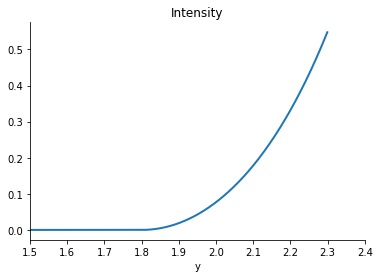

In [51]:
y = np.arange(0,2.3,0.001)
r1 = 1.5
r2=2.5
y_lower=1.8
intensity = r1*(np.exp(r2/2*(y- y_lower)**2)-1)*(y >= y_lower)
intensity2 = r1*(np.exp(r2/2*(y- 1.5)**2)-1)*(y >= 1.5)
plt.plot(y, intensity, label="1.7")
# plt.plot(y, intensity2, label="1.5")
plt.title('Intensity')
plt.xlabel('y')
plt.xlim(1.5, 2.4)
# plt.savefig('intensity_1p8.png', dpi=300)

In [53]:
y_grid[loc23]

2.3000000000000003

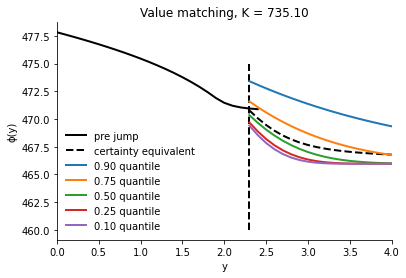

In [55]:
loc1 = np.abs(np.exp(k_grid) - 700).argmin()
plt.plot(y_grid_cap, ϕ[:, loc1], label='pre jump', color="black")
plt.plot(y_grid[loc23:], ϕ_bound[loc23:, loc1], label="certainty equivalent", 
         color="black", linestyle="dashed")
quantile_list = [0.1, 0.25, 0.5, 0.75, 0.9]
for i in range(len(quantile_list)):
    plt.plot(y_grid[loc23:], np.quantile(v_list[:, loc23:, loc1], quantile_list[4-i], axis=0), 
             label="{:.2f} quantile".format(quantile_list[4-i]))
# plt.plot(y_grid[numy_bar:], v_list[1][numy_bar:, loc1])
# plt.plot(y_grid[numy_bar:], v_list[2][numy_bar:, loc1])
# plt.plot(y_grid[numy_bar:], v_list[3][numy_bar:, loc1])
# plt.plot(y_grid[numy_bar:], v_list[4][numy_bar:, loc1])
plt.xlabel('y')
plt.vlines(2.3, 460, 475, color="black", linestyle="dashed")
plt.legend(loc=3)

plt.ylabel('ϕ(y)')
plt.title('Value matching, K = {:.2f}'.format(np.exp(k_grid[loc1])))
plt.xlim(0,4)
# plt.savefig('../figures/DICE_like/value_10_24.png', dpi=300)
plt.show()

In [56]:
ϕ.mean(), ϕ[-1, loc1], ϕ[-3, loc1], ϕ_bound[numy_bar-2, loc1]

(319.5059084226805, 470.8875576701371, 471.03992205837454, 471.409221064756)

In [58]:
(ϕ[-2, loc1] -  ϕ_bound[loc23, loc1])#/ϕ[-1, loc1]

0.16855250333009053

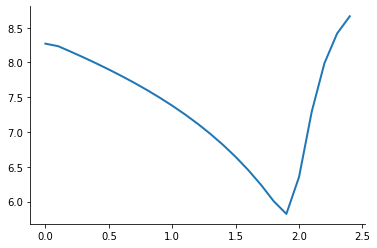

In [59]:
plt.plot(y_grid_cap, ems[:, loc1])

# Simulation

??:

$$
ME_t = \vartheta_t \theta \frac{1}{\lambda_t} \left[1 -  \frac{\mathcal{E}_t}{\alpha \lambda_t K_t }\right]^{\theta - 1}
$$

In [60]:
class GridInterp_2d():

    def __init__(self, grids, values, method = 'Linear'):

        # unpacking
        self.grids = grids
        (self.xs, self.ys) = grids
        self.nx = len(self.xs)
        self.ny = len(self.ys)
        
        self.values = values

        assert (self.nx, self.ny) == values.shape, "ValueError: Dimensions not match"
        self.method = method

    def get_value(self, x, y):

        if self.method == 'Linear':
            
            func = RegularGridInterpolator(self.grids, self.values)
            return func([x,y])[0]

        elif self.method == 'Spline':

            func1 = CubicSpline(self.xs, self.values)
            ySpace = func1(x)
            
            func2 = CubicSpline(self.ys, ySpace)
            return func2(y)

        else:
            raise ValueError('Method Not Supported')

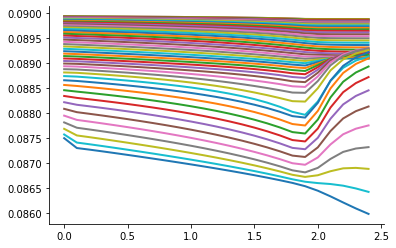

In [61]:
plt.plot(y_grid_cap, i_new)
plt.show()

In [62]:
def simulate(res, y_grid, k_grid, Time=70, ppy=4):
    ems = res['ems']
    i = res['i']
    pers = ppy * Time
    # pers = 100
    dt = Time / pers
    nDims = 3 
    its = 1

    gridpoints = (y_grid, k_grid)
    # interpolate emission
    e_func_r = GridInterp_2d(gridpoints, ems, 'Linear')
    def e_func(x):
        return e_func_r.get_value(x[0], x[1]) # match order
    # interpolate investment
    i_func_r = GridInterp_2d(gridpoints, i, 'Linear')
    def i_func(x):
        return i_func_r.get_value(x[0], x[1])

    # drifts for each diffusion process
    def compute_μlogk(x):
        return μk +  i_func(x)  - 0.5*κ*i_func(x)**2 - 0.5*σk**2
    def compute_μy(E_x):
        return  E_x*np.mean(θ_list)
    def compute_μlogd(x, E_x):
        Y_x = x[0]
        dΛ = γ1 + γ2*Y_x + γ3*(Y_x - y_bar)*(Y_x >y_bar)
        ddΛ = γ2 + γ3*(Y_x > y_bar)  
        return dΛ*compute_μy(E_x) + 0.5*ddΛ*σy**2*E_x**2

    # initial points

    K_0 = 80/α
    Y_0 = 1.1
    D_0 = -γ1*Y_0 - 0.5*γ2*Y_0**2

    hist = np.zeros([pers, nDims])
    e_hist = np.zeros([pers])
    i_hist = np.zeros([pers])

    for tm in range(pers):
        if tm == 0:
            # initial points
            hist[0,:] = [Y_0, np.log(K_0), D_0]
            e_hist[0] = e_func(hist[0,:])
            i_hist[0] = i_func(hist[0,:])

        else:
            # other periods
            hist[tm,0] = hist[tm - 1,0] + compute_μy(e_hist[tm-1])*dt# Y
            hist[tm,1] = hist[tm - 1,1] + compute_μlogk(hist[tm-1,:])*dt# logK
            hist[tm,2] = hist[tm - 1,2] + compute_μlogd(hist[tm-1,:], e_hist[tm-1])*dt # logDt
            e_hist[tm] = e_func(hist[tm,:])
            i_hist[tm] = i_func(hist[tm,:])

    e_k_ratio = e_hist/np.exp(hist[:,1])/α
    Iota_t = 1 - e_hist/np.exp(hist[:,1])/(α*λ_bar)
    XK_t = α*θ_bar*Iota_t**θ
    MUe = θ*θ_bar/λ_bar*Iota_t**(θ-1)

    simul = dict(e= e_hist, states= hist)
    return simul

In [63]:
simul_list = []
for i in range(len(res_list)):
    simul = simulate(res_list[i], y_grid, k_grid, Time=70)
    simul_list.append(simul)

Text(0.5, 0, 'Years')

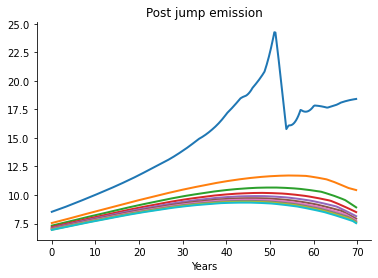

In [64]:
for i in range(len(res_list)):
    plt.plot(np.arange(0, 70, 1/4), simul_list[i]['e'])
plt.title('Post jump emission')
plt.xlabel('Years')

In [65]:
Time = 68
ppy = 1
pers = ppy * Time
# pers = 100
dt = Time / pers
nDims = 3 
its = 1

ems_pre_jump = solution['ems']
i_pre_jump = solution['i']

gridpoints = (y_grid_cap, k_grid)
# interpolate emission
e_func_r = GridInterp_2d(gridpoints, ems_pre_jump, 'Linear')
def e_func(x):
    return e_func_r.get_value(x[0], x[1]) # match order
# interpolate investment
i_func_r = GridInterp_2d(gridpoints, i_pre_jump, 'Linear')
def i_func(x):
    return i_func_r.get_value(x[0], x[1])

# drifts for each diffusion process
def compute_μlogk(x):
    return μk +  i_func(x)  - 0.5*κ*i_func(x)**2 - 0.5*σk**2
def compute_μy(E_x):
    return  E_x*np.mean(θ_list)
def compute_μlogd(x, E_x):
    Y_x = x[0]
    dΛ = γ1 + γ2*Y_x + γ3*(Y_x - y_bar)*(Y_x >y_bar)
    ddΛ = γ2 + γ3*(Y_x > y_bar)  
    return dΛ*compute_μy(E_x) + 0.5*ddΛ*σy**2*E_x**2

# initial points

K_0 = 80/α
Y_0 = 1.1
D_0 = -γ1*Y_0 - 0.5*γ2*Y_0**2

hist = np.zeros([pers, nDims])
e_hist = np.zeros([pers])
i_hist = np.zeros([pers])
prob_hist = np.zeros([pers])

for tm in range(pers):
    if tm == 0:
        # initial points
        hist[0,:] = [Y_0, np.log(K_0), D_0]
        e_hist[0] = e_func(hist[0,:])
        i_hist[0] = i_func(hist[0,:])
        prob_hist[0] = 1 - r1*(np.exp(r2/2*(hist[0,0]- y_lower)**2)-1)*(hist[0,0] >= y_lower)*dt

    else:
        # other periods
        if hist[tm - 1 , 0] <= 2.35:
            hist[tm,0] = hist[tm - 1,0] + compute_μy(e_hist[tm-1])*dt# Y
            hist[tm,1] = hist[tm - 1,1] + compute_μlogk(hist[tm-1,:])*dt# logK
            hist[tm,2] = hist[tm - 1,2] + compute_μlogd(hist[tm-1,:], e_hist[tm-1])*dt # logDt
            e_hist[tm] = e_func(hist[tm,:])
            i_hist[tm] = i_func(hist[tm,:])
            prob_hist[tm] = (1 - r1*(np.exp(r2/2*(hist[tm,0]- y_lower)**2)-1)*(hist[tm,0] >= y_lower)*dt)*prob_hist[tm-1]
        else:
            break

e_k_ratio = e_hist/np.exp(hist[:,1])/α
Iota_t = 1 - e_hist/np.exp(hist[:,1])/(α*λ_bar)
XK_t = α*θ_bar*Iota_t**θ
MUe = θ*θ_bar/λ_bar*Iota_t**(θ-1)

simul = dict(e= e_hist, states= hist)

(0.0, 20.912481205410177)

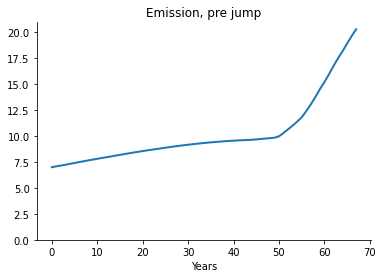

In [66]:
plt.plot(np.arange(0, Time, dt), e_hist)
plt.xlabel('Years')
plt.title('Emission, pre jump')
plt.ylim(0)
# plt.savefig('Et_pre_jump_24.png', dpi=300)

In [67]:
prob_hist.shape, prob_hist

((68,),
 array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        0.9995505 , 0.99745071, 0.99247966, 0.98342727, 0.96912975,
        0.94852032, 0.92061691, 0.88446773, 0.83936039, 0.78494176,
        0.72134788, 0.64932068, 0.57011924, 0.48577321, 0.39909826,
        0.31359523, 0.23331503, 0.16221022, 0.10351937, 0.05917945,
        0.02926317, 0.01183762, 0.0035474 ]))

Text(0.5, 0, 'Years')

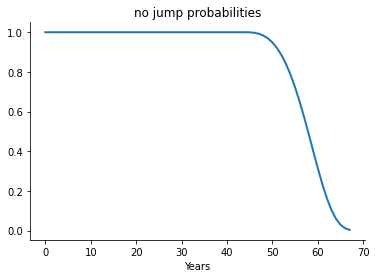

In [68]:
plt.plot(prob_hist)
plt.title('no jump probabilities')
plt.xlabel('Years')
# plt.savefig('no_jump_prob_238.png', dpi=300)

Text(0.5, 1.0, '$\\frac{E_t}{\\alpha K_t}$')

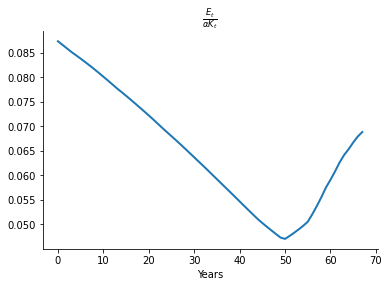

In [69]:
plt.plot(np.arange(0, Time, dt), e_k_ratio)
plt.xlabel('Years')
plt.title(r'$\frac{E_t}{\alpha K_t}$')
# plt.savefig('ratio.png')

Text(0.5, 1.0, '$\\iota_t$')

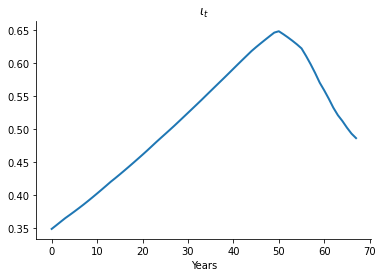

In [70]:
plt.plot(np.arange(0, Time, dt), Iota_t)
plt.xlabel('Years')
plt.title(r"$\iota_t$")
# plt.savefig('iota_t_18.png')

In [71]:
hist[:,0]

array([1.1       , 1.1130048 , 1.12615602, 1.13945194, 1.15289405,
       1.16649519, 1.18025335, 1.1941665 , 1.20823257, 1.22244767,
       1.23680834, 1.25131235, 1.26595747, 1.28074145, 1.295662  ,
       1.31073153, 1.3259455 , 1.34129998, 1.35679226, 1.37241958,
       1.3881792 , 1.40406831, 1.42008274, 1.43621552, 1.45246371,
       1.46883211, 1.48532132, 1.50192811, 1.51864842, 1.53547282,
       1.55239809, 1.56942098, 1.58653823, 1.6037466 , 1.6210409 ,
       1.63841161, 1.6558565 , 1.6733722 , 1.69095531, 1.70860246,
       1.72630541, 1.74405615, 1.76185201, 1.77969031, 1.79756841,
       1.81548218, 1.83346054, 1.85151304, 1.86964049, 1.88784367,
       1.9061234 , 1.92465008, 1.94377966, 1.96354669, 1.98398758,
       2.00514075, 2.02705999, 2.05008792, 2.07431904, 2.09985571,
       2.12680887, 2.1550471 , 2.18466801, 2.21577803, 2.24827363,
       2.28202684, 2.31715854, 2.35363642])

Text(0.5, 1.0, 'Yt')

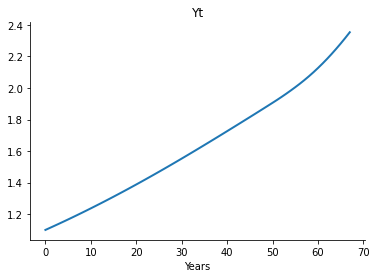

In [72]:
plt.plot(np.arange(0, Time, dt), hist[:,0])
plt.xlabel('Years')
plt.title("Yt")
# plt.savefig('Yt.png')

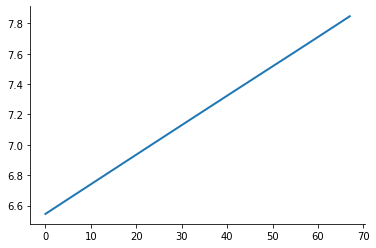

In [73]:
plt.plot(simul['states'][:, 1])